<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/E_commerce_ESG_Influence_on_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# yfinance, statsmodels, pandas, numpy, scikit-learn, xlsxwriter, linearmodels
!pip install yesg
!pip install yfinance
!pip install statsmodels
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install xlsxwriter
!pip install linearmodels

  Preparing metadata (setup.py) ... done
  Created wheel for yesg: filename=yesg-2.1.1-py3-none-any.whl size=6105 sha256=5fcd5f94688d893c6e87cb9a6f70686dd2097aa35a3066e7cd61499e475f4ccb
  Stored in directory: /root/.cache/pip/wheels/78/8d/48/f5e8ff0315a46301e15c68371e297b460b33e1c846117725bc
Successfully built yesg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00


### Fetch ESG dataset and save

In [9]:
# Required libraries: yesg, pandas
# Optional for Google Drive: google.colab
# !pip install yesg pandas

import yesg
import pandas as pd
import time # To add delays between API calls

# Attempt to import and use Google Drive specific libraries only if needed
try:
    from google.colab import drive
    google_colab_available = True
except ImportError:
    google_colab_available = False
    print("Google Colab environment not detected. Will save CSV locally.")

print("--- ESG Data Fetching Script for E-commerce Firms ---")

# --- Configuration ---

# List of tickers for E-commerce firms
TICKERS_ECOMMERCE = [
    'AMZN',   # Amazon
    'BABA',   # Alibaba (NYSE)
    'JD',     # JD.com
    'EBAY',   # eBay
    'WMT',    # Walmart
    'SE',     # Sea Limited (Shopee)
    'MELI',   # MercadoLibre
    'PDD',    # PDD Holdings
    'ETSY',   # Etsy
    'ZAL.DE', # Zalando
    'ALE.WA', # Allegro
    'TGT',    # Target
    '4755.T'  # Rakuten (Tokyo Stock Exchange)
]

# Define where to save the output file
DRIVE_MOUNT_PATH = '/content/drive'
OUTPUT_FILENAME = 'historic_esg_scores_ecommerce.csv'
OUTPUT_PATH_DRIVE = f'{DRIVE_MOUNT_PATH}/My Drive/{OUTPUT_FILENAME}' # Standard Google Drive path
OUTPUT_PATH_LOCAL = OUTPUT_FILENAME # Save in current directory if Drive fails

# Delay between API calls (in seconds) to avoid potential blocking
API_DELAY = 0.6

# --- Mount Google Drive (if in Colab) ---
drive_mounted = False
if google_colab_available:
    try:
        print(f"\nAttempting to mount Google Drive at {DRIVE_MOUNT_PATH}...")
        drive.mount(DRIVE_MOUNT_PATH)
        drive_mounted = True
        print("Google Drive mounted successfully.")
        save_path = OUTPUT_PATH_DRIVE
    except Exception as e:
        print(f"Failed to mount Google Drive: {e}")
        print(f"Output CSV will be saved locally as '{OUTPUT_PATH_LOCAL}'.")
        save_path = OUTPUT_PATH_LOCAL
else:
    # Not in Colab, saving locally
    save_path = OUTPUT_PATH_LOCAL

# --- Data Fetching Loop ---
print(f"\nTickers to fetch ESG data for: {TICKERS_ECOMMERCE}")
print("Starting ESG data download loop...")
print("WARNING: 'yesg' library relies on Yahoo Finance and may be outdated or have limited data coverage.")

# Initialize lists to store results and track progress
all_esg_data_list = []
successful_tickers = []
failed_tickers = []

for ticker in TICKERS_ECOMMERCE:
    print(f"  -> Processing: {ticker}")
    try:
        # Fetch all available historic ESG ratings for the ticker
        # Add the delay BEFORE the call
        time.sleep(API_DELAY)
        esg_scores_df = yesg.get_historic_esg(ticker)

        # Check if the result is a non-empty DataFrame
        if isinstance(esg_scores_df, pd.DataFrame) and not esg_scores_df.empty:
            # Add a column for the ticker symbol
            esg_scores_df['Ticker'] = ticker
            # Reset the index to make the date a column before appending
            esg_scores_df = esg_scores_df.reset_index()
            # Append the DataFrame to the list
            all_esg_data_list.append(esg_scores_df)
            successful_tickers.append(ticker)
            print(f"    -> Success: Found {len(esg_scores_df)} ESG data points for {ticker}.")
        else:
            # Handle cases where yesg returns None or an empty DataFrame
            print(f"    -> No valid ESG data found/returned for {ticker}")
            failed_tickers.append(ticker)
    except Exception as e:
        # Catch any other exceptions during fetching or processing
        print(f"    -> ERROR fetching/processing ESG data for {ticker}: {e}")
        failed_tickers.append(ticker)

# --- Combine and Save Data ---
if all_esg_data_list:
    print("\nCombining collected ESG data...")
    # Concatenate all the collected DataFrames into a single one
    final_esg_data = pd.concat(all_esg_data_list, ignore_index=True)

    # Standardize the date column name (it's often 'Date' or 'index' after reset_index)
    if 'index' in final_esg_data.columns and 'Date' not in final_esg_data.columns:
         final_esg_data = final_esg_data.rename(columns={'index': 'Date'})
    elif 'Date' not in final_esg_data.columns:
        print("Warning: Could not identify the primary date column after fetching. Please inspect the output.")

    # Attempt to convert Date column to datetime objects for consistency
    if 'Date' in final_esg_data.columns:
        try:
            final_esg_data['Date'] = pd.to_datetime(final_esg_data['Date'])
            print("  -> Date column converted to datetime.")
        except Exception as e:
            print(f"Warning: Could not convert 'Date' column to datetime format: {e}")

    # Display first few rows and info of the final DataFrame
    print("\nPreview of combined ESG data:")
    print(final_esg_data.head())
    print("\nData Info:")
    final_esg_data.info()

    # Save the combined data to the chosen CSV file path
    try:
        print(f"\nSaving ESG data to: {save_path} ...")
        final_esg_data.to_csv(save_path, index=False)
        print(f"ESG data saved successfully.")
    except Exception as e:
        print(f"\nERROR saving ESG data to CSV at '{save_path}': {e}")

else:
    # Message if no data was collected at all
    print("\nNo ESG data was successfully collected for any ticker. No CSV file created.")

# --- Final Summary ---
print("\n--- ESG Fetching Summary ---")
print(f"Successfully fetched ESG for ({len(successful_tickers)} tickers): {successful_tickers}")
print(f"Failed or no ESG data for ({len(failed_tickers)} tickers): {failed_tickers}")
print("--- Script Finished ---")

--- ESG Data Fetching Script for E-commerce Firms ---

Attempting to mount Google Drive at /content/drive...
Failed to mount Google Drive: Error: credential propagation was unsuccessful
Output CSV will be saved locally as 'historic_esg_scores_ecommerce.csv'.

Tickers to fetch ESG data for: ['AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD', 'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T']
Starting ESG data download loop...
  -> Processing: AMZN
    -> Success: Found 128 ESG data points for AMZN.
  -> Processing: BABA
    -> Success: Found 128 ESG data points for BABA.
  -> Processing: JD
    -> Success: Found 98 ESG data points for JD.
  -> Processing: EBAY
    -> Success: Found 128 ESG data points for EBAY.
  -> Processing: WMT
    -> Success: Found 128 ESG data points for WMT.
  -> Processing: SE
    -> Success: Found 6 ESG data points for SE.
  -> Processing: MELI
    -> Success: Found 7 ESG data points for MELI.
  -> Processing: PDD
    -> Success: Found 7 ESG data points for PD

### Fetch E-Commerce firms' ESG dataset

In [4]:
# !pip install yfinance statsmodels pandas numpy scikit-learn xlsxwriter linearmodels

# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import statsmodels.api as sm
import warnings
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
import xlsxwriter
from linearmodels.panel import PanelOLS # Import panel models
import statsmodels.formula.api as smf
import re

# --- Settings and Configuration ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
# from linearmodels.shared.exceptions import AbsorbingEffectWarning # Might occur with TWFE
# warnings.simplefilter('ignore', AbsorbingEffectWarning)


style.use("default")

# --- Define Tickers for E-commerce Firms ---
TICKERS_ECOMMERCE = [
    'AMZN',   # Amazon
    'BABA',   # Alibaba (NYSE)
    'JD',     # JD.com
    'EBAY',   # eBay
    'WMT',    # Walmart
    'SE',     # Sea Limited (Shopee)
    'MELI',   # MercadoLibre
    'PDD',    # PDD Holdings
    'ETSY',   # Etsy
    'ZAL.DE', # Zalando
    'ALE.WA', # Allegro
    'TGT',    # Target
    '4755.T'  # Rakuten (Tokyo Stock Exchange)
]


# Define Date Range
START_DATE_PRICES = "2019-01-01" # Adjusted start for potentially longer histories
END_DATE_PRICES = "2024-12-31"
START_DATE_ANALYSIS = "2020-01-01" # Start analysis after potential initial data noise/lag
END_DATE_ANALYSIS = "2024-12-31"

# --- !!! IMPORTANT: UPDATE THIS PATH !!! ---
# --- Point this to your downloaded Fama-French 5 Factors (or similar) CSV file ---
# --- The file should have a date column and columns like 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF' ---
FF_FACTORS_PATH = "/content/gd_Developed_5_Factors.csv" # MODIFY REQUIRED

print("--- E-commerce Stock Analysis Script Started ---")
print(f"Tickers to Analyze: {TICKERS_ECOMMERCE}")
print(f"Analysis Period: {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}")
print(f"Factor File: {FF_FACTORS_PATH}")
if FF_FACTORS_PATH == "/content/gd_Developed_5_Factors.csv":
     print("\n*** WARNING: Please update the FF_FACTORS_PATH variable to your actual factor file location! ***\n")
     # sys.exit() # Optional: Uncomment to force user to change the path

# --- Advanced Imputation Function (Defined Once) ---
def advanced_imputation(df_input):
    df = df_input.copy(); original_index = df.index; original_cols = df.columns
    # Handle potential non-numeric columns before imputation
    numeric_cols = df.select_dtypes(include=np.number).columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    df_numeric = df[numeric_cols].copy()
    df_non_numeric = df[non_numeric_cols].copy()

    all_missing_cols = df_numeric.columns[df_numeric.isnull().all()]
    df_imputable = df_numeric.copy()
    if len(all_missing_cols) > 0:
        print(f"  -> Imputation: Dropping {len(all_missing_cols)} all-NaN numeric columns: {list(all_missing_cols)}")
        df_imputable = df_imputable.drop(columns=all_missing_cols)

    cols_to_impute = df_imputable.columns[df_imputable.isnull().any()]
    imputed_data_numeric = df_imputable.copy() # Start with data potentially having columns dropped

    if df_imputable.isnull().sum().sum() == 0:
        print("  -> Imputation: No missing values found in numeric columns. Skipping imputation.")
    elif len(cols_to_impute) > 0:
        print(f"  -> Imputation: Imputing {len(cols_to_impute)} numeric columns using IterativeImputer (BayesianRidge)...")
        n_features = min(10, df_imputable.shape[1] - 1) if df_imputable.shape[1] > 1 else 1
        imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=30, random_state=42, tol=1e-4, n_nearest_features=n_features, verbose=0)
        try:
            with warnings.catch_warnings(): warnings.simplefilter("ignore")
            # Ensure index alignment during imputation if possible, although IterativeImputer works on values
            imputable_index = df_imputable.index
            imputed_values = imputer.fit_transform(df_imputable[cols_to_impute])
            imputed_subset = pd.DataFrame(imputed_values, columns=cols_to_impute, index=imputable_index)
            imputed_data_numeric[cols_to_impute] = imputed_subset # Assign back imputed values
            print(f"  -> Imputation: Completed for {len(cols_to_impute)} numeric columns.")
        except Exception as e:
            print(f"  -> Imputation: Error during imputation: {e}. Returning numeric data with NaNs.")
            # imputed_data_numeric remains df_imputable in case of error
    else:
        print("  -> Imputation: No numeric columns required imputation.")

    # Reconstruct the dataframe, ensuring original columns and index are preserved
    # Start with an empty DataFrame with the original index and columns
    final_imputed_df = pd.DataFrame(index=original_index, columns=original_cols)
    # Fill in the imputed numeric data
    final_imputed_df.update(imputed_data_numeric)
    # Fill in the original non-numeric data
    final_imputed_df.update(df_non_numeric)


    try:
        # Convert only the intended numeric columns back to float, handle errors column-wise
        for col in numeric_cols: # Iterate over original numeric cols
            if col in final_imputed_df.columns: # Check if it wasn't dropped
                final_imputed_df[col] = pd.to_numeric(final_imputed_df[col], errors='coerce')
    except Exception as e:
        print(f"  -> Imputation: Warning: Could not convert some imputed data back to numeric: {e}")

    return final_imputed_df


# --- Step 1: Download and Prepare ACTUAL Stock Returns ---
print("\n--- Downloading and Preparing Stock Returns ---")
tickers_available = [] # Initialize list of tickers with actual data
stock_monthly_returns = pd.DataFrame()
try:
    # Download using the potential list
    all_stock_data = yf.download(TICKERS_ECOMMERCE, start=START_DATE_PRICES, end=END_DATE_PRICES, progress=False)
    if all_stock_data.empty: raise ValueError("No stock price data downloaded.")

    # --- Robustly Select Price Data ---
    if isinstance(all_stock_data.columns, pd.MultiIndex):
        # Find the correct price column ('Adj Close' preferred, fallback to 'Close')
        price_col_level = all_stock_data.columns.levels[0]
        if 'Adj Close' in price_col_level: price_data = all_stock_data['Adj Close']
        elif 'Close' in price_col_level: price_data = all_stock_data['Close']; print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
        else:
             # If neither is top level, maybe they are nested? Try finding them deeper.
             adj_close_cols = [col for col in all_stock_data.columns if col[0] == 'Adj Close']
             if adj_close_cols:
                 price_data = all_stock_data[adj_close_cols]
                 price_data.columns = [col[1] for col in adj_close_cols] # Flatten multi-index
             else:
                 close_cols = [col for col in all_stock_data.columns if col[0] == 'Close']
                 if close_cols:
                     price_data = all_stock_data[close_cols]
                     price_data.columns = [col[1] for col in close_cols] # Flatten multi-index
                     print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
                 else:
                     raise ValueError("Could not find 'Adj Close' or 'Close' price columns.")
    elif isinstance(all_stock_data, pd.DataFrame) and not all_stock_data.columns.nlevels > 1:
         # Handle case where yfinance returns a simple DataFrame (e.g., only one ticker worked)
         if 'Adj Close' in all_stock_data.columns: price_data = all_stock_data[['Adj Close']]
         elif 'Close' in all_stock_data.columns: price_data = all_stock_data[['Close']]; print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
         else: raise ValueError("Neither 'Adj Close' nor 'Close' found in single DataFrame.")
         # Rename column to ticker if possible (heuristic)
         if len(TICKERS_ECOMMERCE) == 1: price_data.columns = TICKERS_ECOMMERCE

    else:
         raise ValueError("Unexpected data structure returned from yfinance.")

    # Forward fill, backward fill, drop columns that are entirely NaN
    price_data = price_data.ffill().bfill()
    price_data = price_data.dropna(axis=1, how='all')

    if price_data.empty: raise ValueError("All stock price columns NaN after fill.")
    tickers_available = list(price_data.columns) # FINAL list of tickers with price data

    # Clean up ticker names if they have extra suffixes from yfinance internal multiindex handling
    tickers_available = [re.sub(r'\..*', '', t) if '.' in t and not t.endswith(('.DE', '.WA', '.T')) else t for t in tickers_available] # Basic cleanup, keep exchange suffixes
    price_data.columns = tickers_available # Apply cleaned names back

    print(f"  -> Stock price data obtained for {len(tickers_available)} tickers: {tickers_available}")


    price_data.index = pd.to_datetime(price_data.index)
    monthly_prices = price_data.resample('ME').last() # Use 'ME' for month-end frequency
    stock_monthly_returns = monthly_prices.pct_change().dropna(how='all', axis=0)

    if stock_monthly_returns.empty: raise ValueError("Monthly returns empty after calculation.")
    print("Actual stock monthly returns calculated.")

except FileNotFoundError: print(f"\n FATAL ERROR: Ticker file not found (if using a file)"); sys.exit()
except Exception as e: print(f" FATAL ERROR downloading/processing stock returns: {e}"); import traceback; traceback.print_exc(); sys.exit()


# --- Step 2: Load and Prepare Factors Data ---
print("\n--- Loading and Preparing Factors Data ---")
ff_factors_monthly = pd.DataFrame()
try:
    # Adjust reading based on common F-F file formats (might need skiprows)
    # Try detecting header row automatically, assuming date is the first column
    try:
        ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, index_col=0, parse_dates=True)
        print("  -> Attempting to read factor CSV with first column as date index.")
    except (ValueError, TypeError):
        print("  -> First attempt failed, trying different parsing strategy (potential header rows)...")
        # Look for the first row where the first column looks like a year (e.g., 4 digits)
        with open(FF_FACTORS_PATH, 'r') as f:
            lines = f.readlines()
        skiprows = 0
        for i, line in enumerate(lines):
            parts = line.split(',')
            if len(parts) > 0 and re.match(r'^\s*\d{4,8}\s*$', parts[0].strip()):
                 # Check if the NEXT line looks like data (e.g., starts with numbers)
                 if i + 1 < len(lines):
                    next_parts = lines[i+1].split(',')
                    try:
                        pd.to_numeric(next_parts[1]) # Check if second column is numeric
                        skiprows = i + 1 # Header is the line *before* this data line
                        print(f"  -> Detected potential header ending at row {skiprows}. Reading again.")
                        break
                    except (ValueError, IndexError):
                         continue
                 else: # Reached end of file while looking for data
                     skiprows = i # Assume the line with the year was the header
                     print(f"  -> Detected potential header ending at row {skiprows} (last line check). Reading again.")
                     break
        ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, skiprows=skiprows, index_col=0, parse_dates=False) # Parse dates later


    # Clean column names (remove whitespace, special chars)
    ff_factors_monthly_raw.columns = [col.strip().replace('-', '_').replace('.', '') for col in ff_factors_monthly_raw.columns]

    # Attempt to parse index as date (handle YYYYMM or other formats)
    try:
        # Try standard date parsing first
        ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, errors='coerce')
    except Exception:
         # If standard parsing fails, try YYYYMM format
        try:
            ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, format='%Y%m', errors='coerce')
            print("  -> Parsed factor index assuming YYYYMM format.")
        except Exception as e_fmt:
             raise ValueError(f"Could not parse factor dates automatically. Please check format. Error: {e_fmt}")


    ff_factors_monthly_raw = ff_factors_monthly_raw[pd.notna(ff_factors_monthly_raw.index)]
    if ff_factors_monthly_raw.empty: raise ValueError("All rows dropped during factors date parsing.")

    # Convert factor columns to numeric
    for col in ff_factors_monthly_raw.columns:
         ff_factors_monthly_raw[col] = pd.to_numeric(ff_factors_monthly_raw[col], errors='coerce')

    # Ensure index is DatetimeIndex and set to month end
    if not pd.api.types.is_datetime64_any_dtype(ff_factors_monthly_raw.index):
        raise TypeError("Factor index is not a DatetimeIndex after parsing attempts.")

    # Resample to Monthly IF the source data is daily, otherwise just align to month end
    inferred_freq = pd.infer_freq(ff_factors_monthly_raw.index)
    print(f"  -> Inferred factor data frequency: {inferred_freq}")
    if inferred_freq and inferred_freq.startswith('D'):
         print("  -> Resampling daily factors to month end using last value.")
         # For factors like Mkt-RF etc., summing or averaging might be better, but let's use last for simplicity first
         # RF usually needs the last value. Others depend on how they are calculated. Let's assume last value is acceptable.
         ff_factors_monthly_raw = ff_factors_monthly_raw.resample('ME').last()
    else:
         # Assume already monthly or coarser, just align date to month end
         ff_factors_monthly_raw.index = ff_factors_monthly_raw.index + pd.offsets.MonthEnd(0)


    ff_factors_monthly_raw = ff_factors_monthly_raw[~ff_factors_monthly_raw.index.duplicated(keep='last')]

    # Filter factors based on the *stock price* date range (allowing for lags later)
    ff_factors_monthly_raw = ff_factors_monthly_raw[
        (ff_factors_monthly_raw.index >= pd.to_datetime(START_DATE_PRICES)) &
        (ff_factors_monthly_raw.index <= pd.to_datetime(END_DATE_PRICES))
    ]

    if ff_factors_monthly_raw.empty: raise ValueError("No factor data remains after filtering for price period.")
    print("Factors data loaded, cleaned, date-filtered.")

    # Impute missing factor values
    if ff_factors_monthly_raw.isnull().sum().sum() > 0:
        print("\n--- Imputing Missing Values in Factors Data ---")
        ff_factors_monthly = advanced_imputation(ff_factors_monthly_raw)
    else:
        print("\n--- No missing values detected in factors data. ---")
        ff_factors_monthly = ff_factors_monthly_raw.astype(float) # Ensure float type

    # Check factor magnitudes (potential percentage points vs decimals)
    # Use cleaned column names (e.g., Mkt_RF)
    factor_cols_to_check = ["Mkt_RF", "SMB", "HML", "RMW", "CMA", "RF", "MOM"]
    for col in factor_cols_to_check:
        if col in ff_factors_monthly.columns and pd.api.types.is_numeric_dtype(ff_factors_monthly[col]):
            # Check absolute values excluding potential outliers for magnitude check
            q_low = ff_factors_monthly[col].quantile(0.05)
            q_high = ff_factors_monthly[col].quantile(0.95)
            median_abs_val = ff_factors_monthly[col][(ff_factors_monthly[col] >= q_low) & (ff_factors_monthly[col] <= q_high)].abs().median()

            if not pd.isna(median_abs_val) and median_abs_val > 0.5: # If median abs value (non-outlier) > 50%
                 print(f"  -> Converting factor '{col}' assuming percentage points (median abs val > 0.5).")
                 ff_factors_monthly[col] = ff_factors_monthly[col] / 100.0
            elif col == 'RF' and not pd.isna(median_abs_val) and median_abs_val > 0.2: # Risk free rate check separately
                 print(f"  -> Converting factor '{col}' assuming percentage points (median abs val > 0.2).")
                 ff_factors_monthly[col] = ff_factors_monthly[col] / 100.0


except FileNotFoundError: print(f"\n FATAL ERROR: Factors file not found: {FF_FACTORS_PATH}"); sys.exit()
except Exception as e: print(f"\n FATAL ERROR loading/processing Factors Data: {e}"); import traceback; traceback.print_exc(); sys.exit()


# --- Step 3: Filter Factors for Analysis Period ---
# No lagging of company-specific factors needed here, just filter the date range
print("\n--- Filtering Factors for Analysis Period ---")
factors_analysis_period = ff_factors_monthly[
    (ff_factors_monthly.index >= pd.to_datetime(START_DATE_ANALYSIS)) &
    (ff_factors_monthly.index <= pd.to_datetime(END_DATE_ANALYSIS))
].copy()

if factors_analysis_period.empty:
    print(f" FATAL ERROR: Factor data is empty after filtering for analysis period: {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}. Check date ranges and factor file content.");
    sys.exit()
print(f"Factors filtered for analysis. Data available from: {factors_analysis_period.index.min().date()} to {factors_analysis_period.index.max().date()}")

# --- Step 4: Prepare Data for Panel Regression ---
print("\n--- Preparing Data for Panel Analysis ---")
panel_data = pd.DataFrame()
try:
    # Find common dates between returns and filtered factors
    common_index = stock_monthly_returns.index.intersection(factors_analysis_period.index)
    if len(common_index) == 0:
        raise ValueError(f"No overlapping dates found between stock returns and factors in the analysis period ({START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}).")

    # Align returns and factors to common dates
    aligned_returns = stock_monthly_returns.loc[common_index, tickers_available].copy().astype(float)
    aligned_factors = factors_analysis_period.loc[common_index].copy().astype(float)
    print(f"Aligned stock and factor data for {len(common_index)} months.")

    # Check for Risk-Free Rate ('RF' or 'Rf')
    rf_col = None
    if 'RF' in aligned_factors.columns: rf_col = 'RF'
    elif 'Rf' in aligned_factors.columns: rf_col = 'Rf' # Common alternative naming
    else: raise ValueError("Risk-Free rate ('RF' or 'Rf') not found in factor data.")
    print(f"  -> Using '{rf_col}' as the risk-free rate column.")
    risk_free_rate = aligned_factors[rf_col]

    # Calculate Excess Returns
    excess_returns = aligned_returns.subtract(risk_free_rate, axis=0)

    # Stack returns for panel format
    excess_returns_long = excess_returns.stack(dropna=False).reset_index() # Keep NaNs for now
    excess_returns_long.columns = ['Date', 'Ticker', 'ExcessReturn']

    # Identify available market factors (using cleaned names)
    market_factors = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM'] # Use cleaned names
    market_factors_present = [f for f in market_factors if f in aligned_factors.columns]
    if not market_factors_present: raise ValueError("No standard market factors (Mkt_RF, SMB, etc.) found in the factor data.")
    print(f"  -> Market factors found: {market_factors_present}")

    factors_market_wide = aligned_factors[market_factors_present].reset_index()
    factors_market_wide.rename(columns={'index': 'Date'}, inplace=True) # Ensure date column name consistency

    # Merge excess returns with market-wide factors
    panel_data = pd.merge(excess_returns_long, factors_market_wide, on='Date', how='left')

    # Set MultiIndex
    panel_data['Date'] = pd.to_datetime(panel_data['Date'])
    # Check for duplicate index entries before setting
    if panel_data.duplicated(subset=['Ticker', 'Date']).any():
        print("Warning: Duplicate Ticker/Date combinations found before setting index. Dropping duplicates.")
        panel_data = panel_data.drop_duplicates(subset=['Ticker', 'Date'], keep='first')

    panel_data = panel_data.set_index(['Ticker', 'Date']).sort_index()

    # Define essential columns for the regression (dependent + independent)
    # No ESG lags here
    essential_cols_check = ['ExcessReturn'] + market_factors_present
    initial_rows = len(panel_data)
    panel_data = panel_data.dropna(subset=essential_cols_check)
    rows_dropped = initial_rows - len(panel_data)
    if rows_dropped > 0:
        print(f"Dropped {rows_dropped} rows due to NaNs in essential model columns (ExcessReturn or Factors).")

    if panel_data.empty:
        raise ValueError("Panel data is empty after merging factors and dropping NaNs in essential columns.")

    print(f"Panel data prepared successfully with {len(panel_data)} observations.")
    print(f"Tickers included in final panel: {panel_data.index.get_level_values('Ticker').unique().tolist()}")


except Exception as e:
    print(f" FATAL ERROR preparing panel data: {e}")
    import traceback
    traceback.print_exc()
    sys.exit()


# --- Step 5: Run Panel Regressions for All Firms ---
print("\n--- Running Panel Regressions (All E-commerce Firms) ---")

# Define the formula using available factors
base_factors_present_final = [f for f in market_factors if f in panel_data.columns] # Reconfirm factors in final data
if not base_factors_present_final:
    print("FATAL ERROR: No base factors found in the final panel data for regression.")
    sys.exit()

# Ensure 'Mkt_RF' is used if 'Mkt-RF' was the original name but got renamed (should be handled above)
# Formula construction handles cleaned names directly
formula_all_firms = f"ExcessReturn ~ 1 + {' + '.join(base_factors_present_final)}"
print(f"\nRegression Formula:\n{formula_all_firms}")

all_model_summaries = {}
results_data = {} # Store results for easier comparison later

num_entities = len(panel_data.index.get_level_values('Ticker').unique())
num_time_periods = len(panel_data.index.get_level_values('Date').unique())
num_regressors = len(base_factors_present_final)

print(f"Dataset contains {num_entities} entities and {num_time_periods} time periods.")

# --- Model 1: Pooled OLS (Less common for panel, but for baseline) ---
model_key_pooled = "Pooled_OLS"
try:
    if len(panel_data) < num_regressors + 2:
         raise ValueError(f"Not enough observations ({len(panel_data)}) for Pooled OLS.")
    # Check for perfect collinearity / zero variance before fitting
    exog_vars = panel_data[base_factors_present_final]
    if (exog_vars.var(ddof=0) == 0).any():
         zero_var_cols = exog_vars.columns[(exog_vars.var(ddof=0) == 0)]
         print(f"  -> Warning: Zero variance in predictor(s) for Pooled OLS: {list(zero_var_cols)}. Model might fail or be unreliable.")

    # Use linearmodels PooledOLS for consistency
    model_pooled = PanelOLS.from_formula(formula_all_firms, data=panel_data)
    # Fit with robust standard errors (heteroskedasticity-robust)
    pooled_res = model_pooled.fit(cov_type='robust')
    print(f"\n--- Pooled OLS Results ---")
    print(pooled_res)
    all_model_summaries[model_key_pooled] = pooled_res.summary
    results_data[model_key_pooled] = pooled_res

except Exception as e:
    print(f"ERROR fitting Pooled OLS: {e}")
    all_model_summaries[model_key_pooled] = f"Error: {e}"
    results_data[model_key_pooled] = None

# --- Model 2: Entity Fixed Effects ---
model_key_fe = "Entity_FE"
try:
    if num_entities < 1:
         raise ValueError("No entities found in panel data for Entity FE.")
    if len(panel_data) < num_regressors + num_entities + 1:
         print(f"  -> Warning: Potentially not enough observations ({len(panel_data)}) for reliable Entity FE ({num_regressors} regressors + {num_entities} entities).")
    # Check variance again just in case (should be same as pooled)
    exog_vars_fe = panel_data[base_factors_present_final]
    if (exog_vars_fe.var(ddof=0) == 0).any():
         zero_var_cols_fe = exog_vars_fe.columns[(exog_vars_fe.var(ddof=0) == 0)]
         print(f"  -> Warning: Zero variance in predictor(s) for Entity FE: {list(zero_var_cols_fe)}.")

    # Clustering by entity is standard for Entity FE models when N > 1
    cluster_entity_flag_fe = num_entities > 1
    model_fe = PanelOLS.from_formula(formula_all_firms + " + EntityEffects", data=panel_data, drop_absorbed=True)
    fe_res = model_fe.fit(cov_type='clustered', cluster_entity=cluster_entity_flag_fe)
    print(f"\n--- Fixed Effects (Entity) Results ---")
    print(fe_res)
    all_model_summaries[model_key_fe] = fe_res.summary
    results_data[model_key_fe] = fe_res


except Exception as e:
    print(f"ERROR fitting Entity FE: {e}")
    all_model_summaries[model_key_fe] = f"Error: {e}"
    results_data[model_key_fe] = None


# --- Model 3: Two-Way Fixed Effects (Entity + Time) ---
model_key_twfe = "TwoWay_FE"
try:
    # Check conditions for TWFE (N > 1, T > 1, enough obs)
    # Non-absorbed regressors = base_factors_present_final
    num_exog_twfe = len(base_factors_present_final)
    if num_entities <= 1 or num_time_periods <= 1:
         print(f"  -> Skipping Two-Way FE: Requires N > 1 and T > 1 (Have N={num_entities}, T={num_time_periods}).")
         all_model_summaries[model_key_twfe] = "Skipped: N <= 1 or T <= 1"
         results_data[model_key_twfe] = None
    elif len(panel_data) < num_regressors + num_entities + num_time_periods:
         print(f"  -> Warning: Potentially not enough observations ({len(panel_data)}) for reliable Two-Way FE ({num_regressors} regressors + {num_entities} entities + {num_time_periods} time periods).")
         # Proceed but be cautious
    else:
        # Check variance of non-absorbed predictors again
        exog_vars_twfe = panel_data[base_factors_present_final]
        if (exog_vars_twfe.var(ddof=0) == 0).any():
             zero_var_cols_twfe = exog_vars_twfe.columns[(exog_vars_twfe.var(ddof=0) == 0)]
             print(f"  -> Warning: Zero variance in predictor(s) for Two-Way FE: {list(zero_var_cols_twfe)}.")

        model_twfe = PanelOLS.from_formula(formula_all_firms + " + EntityEffects + TimeEffects", data=panel_data, drop_absorbed=True)
        # Use two-way clustering (entity and time) for TWFE models
        with warnings.catch_warnings():
             warnings.simplefilter("ignore") # Ignore potential absorbing effect warnings if drop_absorbed=True handles it
             twfe_res = model_twfe.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

        print(f"\n--- Fixed Effects (Two-Way: Entity + Time) Results ---")
        print(twfe_res)
        all_model_summaries[model_key_twfe] = twfe_res.summary
        results_data[model_key_twfe] = twfe_res


except Exception as e:
    print(f"ERROR fitting Two-Way FE: {e}")
    all_model_summaries[model_key_twfe] = f"Error: {e}"
    results_data[model_key_twfe] = None


# --- Step 6: Save Results ---
print("\n--- Saving Regression Results ---")
output_excel_path = 'panel_regression_results_ecommerce.xlsx'
try:
    with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
        workbook = writer.book
        # Add a summary sheet comparing key stats if desired (optional)
        # For example, R-squared, coefficients for Mkt_RF

        # Write full summaries to separate sheets
        for model_name, summary_obj in all_model_summaries.items():
            # Sanitize sheet name (max 31 chars, no invalid chars)
            sheet_name = re.sub(r'[\\/*?:\[\]]', '_', model_name)[:31]
            worksheet = workbook.add_worksheet(sheet_name)
            if isinstance(summary_obj, str): # Handle errors or skipped models
                 worksheet.write_string(0, 0, summary_obj)
            elif hasattr(summary_obj, 'as_text'):
                 summary_text = summary_obj.as_text()
                 # Set column width for better readability
                 worksheet.set_column(0, 0, 120) # Adjust width as needed
                 worksheet.write_string(0, 0, summary_text)
            else:
                 worksheet.write_string(0, 0, "Unexpected result object format.")
    print(f"Regression summaries saved to '{output_excel_path}'.")
except Exception as e:
    print(f"Error saving results to Excel: {e}")

print("\n--- Script Finished ---")

--- E-commerce Stock Analysis Script Started ---
Tickers to Analyze: ['AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD', 'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T']
Analysis Period: 2020-01-01 to 2024-12-31
Factor File: /content/gd_Developed_5_Factors.csv

*** WARNING: Please update the FF_FACTORS_PATH variable to your actual factor file location! ***


--- Downloading and Preparing Stock Returns ---
YF.download() has changed argument auto_adjust default to True
  -> Warning: Using 'Close' price as 'Adj Close' not found.
  -> Stock price data obtained for 13 tickers: ['4755.T', 'ALE.WA', 'AMZN', 'BABA', 'EBAY', 'ETSY', 'JD', 'MELI', 'PDD', 'SE', 'TGT', 'WMT', 'ZAL.DE']
Actual stock monthly returns calculated.

--- Loading and Preparing Factors Data ---
  -> Attempting to read factor CSV with first column as date index.
  -> Inferred factor data frequency: MS
Factors data loaded, cleaned, date-filtered.

--- Imputing Missing Values in Factors Data ---
  -> Imputation: Imputing 1

/usr/local/lib/python3.11/dist-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


### Improved Model

--- E-commerce Stock Analysis Script Started (Time-Varying Betas) ---
Tickers to Analyze: ['AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD', 'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T']
Analysis Period: 2020-01-01 to 2024-12-31
Factor File: /content/gd_Developed_5_Factors.csv
Rolling Window: 36 months

--- Downloading and Preparing Stock Returns ---
  -> Stock price data obtained for 13 tickers: ['4755.T', 'ALE.WA', 'AMZN', 'BABA', 'EBAY', 'ETSY', 'JD', 'MELI', 'PDD', 'SE', 'TGT', 'WMT', 'ZAL.DE']
Actual stock monthly returns calculated.

--- Loading and Preparing Factors Data ---
Factors data loaded, cleaned, date-filtered.

--- Filtering Factors for Analysis Period ---
Factors filtered. Data available from: 2020-01-31 to 2024-12-31

--- Preparing Data for Rolling Analysis ---
Aligned stock and factor data for 60 months.
  -> Market factors used: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
Data prepared for rolling analysis with 60 rows.
Tickers included: ['4755.T', 'ALE.WA'

<Figure size 1400x700 with 0 Axes>

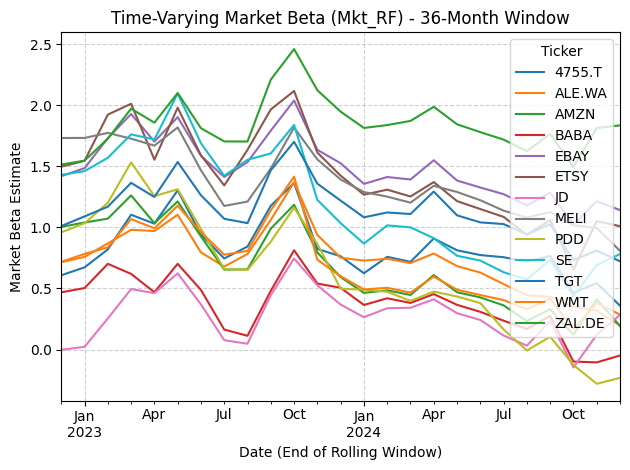


Average Factor Betas (across time):
Ticker        4755.T    ALE.WA      AMZN      BABA      EBAY      ETSY  \
2022-12-31 -0.091736 -0.416245 -0.624752  0.119515  0.049389 -0.605870   
2023-01-31  0.184082 -0.253670 -0.341696  0.079703  0.245309  0.137428   
2023-02-28  0.262405 -0.225017 -0.419797  0.137434  0.399666  0.406991   
2023-03-31  0.931284  0.140175  0.069677  0.072078  0.939407  0.763599   
2023-04-30  0.910587  0.205742 -0.080994  0.158187  0.781656  0.360054   
2023-05-31  1.378233  0.438654  0.247371  0.555607  1.105934  1.098565   
2023-06-30  1.433511  0.486294  0.310295  0.600680  1.177469  1.199284   
2023-07-31  1.314909  0.393601  0.171565  0.559939  1.023885  1.092194   
2023-08-31  1.186951  0.216009 -0.063696  0.170839  0.928318  0.973795   
2023-09-30  0.956283  0.172368 -0.016910  0.116778  0.906501  0.991850   
2023-10-31  1.173455  0.376344  0.126961  0.322349  1.136382  1.094728   
2023-11-30  1.397279  0.458302  0.233779  0.311268  1.225519  1.313055   
2

In [5]:
# !pip install yfinance statsmodels pandas numpy scikit-learn xlsxwriter linearmodels matplotlib

# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import statsmodels.api as sm # Used for OLS in rolling regression
import warnings
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
import xlsxwriter
# from linearmodels.panel import PanelOLS # No longer primary method, but keep if needed for comparison
# import statsmodels.formula.api as smf # Not used for rolling OLS here
import re
from functools import partial # Useful for rolling apply, though loop is clearer here

# --- Settings and Configuration ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning, HessianInversionWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning) # Ignore potential issues in rolling OLS fits

style.use("default")

# --- Define Tickers for E-commerce Firms ---
TICKERS_ECOMMERCE = [
    'AMZN',   # Amazon
    'BABA',   # Alibaba (NYSE)
    'JD',     # JD.com
    'EBAY',   # eBay
    'WMT',    # Walmart
    'SE',     # Sea Limited (Shopee)
    'MELI',   # MercadoLibre
    'PDD',    # PDD Holdings
    'ETSY',   # Etsy
    'ZAL.DE', # Zalando
    'ALE.WA', # Allegro
    'TGT',    # Target
    '4755.T'  # Rakuten (Tokyo Stock Exchange)
]

# Define Date Range
START_DATE_PRICES = "2019-01-01"
END_DATE_PRICES = "2024-12-31"
START_DATE_ANALYSIS = "2020-01-01"
END_DATE_ANALYSIS = "2024-12-31"

# --- !!! IMPORTANT: Use your actual path !!! ---
FF_FACTORS_PATH = "/content/gd_Developed_5_Factors.csv" # MODIFY REQUIRED

# --- Define Rolling Window Size ---
ROLLING_WINDOW_MONTHS = 36 # e.g., 3 years. Adjust as needed.

print("--- E-commerce Stock Analysis Script Started (Time-Varying Betas) ---")
print(f"Tickers to Analyze: {TICKERS_ECOMMERCE}")
print(f"Analysis Period: {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}")
print(f"Factor File: {FF_FACTORS_PATH}")
print(f"Rolling Window: {ROLLING_WINDOW_MONTHS} months")
# --- Add warning back if needed ---
# if FF_FACTORS_PATH == "/path/to/your/F-F_Research_Data_5_Factors_2x3_daily_CSV/or_monthly.csv":
#      print("\n*** WARNING: Please update the FF_FACTORS_PATH variable to your actual factor file location! ***\n")

# --- Advanced Imputation Function (Same as before) ---
def advanced_imputation(df_input):
    df = df_input.copy(); original_index = df.index; original_cols = df.columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    df_numeric = df[numeric_cols].copy(); df_non_numeric = df[non_numeric_cols].copy()
    all_missing_cols = df_numeric.columns[df_numeric.isnull().all()]
    df_imputable = df_numeric.copy()
    if len(all_missing_cols) > 0:
        # print(f"  -> Imputation: Dropping {len(all_missing_cols)} all-NaN numeric columns: {list(all_missing_cols)}")
        df_imputable = df_imputable.drop(columns=all_missing_cols)
    cols_to_impute = df_imputable.columns[df_imputable.isnull().any()]
    imputed_data_numeric = df_imputable.copy()
    if df_imputable.isnull().sum().sum() == 0:
        # print("  -> Imputation: No missing values found in numeric columns. Skipping imputation.")
        pass
    elif len(cols_to_impute) > 0:
        # print(f"  -> Imputation: Imputing {len(cols_to_impute)} numeric columns using IterativeImputer (BayesianRidge)...")
        n_features = min(10, df_imputable.shape[1] - 1) if df_imputable.shape[1] > 1 else 1
        imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=30, random_state=42, tol=1e-4, n_nearest_features=n_features, verbose=0)
        try:
            with warnings.catch_warnings(): warnings.simplefilter("ignore")
            imputable_index = df_imputable.index
            imputed_values = imputer.fit_transform(df_imputable[cols_to_impute])
            imputed_subset = pd.DataFrame(imputed_values, columns=cols_to_impute, index=imputable_index)
            imputed_data_numeric[cols_to_impute] = imputed_subset
            # print(f"  -> Imputation: Completed for {len(cols_to_impute)} numeric columns.")
        except Exception as e:
            # print(f"  -> Imputation: Error during imputation: {e}. Returning numeric data with NaNs.")
            pass
    # else: print("  -> Imputation: No numeric columns required imputation.")
    final_imputed_df = pd.DataFrame(index=original_index, columns=original_cols)
    final_imputed_df.update(imputed_data_numeric)
    final_imputed_df.update(df_non_numeric)
    try:
        for col in numeric_cols:
            if col in final_imputed_df.columns:
                final_imputed_df[col] = pd.to_numeric(final_imputed_df[col], errors='coerce')
    except Exception as e: print(f"  -> Imputation: Warning: Could not convert some imputed data back to numeric: {e}")
    return final_imputed_df


# --- Step 1: Download and Prepare ACTUAL Stock Returns (Same as before) ---
print("\n--- Downloading and Preparing Stock Returns ---")
tickers_available = []
stock_monthly_returns = pd.DataFrame()
try:
    all_stock_data = yf.download(TICKERS_ECOMMERCE, start=START_DATE_PRICES, end=END_DATE_PRICES, progress=False, auto_adjust=False, actions=False) # Use auto_adjust=False and get Adj Close manually
    if all_stock_data.empty: raise ValueError("No stock price data downloaded.")
    if isinstance(all_stock_data.columns, pd.MultiIndex):
        if 'Adj Close' in all_stock_data.columns.levels[0]:
             price_data = all_stock_data['Adj Close']
        elif 'Close' in all_stock_data.columns.levels[0]:
             price_data = all_stock_data['Close']; print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
        else: raise ValueError("Could not find 'Adj Close' or 'Close' price columns.")
    elif isinstance(all_stock_data, pd.DataFrame) and 'Adj Close' in all_stock_data.columns:
         price_data = all_stock_data[['Adj Close']]
    elif isinstance(all_stock_data, pd.DataFrame) and 'Close' in all_stock_data.columns:
         price_data = all_stock_data[['Close']]; print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
    else: raise ValueError("Unexpected data structure or missing price columns.")

    price_data = price_data.ffill().bfill()
    price_data = price_data.dropna(axis=1, how='all')
    if price_data.empty: raise ValueError("All stock price columns NaN after fill.")
    tickers_available = list(price_data.columns)
    tickers_available = [re.sub(r'\..*', '', t) if '.' in t and not t.endswith(('.DE', '.WA', '.T')) else t for t in tickers_available]
    price_data.columns = tickers_available
    print(f"  -> Stock price data obtained for {len(tickers_available)} tickers: {tickers_available}")
    price_data.index = pd.to_datetime(price_data.index)
    monthly_prices = price_data.resample('ME').last()
    stock_monthly_returns = monthly_prices.pct_change().dropna(how='all', axis=0)
    if stock_monthly_returns.empty: raise ValueError("Monthly returns empty after calculation.")
    print("Actual stock monthly returns calculated.")
except Exception as e: print(f" FATAL ERROR downloading/processing stock returns: {e}"); import traceback; traceback.print_exc(); sys.exit()


# --- Step 2: Load and Prepare Factors Data (Same as before) ---
print("\n--- Loading and Preparing Factors Data ---")
ff_factors_monthly = pd.DataFrame()
try:
    try: ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, index_col=0, parse_dates=True)
    except (ValueError, TypeError):
        with open(FF_FACTORS_PATH, 'r') as f: lines = f.readlines()
        skiprows = 0
        for i, line in enumerate(lines):
            parts = line.split(',')
            if len(parts) > 0 and re.match(r'^\s*\d{4,8}\s*$', parts[0].strip()):
                 if i + 1 < len(lines):
                    next_parts = lines[i+1].split(',')
                    try:
                        pd.to_numeric(next_parts[1]); skiprows = i + 1; break
                    except (ValueError, IndexError): continue
                 else: skiprows = i; break
        ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, skiprows=skiprows, index_col=0, parse_dates=False)
    ff_factors_monthly_raw.columns = [col.strip().replace('-', '_').replace('.', '') for col in ff_factors_monthly_raw.columns]
    try: ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, errors='coerce')
    except Exception:
        try: ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, format='%Y%m', errors='coerce')
        except Exception as e_fmt: raise ValueError(f"Could not parse factor dates automatically. Error: {e_fmt}")
    ff_factors_monthly_raw = ff_factors_monthly_raw[pd.notna(ff_factors_monthly_raw.index)]
    if ff_factors_monthly_raw.empty: raise ValueError("All rows dropped factors date parse.")
    for col in ff_factors_monthly_raw.columns: ff_factors_monthly_raw[col] = pd.to_numeric(ff_factors_monthly_raw[col], errors='coerce')
    if not pd.api.types.is_datetime64_any_dtype(ff_factors_monthly_raw.index): raise TypeError("Factor index not DatetimeIndex.")
    inferred_freq = pd.infer_freq(ff_factors_monthly_raw.index)
    if inferred_freq and inferred_freq.startswith('D'):
         ff_factors_monthly_raw = ff_factors_monthly_raw.resample('ME').last()
    else: ff_factors_monthly_raw.index = ff_factors_monthly_raw.index + pd.offsets.MonthEnd(0)
    ff_factors_monthly_raw = ff_factors_monthly_raw[~ff_factors_monthly_raw.index.duplicated(keep='last')]
    ff_factors_monthly_raw = ff_factors_monthly_raw[(ff_factors_monthly_raw.index >= pd.to_datetime(START_DATE_PRICES)) & (ff_factors_monthly_raw.index <= pd.to_datetime(END_DATE_PRICES))]
    if ff_factors_monthly_raw.empty: raise ValueError("No factor data remains after filtering price period.")
    print("Factors data loaded, cleaned, date-filtered.")
    if ff_factors_monthly_raw.isnull().sum().sum() > 0:
        # print("\n--- Imputing Missing Values in Factors Data ---")
        ff_factors_monthly = advanced_imputation(ff_factors_monthly_raw)
    else:
        # print("\n--- No missing values detected in factors data. ---")
        ff_factors_monthly = ff_factors_monthly_raw.astype(float)
    factor_cols_to_check = ["Mkt_RF", "SMB", "HML", "RMW", "CMA", "RF", "MOM"]
    for col in factor_cols_to_check:
        if col in ff_factors_monthly.columns and pd.api.types.is_numeric_dtype(ff_factors_monthly[col]):
            q_low = ff_factors_monthly[col].quantile(0.05); q_high = ff_factors_monthly[col].quantile(0.95)
            median_abs_val = ff_factors_monthly[col][(ff_factors_monthly[col] >= q_low) & (ff_factors_monthly[col] <= q_high)].abs().median()
            if (not pd.isna(median_abs_val) and median_abs_val > 0.5) or \
               (col == 'RF' and not pd.isna(median_abs_val) and median_abs_val > 0.2):
                 # print(f"  -> Converting factor '{col}' assuming percentage points.")
                 ff_factors_monthly[col] = ff_factors_monthly[col] / 100.0
except FileNotFoundError: print(f"\n FATAL ERROR: Factors file not found: {FF_FACTORS_PATH}"); sys.exit()
except Exception as e: print(f"\n FATAL ERROR loading/processing Factors Data: {e}"); import traceback; traceback.print_exc(); sys.exit()


# --- Step 3: Filter Factors for Analysis Period (Same as before) ---
print("\n--- Filtering Factors for Analysis Period ---")
factors_analysis_period = ff_factors_monthly[
    (ff_factors_monthly.index >= pd.to_datetime(START_DATE_ANALYSIS)) &
    (ff_factors_monthly.index <= pd.to_datetime(END_DATE_ANALYSIS))
].copy()
if factors_analysis_period.empty: print(f" FATAL ERROR: Factor data empty for analysis period."); sys.exit()
print(f"Factors filtered. Data available from: {factors_analysis_period.index.min().date()} to {factors_analysis_period.index.max().date()}")


# --- Step 4: Prepare Data for Analysis (Similar, but result not MultiIndex Panel) ---
print("\n--- Preparing Data for Rolling Analysis ---")
analysis_data = pd.DataFrame()
try:
    common_index = stock_monthly_returns.index.intersection(factors_analysis_period.index)
    if len(common_index) == 0: raise ValueError("No overlapping dates for analysis.")

    aligned_returns = stock_monthly_returns.loc[common_index, tickers_available].copy().astype(float)
    aligned_factors = factors_analysis_period.loc[common_index].copy().astype(float)
    print(f"Aligned stock and factor data for {len(common_index)} months.")

    rf_col = None
    if 'RF' in aligned_factors.columns: rf_col = 'RF'
    elif 'Rf' in aligned_factors.columns: rf_col = 'Rf'
    else: raise ValueError("Risk-Free rate ('RF' or 'Rf') not found.")
    risk_free_rate = aligned_factors[rf_col]

    excess_returns = aligned_returns.subtract(risk_free_rate, axis=0)

    market_factors = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
    market_factors_present = [f for f in market_factors if f in aligned_factors.columns]
    if not market_factors_present: raise ValueError("No standard market factors found.")
    print(f"  -> Market factors used: {market_factors_present}")

    # Combine factors and excess returns into one dataframe for easier access in rolling loop
    factors_subset = aligned_factors[market_factors_present]
    analysis_data = pd.concat([excess_returns, factors_subset], axis=1)

    # Optional: Drop rows where ALL returns AND factors are NaN? Usually handled by OLS.
    # analysis_data = analysis_data.dropna(how='all')

    if analysis_data.empty: raise ValueError("Analysis data empty after combining returns and factors.")
    print(f"Data prepared for rolling analysis with {len(analysis_data)} rows.")
    print(f"Tickers included: {tickers_available}")
    print(f"Factors included: {market_factors_present}")

except Exception as e:
    print(f" FATAL ERROR preparing rolling analysis data: {e}")
    import traceback; traceback.print_exc(); sys.exit()


# --- Step 5: Perform Rolling Regressions for Each Ticker ---
print(f"\n--- Running Rolling Regressions (Window: {ROLLING_WINDOW_MONTHS} months) ---")

all_betas = {} # Dictionary to store DataFrames of betas for each ticker
failed_tickers = []

# Ensure minimum observations requirement is met for the analysis period length
if len(analysis_data) < ROLLING_WINDOW_MONTHS:
     print(f"FATAL ERROR: Not enough observations ({len(analysis_data)}) for the chosen rolling window size ({ROLLING_WINDOW_MONTHS}).")
     sys.exit()

# Identify factors to use as independent variables
factors_for_regression = market_factors_present.copy()

for ticker in tickers_available:
    print(f"  -> Processing: {ticker}")
    ticker_returns = analysis_data[ticker].rename('ExcessReturn') # Dependent variable
    X_factors = analysis_data[factors_for_regression] # Independent variables

    # Combine y and X for rolling window application
    combined_data_ticker = pd.concat([ticker_returns, X_factors], axis=1)

    # Store results for this ticker
    dates_list = []
    betas_list = [] # List to hold the series of coefficients from each window

    # Manual Rolling Window Loop (often clearer than complex apply methods)
    for i in range(ROLLING_WINDOW_MONTHS, len(combined_data_ticker) + 1):
        window_data = combined_data_ticker.iloc[i-ROLLING_WINDOW_MONTHS : i]
        window_end_date = window_data.index[-1]

        # Drop rows with NaNs *within the current window*
        window_data_clean = window_data.dropna()

        # Check if enough data remains after dropping NaNs for OLS
        if len(window_data_clean) < len(factors_for_regression) + 2: # Need more obs than regressors + intercept
             coefs = pd.Series([np.nan] * (len(factors_for_regression) + 1), index=['Intercept'] + factors_for_regression)
        else:
            # Prepare OLS inputs
            y_window = window_data_clean['ExcessReturn']
            X_window = window_data_clean[factors_for_regression]
            X_with_const = sm.add_constant(X_window, prepend=True)

            try:
                # Check for perfect collinearity within the window
                if np.linalg.matrix_rank(X_with_const) < X_with_const.shape[1]:
                    raise np.linalg.LinAlgError("Singular matrix within window")

                model = sm.OLS(y_window, X_with_const)
                results = model.fit()
                coefs = results.params

            except (np.linalg.LinAlgError, ValueError, Exception) as e: # Catch potential errors
                # print(f"    Warning: OLS failed for {ticker} at window ending {window_end_date}. Error: {e}") # Optional detailed warning
                coefs = pd.Series([np.nan] * (len(factors_for_regression) + 1), index=['Intercept'] + factors_for_regression)

        # Store results
        dates_list.append(window_end_date)
        betas_list.append(coefs)

    # Combine results for the current ticker
    if betas_list:
        ticker_betas_df = pd.concat(betas_list, axis=1).T
        ticker_betas_df.index = pd.to_datetime(dates_list)
        # Keep only factor betas (exclude intercept)
        all_betas[ticker] = ticker_betas_df[factors_for_regression]
    else:
        print(f"    Warning: No beta results generated for {ticker}.")
        failed_tickers.append(ticker)

print(f"\nRolling regressions completed.")
if failed_tickers:
    print(f"Tickers with potential issues (no results): {failed_tickers}")

# --- Step 6: Combine and Analyze Time-Varying Betas ---
print("\n--- Analyzing Time-Varying Betas ---")

if not all_betas:
    print("No time-varying betas were successfully calculated. Exiting analysis.")
    sys.exit()

# Combine all betas into a single DataFrame with MultiIndex columns
try:
    # Ensure all dataframes have the same columns before concat
    for ticker in all_betas:
        all_betas[ticker] = all_betas[ticker].reindex(columns=factors_for_regression)

    combined_betas_panel = pd.concat(all_betas, axis=1, keys=all_betas.keys()) # Ticker is level 0, Factor is level 1
    combined_betas_panel.columns.names = ['Ticker', 'Factor']

    # Swap levels for easier factor-wise plotting/analysis: Factor level 0, Ticker level 1
    combined_betas_panel_swapped = combined_betas_panel.swaplevel(0, 1, axis=1).sort_index(axis=1)

    print("Combined betas DataFrame created.")
    # print(combined_betas_panel_swapped.head()) # Display head

    # Example Analysis: Plot Market Beta (Mkt_RF) for all firms
    if 'Mkt_RF' in factors_for_regression:
        try:
            plt.figure(figsize=(14, 7))
            if 'Mkt_RF' in combined_betas_panel_swapped.columns.get_level_values('Factor'):
                 market_betas = combined_betas_panel_swapped['Mkt_RF']
                 market_betas.plot(legend=True)
                 plt.title(f'Time-Varying Market Beta (Mkt_RF) - {ROLLING_WINDOW_MONTHS}-Month Window')
                 plt.ylabel('Market Beta Estimate')
                 plt.xlabel('Date (End of Rolling Window)')
                 plt.grid(True, linestyle='--', alpha=0.6)
                 plt.tight_layout()
                 plt.show()
            else: print("Could not find 'Mkt_RF' betas for plotting.")

        except Exception as plot_err:
            print(f"Error plotting Mkt_RF betas: {plot_err}")

    # Example Analysis: Calculate and print average betas over the period
    print("\nAverage Factor Betas (across time):")
    # Calculate mean ignoring NaNs for each ticker/factor
    average_betas = combined_betas_panel.groupby(level='Ticker', axis=1).mean()
    print(average_betas)


except Exception as e:
    print(f"Error combining or analyzing betas: {e}")
    import traceback
    traceback.print_exc()


# --- Step 7: Save Time-Varying Beta Results ---
print("\n--- Saving Time-Varying Beta Results ---")
output_excel_path_tv_betas = 'time_varying_betas_ecommerce.xlsx'
output_csv_path_tv_betas = 'time_varying_betas_ecommerce.csv'

try:
    # Save combined panel to Excel (might be large)
    # Saving swapped version (Factor/Ticker columns) might be more intuitive in Excel
    if 'combined_betas_panel_swapped' in locals() and not combined_betas_panel_swapped.empty:
         combined_betas_panel_swapped.to_excel(output_excel_path_tv_betas)
         print(f"Time-varying betas saved to '{output_excel_path_tv_betas}'.")

         # Also save to CSV (often better for large files)
         combined_betas_panel_swapped.to_csv(output_csv_path_tv_betas)
         print(f"Time-varying betas saved to '{output_csv_path_tv_betas}'.")

    else:
         print("No combined beta data available to save.")

except Exception as e:
    print(f"Error saving time-varying beta results: {e}")


print("\n--- Script Finished ---")

### Robust Model
### Data Merging & Prep (Step 4): Carefully merges returns, factors, and loaded/lagged ESG data. It includes logic for forward-filling ESG scores before lagging and handles potential NaNs (either via imputation if IMPUTE_DATA=True or by dropping rows).

VIF (Step 5): Checks multicollinearity on the final prepared panel data.

Panel Models (Step 6): Runs Pooled OLS, RE, FE (Entity), and FE (Two-Way) using appropriate formulas based on available variables after VIF checks.

Specification Tests (Step 7): Performs Hausman and F-tests to compare models.

Machine Learning (Step 8): Prepares features (including lags), splits data chronologically, scales, trains RF/XGB for regression and classification, evaluates, and extracts feature importances. Predicts rankings based on the latest data point.

Saving Results (Step 9): Saves all relevant outputs (panel summaries, tests, VIF, ML metrics, importance, predictions) to an Excel file.

Visualizations (Step 10): Generates plots for average ESG trend, feature importances, and ESG score distribution, saving them as PNG files.

In [46]:
# !pip install yfinance statsmodels pandas numpy linearmodels

# --- Core Libraries ---
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare as model_compare
from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults
import warnings
import sys
import re
import time
import traceback # For detailed error logging if needed
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Removed Machine Learning Libraries ---
# from sklearn.model_selection import train_test_split # Removed
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Removed
# from xgboost import XGBRegressor, XGBClassifier # Removed
# from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report # Removed
# from sklearn.preprocessing import StandardScaler, OneHotEncoder # Removed
# from sklearn.experimental import enable_iterative_imputer # Removed
# from sklearn.impute import IterativeImputer # Removed
# from sklearn.linear_model import BayesianRidge # Removed
# from sklearn.compose import ColumnTransformer # Removed
# from sklearn.pipeline import Pipeline # Removed

# --- Removed Plotting Libraries ---
# import matplotlib.pyplot as plt # Removed
# import matplotlib.style as style # Removed
# import seaborn as sns # Removed

# --- Settings and Configuration ---
# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import (ValueWarning, ConvergenceWarning,
                                             HessianInversionWarning, PerfectSeparationWarning,
                                             CollinearityWarning, PerfectSeparationError)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', PerfectSeparationWarning)
warnings.simplefilter('ignore', CollinearityWarning)
# Specific Linearmodels Warnings
warnings.filterwarnings("ignore", message="Variables are collinear")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in scalar divide")
from linearmodels.panel.utility import AbsorbingEffectWarning
warnings.filterwarnings("ignore", category=AbsorbingEffectWarning)

# Plotting style setting removed as matplotlib is removed
# style.use("seaborn-v0_8-whitegrid")
pd.set_option('display.width', 120) # Adjust Pandas print width
pd.set_option('display.max_columns', 15) # Show a few more columns
pd.set_option('display.float_format', '{:.4f}'.format) # Format floats in prints

# --- Define Tickers for E-commerce Firms ---
TICKERS_ECOMMERCE = [
    'AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD',
    'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T'
]
# Optional: Map tickers to more readable names if desired
TICKER_NAMES = {
    'AMZN': 'Amazon', 'BABA': 'Alibaba', 'JD': 'JD.com', 'EBAY': 'eBay', 'WMT': 'Walmart',
    'SE': 'Sea Ltd', 'MELI': 'MercadoLibre', 'PDD': 'PDD Holdings', 'ETSY': 'Etsy',
    'ZAL.DE': 'Zalando', 'ALE.WA': 'Allegro', 'TGT': 'Target', 'JD': 'JD.com', # Ensure JD is consistent
    'MELI': 'MercadoLibre', 'ETSY': 'Etsy', '4755.T': 'Rakuten' # Ensure MELI/ETSY/Rakuten added
}


# --- *** DEFINE ESG RISK CATEGORIES BASED ON PROVIDED TEXT *** ---
# !!! IMPORTANT: Ensure these categories accurately reflect the ESG data source methodology !!!
# !!! Using hardcoded categories requires manual updates if firms change categories or new firms are added. !!!
esg_risk_categories = {
    'BABA': 'High', 'SE': 'High', 'PDD': 'High', 'ZAL.DE': 'High',
    'ALE.WA': 'High', '4755.T': 'High', 'AMZN': 'Middle', 'EBAY': 'Middle',
    'WMT': 'Middle', 'TGT': 'Middle', 'JD': 'Middle', 'MELI': 'Middle',
    'ETSY': 'Low',
} # Corrected example names and ensured keys match TICKERS_ECOMMERCE (case-insensitive matching in code)

# --- Define Date Range ---
START_DATE_PRICES = "2019-01-01"  # Start earlier to ensure enough data for lags/initial returns
END_DATE_PRICES = "2024-12-31"
START_DATE_ANALYSIS = "2020-01-01" # Actual period for regression/analysis
END_DATE_ANALYSIS = "2024-12-31"

# --- File Paths ---
# !!! IMPORTANT: Verify the source and quality of these data files !!!
# Replace with your actual file paths
FF_FACTORS_PATH = "gd_Developed_5_Factors.csv" # MODIFY IF NEEDED
ESG_DATA_PATH = "historic_esg_scores_ecommerce.csv" # PATH TO YOUR PRE-DOWNLOADED ESG CSV

# --- Parameters ---
ESG_LAG_MONTHS = 1 # Number of months to lag ESG scores
VIF_THRESHOLD = 10 # Threshold for Variance Inflation Factor warning
# ML_TEST_SIZE removed
# ML_RANDOM_STATE removed
IMPUTE_DATA = True # Set to True to use imputation for the main analysis run
RUN_WITHOUT_IMPUTATION_SENSITIVITY = True # Set to True to re-run key models without imputation for comparison
# MAX_FIRMS_PLOT removed

print("--- E-commerce ESG Impact Analysis Script Started (Console Output - Panel Only v3) ---") # Version updated
print(f"Tickers: {TICKERS_ECOMMERCE}")
print(f"Analysis Period: {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}")
print(f"ESG Lag: {ESG_LAG_MONTHS} months")
print(f"Imputation Enabled (Main Run): {IMPUTE_DATA}")
print(f"Run Sensitivity without Imputation: {RUN_WITHOUT_IMPUTATION_SENSITIVITY}")
print(f"Factors Path: {FF_FACTORS_PATH} (Source/Quality Not Verified by Script)")
print(f"ESG Data Path: {ESG_DATA_PATH} (Source/Quality Not Verified by Script)")


# --- Advanced Imputation Function (Kept as used for panel data prep) ---
def advanced_imputation(df_input):
    """Performs Iterative Imputation on numeric columns of a DataFrame."""
    df = df_input.copy()
    original_index = df.index; original_cols = df.columns
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    df_numeric = df[numeric_cols].copy(); df_non_numeric = df[non_numeric_cols].copy()
    if df_numeric.isnull().sum().sum() == 0: return df_input
    print(f"  -> Imputation: Attempting Iterative Imputation for {len(numeric_cols)} numeric columns.")
    # Reduced n_nearest_features for robustness if few columns
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42, tol=1e-3, n_nearest_features=min(5, len(numeric_cols)-1 if len(numeric_cols)>1 else 1), verbose=0)
    try:
        imputed_values = imputer.fit_transform(df_numeric); df_imputed_numeric = pd.DataFrame(imputed_values, columns=numeric_cols, index=df_numeric.index)
        df_out = pd.concat([df_imputed_numeric, df_non_numeric], axis=1); df_out = df_out[original_cols]
        for col in non_numeric_cols:
             if col in df_out.columns:
                 try: df_out[col] = df_out[col].astype(df_input[col].dtype)
                 except Exception as type_err: print(f"    -> Warning: Restore dtype failed '{col}': {type_err}")
        print("  -> Imputation: Completed.")
        if df_out[numeric_cols].isnull().sum().sum() > 0: print("  -> !!! WARNING: NaNs remain after imputation. !!!")
        return df_out
    except ValueError as ve: print(f"  -> Imputation ERROR: {ve}. Returning original."); return df_input
    except Exception as e: print(f"  -> Imputation ERROR: {e}. Returning original."); traceback.print_exc(); return df_input

# ==============================================================================
# --- Step 1: Download Stock Returns ---
# ==============================================================================
print("\n--- 1. Downloading and Preparing Stock Returns ---")
stock_monthly_returns = pd.DataFrame(); tickers_available_yf = []
try:
    all_stock_data = yf.download(TICKERS_ECOMMERCE, start=START_DATE_PRICES, end=END_DATE_PRICES, progress=False, auto_adjust=False, actions=False)
    if all_stock_data.empty: raise ValueError("No stock price data downloaded.")
    price_data = pd.DataFrame()
    if isinstance(all_stock_data.columns, pd.MultiIndex):
        if 'Adj Close' in all_stock_data.columns.levels[0]: price_data = all_stock_data['Adj Close']
        elif 'Close' in all_stock_data.columns.levels[0]: price_data = all_stock_data['Close']; print("  -> Warning: Using 'Close' price.")
        else: raise ValueError("Could not find 'Adj Close' or 'Close' columns.")
    elif isinstance(all_stock_data, pd.DataFrame):
        if 'Adj Close' in all_stock_data.columns: price_data = all_stock_data[['Adj Close']]
        elif 'Close' in all_stock_data.columns: price_data = all_stock_data[['Close']]; print("  -> Warning: Using 'Close' price.")
        else: raise ValueError("Could not find 'Adj Close' or 'Close'.")
        if price_data.ndim == 1: price_data = price_data.to_frame(name=TICKERS_ECOMMERCE[0] if len(TICKERS_ECOMMERCE)==1 else 'Price')
        if price_data.shape[1] == len(TICKERS_ECOMMERCE): price_data.columns = TICKERS_ECOMMERCE
        elif len(TICKERS_ECOMMERCE) == 1 and price_data.shape[1] == 1: price_data.columns = TICKERS_ECOMMERCE
        else: print(f"  -> Warning: Columns mismatch tickers.")
    else: raise ValueError(f"Unexpected yfinance data structure: {type(all_stock_data)}")
    price_data = price_data.ffill().bfill().dropna(axis=1, how='all')
    if price_data.empty: raise ValueError("Price data empty after cleaning.")
    tickers_available_yf = sorted(list(price_data.columns))
    print(f"  -> Stock price data obtained for {len(tickers_available_yf)} tickers: {tickers_available_yf}")
    price_data.index = pd.to_datetime(price_data.index); monthly_prices = price_data.resample('ME').last()
    stock_monthly_returns = monthly_prices.pct_change()
    filter_start_date_for_returns = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2)
    stock_monthly_returns = stock_monthly_returns.loc[filter_start_date_for_returns:END_DATE_ANALYSIS]
    if stock_monthly_returns.empty or stock_monthly_returns.isnull().all().all(): raise ValueError("Monthly returns empty/all NaN.")
    print(f"  -> Stock monthly returns prepared: {stock_monthly_returns.index.min().date()} to {stock_monthly_returns.index.max().date()}")
except Exception as e: print(f" FATAL ERROR downloading returns: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 2: Load and Prepare Factors Data ---
# ==============================================================================
print("\n--- 2. Loading and Preparing Factors Data ---")
ff_factors_monthly = pd.DataFrame(); rf_col = None
try:
    try: ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, index_col=0)
    except FileNotFoundError: raise ValueError(f"Factor file not found: '{FF_FACTORS_PATH}'.")
    except Exception as e: raise ValueError(f"Could not read factor file: {e}")
    ff_factors_monthly_raw.columns = [col.strip().lower().replace('-', '_').replace('.', '') for col in ff_factors_monthly_raw.columns]
    if not pd.api.types.is_datetime64_any_dtype(ff_factors_monthly_raw.index):
        original_index_name = ff_factors_monthly_raw.index.name
        try:
            ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, errors='coerce'); invalid_dates_mask = pd.isna(ff_factors_monthly_raw.index)
            if invalid_dates_mask.any(): num_invalid = invalid_dates_mask.sum(); print(f"    -> Warning: {num_invalid} factor index entries invalid."); ff_factors_monthly_raw = ff_factors_monthly_raw[~invalid_dates_mask]; print(f"    -> Dropped {num_invalid} rows.")
            ff_factors_monthly_raw.index.name = original_index_name
        except Exception as date_err: raise ValueError(f"Could not convert factor index: {date_err}")
    if ff_factors_monthly_raw.index.empty: raise ValueError("Factor index empty after cleaning.")
    ff_factors_monthly_raw.index = ff_factors_monthly_raw.index + pd.offsets.MonthEnd(0); ff_factors_monthly_raw = ff_factors_monthly_raw[~ff_factors_monthly_raw.index.duplicated(keep='last')]
    for col in ff_factors_monthly_raw.columns: ff_factors_monthly_raw[col] = pd.to_numeric(ff_factors_monthly_raw[col], errors='coerce')
    date_filter_start_factors = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2)
    ff_factors_monthly_filtered = ff_factors_monthly_raw.loc[date_filter_start_factors:END_DATE_ANALYSIS].copy()
    if ff_factors_monthly_filtered.empty: raise ValueError("No factor data in date range.")
    if IMPUTE_DATA and ff_factors_monthly_filtered.isnull().any().any():
        print("  -> Imputing missing factors..."); factor_numeric_cols = ff_factors_monthly_filtered.select_dtypes(include=np.number).columns; imputed_numeric_factors = advanced_imputation(ff_factors_monthly_filtered[factor_numeric_cols])
        if not imputed_numeric_factors.empty and imputed_numeric_factors.shape == ff_factors_monthly_filtered[factor_numeric_cols].shape: ff_factors_monthly = ff_factors_monthly_filtered.copy(); ff_factors_monthly[factor_numeric_cols] = imputed_numeric_factors;
        if ff_factors_monthly[factor_numeric_cols].isnull().any().any(): print("    -> Warning: NaNs remain post-imputation.")
        else: print("    -> Warning: Imputation failed."); ff_factors_monthly = ff_factors_monthly_filtered.copy()
    else: ff_factors_monthly = ff_factors_monthly_filtered.copy();
    if not IMPUTE_DATA: print("  -> Imputation disabled for factors.")
    elif not ff_factors_monthly_filtered.isnull().any().any(): print("  -> No missing factor values.")
    factor_cols_to_check = ["mkt_rf", "smb", "hml", "rmw", "cma", "rf", "mom"]
    for col in factor_cols_to_check:
        if col in ff_factors_monthly.columns and pd.api.types.is_numeric_dtype(ff_factors_monthly[col]):
             median_abs_val = ff_factors_monthly[col].abs().median()
             if not pd.isna(median_abs_val) and median_abs_val > 1.0 and median_abs_val < 100: ff_factors_monthly[col] /= 100.0; print(f"    -> Converting '{col}' to decimal.")
        elif col in ff_factors_monthly.columns: print(f"    -> Warning: Factor '{col}' not numeric.")
    if 'rf' in ff_factors_monthly.columns: rf_col = 'rf'; print(f"  -> Using '{rf_col}' as RF.")
    else: raise ValueError("RF column ('rf') not found.")
    if ff_factors_monthly[rf_col].isnull().any(): print(f"  -> !!! WARNING: RF column '{rf_col}' contains NaNs. !!!")
    available_factors_list = sorted([f for f in factor_cols_to_check if f != 'rf' and f in ff_factors_monthly.columns]); print(f"  -> Available factors: {available_factors_list}")
except Exception as e: print(f" FATAL ERROR loading factors: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 3: Load and Prepare ESG Data from CSV ---
# ==============================================================================
print("\n--- 3. Loading and Preparing ESG Data from CSV ---")
esg_panel_raw = pd.DataFrame()
try:
    try: esg_data_loaded = pd.read_csv(ESG_DATA_PATH)
    except FileNotFoundError: raise ValueError(f"ESG file not found: '{ESG_DATA_PATH}'.")
    except Exception as e: raise ValueError(f"Could not read ESG file: {e}")
    print(f"  -> Loaded ESG data from '{ESG_DATA_PATH}'")
    esg_data_loaded.columns = [re.sub(r'\s+', '_', col).replace('-', '_').replace('.', '').lower() for col in esg_data_loaded.columns]; print(f"  -> Standardized ESG columns: {list(esg_data_loaded.columns)}")
    required_esg_cols = ['date', 'ticker', 'total_score', 'e_score', 's_score', 'g_score'];
    if not all(col in esg_data_loaded.columns for col in required_esg_cols): missing_cols = [c for c in required_esg_cols if c not in esg_data_loaded.columns]; raise ValueError(f"ESG CSV missing: {missing_cols}.")
    esg_data_loaded['date'] = pd.to_datetime(esg_data_loaded['date'], errors='coerce'); esg_data_loaded = esg_data_loaded.dropna(subset=['date'])
    score_cols_std = ['total_score', 'e_score', 's_score', 'g_score']; bad_data_found = False
    for col in score_cols_std:
        initial_nan_count = esg_data_loaded[col].isnull().sum(); esg_data_loaded[col] = pd.to_numeric(esg_data_loaded[col], errors='coerce'); final_nan_count = esg_data_loaded[col].isnull().sum()
        if final_nan_count > initial_nan_count: num_bad = final_nan_count - initial_nan_count; print(f"    -> CRITICAL WARNING: Column '{col}' had {num_bad} non-numeric values."); bad_data_found = True
    if bad_data_found: raise ValueError(f"Non-numeric values in ESG score columns in '{ESG_DATA_PATH}'. Clean CSV.")
    esg_data_loaded['ticker'] = esg_data_loaded['ticker'].astype(str).str.upper(); stock_tickers_upper = [t.upper() for t in tickers_available_yf]; esg_tickers = esg_data_loaded['ticker'].unique(); common_tickers = sorted(list(set(stock_tickers_upper) & set(esg_tickers)))
    if not common_tickers: raise ValueError("No common tickers."); print(f"  -> Common tickers: {common_tickers}")
    esg_data_filtered = esg_data_loaded[esg_data_loaded['ticker'].isin(common_tickers)].copy()
    esg_filter_start_date = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2); esg_filter_end_date = pd.to_datetime(END_DATE_ANALYSIS) + pd.offsets.MonthEnd(0)
    esg_data_filtered = esg_data_filtered[(esg_data_filtered['date'] >= esg_filter_start_date) & (esg_data_filtered['date'] <= esg_filter_end_date)]
    if esg_data_filtered.empty: raise ValueError("No ESG data left after filtering.")
    esg_data_filtered['date'] = esg_data_filtered['date'] + pd.offsets.MonthEnd(0); esg_data_filtered = esg_data_filtered.sort_values(by=['ticker', 'date']).drop_duplicates(subset=['ticker', 'date'], keep='last')
    full_date_range = pd.date_range(start=esg_filter_start_date + pd.offsets.MonthEnd(0), end=esg_filter_end_date, freq='ME'); multi_index = pd.MultiIndex.from_product([common_tickers, full_date_range], names=['Ticker', 'Date'])
    esg_panel_raw = esg_data_filtered.set_index(['ticker', 'date'])[score_cols_std].reindex(multi_index)
    esg_panel_raw[score_cols_std] = esg_panel_raw.groupby(level='Ticker')[score_cols_std].ffill()
    if esg_panel_raw[score_cols_std].isnull().any().any(): print("  -> !!! WARNING: NaNs remain after ffill. Imputation will attempt. !!!")
    esg_panel_raw = esg_panel_raw.reset_index(); print(f"  -> ESG data processed. Shape: {esg_panel_raw.shape}")
except Exception as e: print(f" FATAL ERROR loading ESG: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 4: Merge Data, Add Categories, Lag ESG, Prepare Panel ---
# ==============================================================================
print("\n--- 4. Merging Data, Add Categories, Lag ESG, and Final Prep ---")
panel_data_imputed_main = pd.DataFrame(); panel_data_no_imputation = pd.DataFrame(); initial_missing_stats = {}
try:
    tickers_final_list = common_tickers; stock_cols_to_use = [col for col in stock_monthly_returns.columns if col.upper() in tickers_final_list]; stock_monthly_returns_analysis = stock_monthly_returns[stock_cols_to_use].loc[START_DATE_ANALYSIS:END_DATE_ANALYSIS]; stock_monthly_returns_analysis.columns = [col.upper() for col in stock_monthly_returns_analysis.columns]
    if stock_monthly_returns_analysis.empty or stock_monthly_returns_analysis.isnull().all().all(): raise ValueError("Stock returns empty.")
    returns_long = stock_monthly_returns_analysis.stack(dropna=False).reset_index(); returns_long.columns = ['Date', 'Ticker', 'Return']
    factors_analysis = ff_factors_monthly.copy();
    if not pd.api.types.is_datetime64_any_dtype(factors_analysis.index): factors_analysis.index = pd.to_datetime(factors_analysis.index)
    factors_analysis = factors_analysis.loc[START_DATE_ANALYSIS:END_DATE_ANALYSIS].reset_index().rename(columns={'index':'Date', 'date':'Date'})
    if factors_analysis.empty: raise ValueError("Factors empty.")
    esg_panel_analysis = esg_panel_raw.copy(); esg_risk_categories_upper = {k.upper(): v for k, v in esg_risk_categories.items()}; esg_panel_analysis['ESG_Category'] = esg_panel_analysis['Ticker'].map(esg_risk_categories_upper)
    unknown_category_tickers = esg_panel_analysis[esg_panel_analysis['ESG_Category'].isnull()]['Ticker'].unique()
    if len(unknown_category_tickers) > 0: esg_panel_analysis['ESG_Category'].fillna('Unknown', inplace=True); print(f"  -> Warn: Unknown ESG category: {list(unknown_category_tickers)}.")
    print(f"  -> Lagging ESG by {ESG_LAG_MONTHS} month(s)..."); esg_cols_to_lag = score_cols_std + ['ESG_Category']; lagged_col_names = {col: f"{col}_lag{ESG_LAG_MONTHS}" for col in score_cols_std}; lagged_category_col_name = f"ESG_Category_lag{ESG_LAG_MONTHS}"; lagged_col_names['ESG_Category'] = lagged_category_col_name
    esg_panel_lagged = esg_panel_analysis.sort_values(by=['Ticker', 'Date']).copy(); esg_panel_lagged[list(lagged_col_names.values())] = esg_panel_lagged.groupby('Ticker')[esg_cols_to_lag].shift(ESG_LAG_MONTHS); esg_panel_lagged = esg_panel_lagged[['Date', 'Ticker'] + list(lagged_col_names.values())]
    panel_data = pd.merge(returns_long, factors_analysis, on='Date', how='left'); panel_data = pd.merge(panel_data, esg_panel_lagged, on=['Date', 'Ticker'], how='left')
    if rf_col not in panel_data.columns: raise ValueError(f"RF col '{rf_col}' missing.");
    if 'Return' not in panel_data.columns: raise ValueError("Return col missing.");
    panel_data['ExcessReturn'] = panel_data['Return'] - panel_data[rf_col]; print(f"  -> Rows after merge: {len(panel_data)}")
    if panel_data['ExcessReturn'].isnull().any(): print(f"    -> Warn: ExcessReturn has NaNs ({panel_data['ExcessReturn'].isnull().sum()}).")
    available_factors = sorted([f for f in ["mkt_rf", "smb", "hml", "rmw", "cma", "mom"] if f in panel_data.columns]); available_lagged_esg_scores = sorted([col for col in lagged_col_names.values() if col != lagged_category_col_name and col in panel_data.columns]); lagged_category_col = lagged_category_col_name if lagged_category_col_name in panel_data.columns else None
    print("  -> Initial Missing Values (%):"); missing_count = 0; essential_cols_check = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else [])
    for col in essential_cols_check:
        if col in panel_data: missing_pct = panel_data[col].isnull().mean() * 100;
        if missing_pct > 0: print(f"    - {col}: {missing_pct:.1f}% ({panel_data[col].isnull().sum()} missing)"); initial_missing_stats[col] = missing_pct; missing_count += 1
    if missing_count == 0: print("    -> No missing values.")
    if any(pct > 25 for pct in initial_missing_stats.values()): print("  -> !!! RELIABILITY WARNING: High initial missingness. !!!")
    if IMPUTE_DATA:
        print("  -> Preparing main dataset WITH IMPUTATION..."); panel_data_imputed_temp = panel_data.copy(); cols_to_impute = [c for c in ['ExcessReturn'] + available_factors + available_lagged_esg_scores if c in panel_data_imputed_temp.columns and pd.api.types.is_numeric_dtype(panel_data_imputed_temp[c]) and panel_data_imputed_temp[c].isnull().any()]
        if cols_to_impute:
            print(f"    -> Imputing: {cols_to_impute}"); panel_data_to_impute = panel_data_imputed_temp[cols_to_impute].copy(); panel_data_imputed_filled = advanced_imputation(panel_data_to_impute)
            if panel_data_imputed_filled.shape == panel_data_to_impute.shape: panel_data_imputed_temp[cols_to_impute] = panel_data_imputed_filled[cols_to_impute]
            else: print("   -> Warn: Imputation shape mismatch.");
            if 'Return' in cols_to_impute or rf_col in cols_to_impute: panel_data_imputed_temp['ExcessReturn'] = panel_data_imputed_temp['Return'] - panel_data_imputed_temp[rf_col]; print("    -> Recalculated ExcessReturn.")
        else: print("    -> No numeric cols needed imputation.")
        essential_cols_final = ['Date', 'Ticker', 'ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else []); essential_cols_final = [c for c in essential_cols_final if c in panel_data_imputed_temp.columns]
        panel_data_imputed_main = panel_data_imputed_temp.dropna(subset=essential_cols_final); print(f"  -> Main panel rows (imputed): {len(panel_data_imputed_main)}")
    else: print("  -> IMPUTATION DISABLED."); essential_cols_drop = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else []); essential_cols_drop = [c for c in essential_cols_drop if c in panel_data.columns]; panel_data_imputed_main = panel_data.dropna(subset=essential_cols_drop); print(f"  -> Main panel rows (dropped NaNs): {len(panel_data_imputed_main)}")
    if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
        print("  -> Preparing sensitivity dataset (NO IMPUTATION)..."); essential_cols_sens = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else []); essential_cols_sens = [c for c in essential_cols_sens if c in panel_data.columns]; panel_data_no_imputation = panel_data.dropna(subset=essential_cols_sens); print(f"  -> Sensitivity rows: {len(panel_data_no_imputation)}")
        if panel_data_no_imputation.empty: print("    -> !!! Warn: Sensitivity dataset empty. !!!")
    final_panel_data = panel_data_imputed_main.copy();
    if final_panel_data.empty: raise ValueError("Main panel data empty.")
    if lagged_category_col and 'Unknown' in final_panel_data[lagged_category_col].unique(): print(f"  -> Filtering 'Unknown' (main)..."); final_panel_data = final_panel_data[final_panel_data[lagged_category_col] != 'Unknown'].copy(); print(f"     -> Rows after filter: {len(final_panel_data)}")
    if final_panel_data.empty: raise ValueError("Main panel empty after filter.")
    if RUN_WITHOUT_IMPUTATION_SENSITIVITY and not panel_data_no_imputation.empty and lagged_category_col in panel_data_no_imputation.columns and 'Unknown' in panel_data_no_imputation[lagged_category_col].unique(): print(f"  -> Filtering 'Unknown' (sensitivity)..."); panel_data_no_imputation = panel_data_no_imputation[panel_data_no_imputation[lagged_category_col] != 'Unknown'].copy()
    final_panel_data['Date'] = pd.to_datetime(final_panel_data['Date']); final_panel_data = final_panel_data.set_index(['Ticker', 'Date']).sort_index()
    available_factors = sorted([f for f in available_factors if f in final_panel_data.columns]); available_lagged_esg_scores = sorted([e for e in available_lagged_esg_scores if e in final_panel_data.columns]); lagged_category_col = lagged_category_col if lagged_category_col and lagged_category_col in final_panel_data.columns else None; final_tickers = sorted(final_panel_data.index.get_level_values('Ticker').unique().tolist())
    print(f"\n  -> Main panel ready:"); print(f"     Obs: {len(final_panel_data)}"); print(f"     Tickers: {final_tickers}"); print(f"     Factors: {available_factors}"); print(f"     Lagged ESG: {available_lagged_esg_scores}"); print(f"     Category: {lagged_category_col}")
    if lagged_category_col: print(f"     Cats:\n{final_panel_data[lagged_category_col].value_counts()}"); small_cats = final_panel_data[lagged_category_col].value_counts()[final_panel_data[lagged_category_col].value_counts() < 30];
    if not small_cats.empty: print(f"    -> WARN: Small cats (<30 obs): {small_cats.to_dict()}.")
except Exception as e: print(f" FATAL ERROR preparing panel: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 5: Check for Multicollinearity (VIF) ---
# ==============================================================================
print("\n--- 5. Checking for Multicollinearity (VIF) ---")
vif_results_total = None; vif_results_components = None
def calculate_vif(data, predictors, model_name="VIF Check"):
    print(f"\n  Calculating VIF for: {model_name}");
    if not predictors: print("    -> No predictors."); return None, []
    predictors_in_data = [p for p in predictors if p in data.columns];
    if not predictors_in_data: print("    -> Predictors not in data."); return None, []
    X = data[predictors_in_data].copy(); initial_rows = len(X); X = X.dropna()
    if len(X) < initial_rows: print(f"    -> Dropped {initial_rows - len(X)} rows with NaNs before VIF.")
    if X.empty or len(X) < 2 or X.shape[1] < 1: print(f"    -> Not enough valid data for VIF."); return None, predictors_in_data
    try:
        if 'const' not in X.columns and not (X.shape[1]>0 and np.all(X.iloc[:, 0] == 1)): X_vif = sm.add_constant(X, prepend=True, has_constant='skip')
        else: X_vif = X.copy()
    except Exception as e: print(f"    -> Error adding const: {e}."); return None, predictors_in_data
    try:
        vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns
        if not np.all(np.isfinite(X_vif.values)): print("    -> Warning: Non-finite values in VIF data..."); X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna();
        if X_vif.empty: raise ValueError("Data empty after removing non-finite.")
        vif_values = [variance_inflation_factor(X_vif.values.astype(float), i) for i in range(X_vif.shape[1])]
        vif_data["VIF"] = vif_values; vif_data = vif_data[vif_data["Variable"].str.lower() != 'const']; print(vif_data.sort_values('VIF', ascending=False))
        high_vif_vars = vif_data[vif_data["VIF"] > VIF_THRESHOLD]["Variable"].tolist()
        if high_vif_vars: print(f"    -> !!! WARNING: High VIF (> {VIF_THRESHOLD}): {high_vif_vars}. !!!")
        else: print(f"    -> No variables exceed VIF threshold ({VIF_THRESHOLD}).")
        return vif_data, predictors_in_data
    except (np.linalg.LinAlgError, ValueError) as vif_calc_err: print(f"    -> VIF calc failed: {vif_calc_err}."); return None, predictors_in_data
    except Exception as e: print(f"    -> VIF error: {e}"); traceback.print_exc(); return None, predictors_in_data

primary_esg_var = next((col for col in available_lagged_esg_scores if 'total_score' in col.lower()), None); component_esg_vars = [e for e in available_lagged_esg_scores if e != primary_esg_var and ('e_score' in e.lower() or 's_score' in e.lower() or 'g_score' in e.lower())]

if primary_esg_var:
    predictors_total_vif = available_factors + [primary_esg_var]
    predictors_total_vif = [p for p in predictors_total_vif if p in final_panel_data.columns]
    if predictors_total_vif:
        vif_results_total, _ = calculate_vif(final_panel_data, predictors_total_vif, "Factors + Total ESG")
    else:
        print(" -> No valid predictors found for VIF calculation (Total ESG).")
else:
    print("  -> Skipping VIF (Total ESG).")

if component_esg_vars:
    predictors_components_vif = available_factors + component_esg_vars
    predictors_components_vif = [p for p in predictors_components_vif if p in final_panel_data.columns]
    if predictors_components_vif:
        vif_results_components, _ = calculate_vif(final_panel_data, predictors_components_vif, "Factors + ESG Components")
    else:
        print(" -> No valid predictors found for VIF calculation (Components ESG).")
else:
    print("  -> Skipping VIF (Components).")


if primary_esg_var: print(f"\n  -> Primary ESG var: '{primary_esg_var}'")
if component_esg_vars: print(f"  -> Component ESG vars: {component_esg_vars}")
if not primary_esg_var and not component_esg_vars: print("\n!!! WARNING: No lagged ESG vars available. !!!")

# ==============================================================================
# --- Step 6: Panel Regression Analysis ---
# ==============================================================================
print("\n--- 6. Panel Regression Analysis (Main Run - Potentially Imputed Data) ---")
regression_results = {}; model_summaries = {}; sensitivity_regression_results = {}; model_formulas_used = {}
formula_interaction = None; formula_simple_additive = None
if primary_esg_var and available_factors:
    base_factors_str = ' + '.join(available_factors)
    if lagged_category_col:
        reference_category = 'Middle' # Desired default reference category
        available_cats = final_panel_data[lagged_category_col].unique()

        final_reference_category = None # Variable to hold the chosen reference category

        # --- Find the reference category ---
        if reference_category in available_cats:
            final_reference_category = reference_category
            # print(f"  -> Using default reference category '{reference_category}' (found).")
        else:
            # Attempt case-insensitive match
            ref_cat_lower = reference_category.lower()
            matching_cats = [c for c in available_cats if isinstance(c, str) and c.lower() == ref_cat_lower] # Ensure category is a string before lower()

            if matching_cats: # Check if any case-insensitive match was found
                final_reference_category = matching_cats[0]
                print(f"  -> Warn: Default ref cat '{reference_category}' not found directly. Using '{final_reference_category}' (case-insensitive match).")
            elif available_cats.size > 0: # If 'Middle' wasn't found (case-sensitive or insensitive), use the first available
                # Filter out non-string or empty categories if any
                valid_available_cats = [c for c in available_cats if isinstance(c, str) and c]
                if valid_available_cats:
                    final_reference_category = valid_available_cats[0]
                    print(f"  -> Warn: Default ref cat 'Middle' not found. Using first available category '{final_reference_category}'.")
                else:
                     print(f"  -> Warn: No valid categories found in column '{lagged_category_col}'.")

            else: # No categories found in the column at all
                 print(f"  -> Warn: Category column '{lagged_category_col}' exists but contains no valid categories.")

        # --- Construct formulas if a reference category was determined ---
        if final_reference_category:
            interaction_term = f"{primary_esg_var} * C({lagged_category_col}, Treatment(reference='{final_reference_category}'))"
            formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {interaction_term}"
            print(f"\nUsing Interaction Formula (Primary): {formula_interaction}")

            # Additive formula might still be useful as a fallback
            additive_term = f"{primary_esg_var} + C({lagged_category_col}, Treatment(reference='{final_reference_category}'))"
            formula_simple_additive = f"ExcessReturn ~ 1 + {base_factors_str} + {additive_term}"
            print(f"Using Additive Formula (Fallback): {formula_simple_additive}")
        else: # No reference category could be determined
             print(f"\nWarn: No valid reference category determined. Cannot create interaction or additive formulas with category.")
             # Fallback to a simple model without the category if ESG var and factors exist
             formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
             print(f"Using Simple formula without category: {formula_interaction}")
             formula_simple_additive = None # No category in this formula

    else: # lagged_category_col is None
        print("\nWarn: Lagged ESG category column is missing or unavailable.")
        # Use a simple model without the category
        formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
        print(f"Using Simple formula without category: {formula_interaction}")
        formula_simple_additive = None # No additive formula involving category if category missing

elif primary_esg_var and available_factors:
     # Fallback if primary_esg_var and factors exist, but *all* formula building logic failed (unlikely with previous checks)
     base_factors_str = ' + '.join(available_factors)
     formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
     print(f"\nWarn: Cannot create interaction formula. Using Simple formula: {formula_interaction}")
     formula_simple_additive = None # No additive formula involving category if category missing
else:
     print("\n!!! Warn: Cannot run panel regression. Missing primary ESG variable or factors. !!!")
     formula_interaction = None
     formula_simple_additive = None

# --- Helper Function to Run Panel Models (Corrected Fallback Logic) ---
def run_panel_model(formula, model_type, model_key, data,
                    cov_config={'cov_type':'clustered', 'cluster_entity':True, 'cluster_time': False},
                    results_dict=None, summary_dict=None, formula_dict=None, # Added formula_dict
                    fallback_formula=None): # Added fallback_formula parameter
    """Fits a specified panel model, attempts fallback on rank error, and stores results."""
    print(f"\n  --- Fitting {model_key} ({model_type}) ---")
    if results_dict is None: results_dict = regression_results; summary_dict = model_summaries; formula_dict = model_formulas_used
    if not formula: msg = "Skipped: No formula"; print(f"    -> {msg}"); summary_dict[model_key] = msg; results_dict[model_key] = None; formula_dict[model_key] = "None"; return
    if data is None or data.empty: msg = "Skipped: Empty data"; print(f"    -> {msg}"); summary_dict[model_key] = msg; results_dict[model_key] = None; formula_dict[model_key] = "None"; return

    def _fit_model_internal(current_formula, is_fallback=False): # Internal fit function
        dep, exog_formula = current_formula.split('~'); dep = dep.strip(); exog_formula = exog_formula.strip(); final_cov_config = cov_config.copy(); model = None
        if model_type == 'Pooled': model = PanelOLS.from_formula(current_formula, data=data); final_cov_config['cluster_time']=False
        elif model_type == 'RE': model = RandomEffects.from_formula(current_formula, data=data); final_cov_config['cluster_time']=False
        elif model_type == 'FE_Entity': model_formula_fe = f"{dep} ~ {exog_formula} + EntityEffects"; model = PanelOLS.from_formula(model_formula_fe, data=data, drop_absorbed=True); final_cov_config['cluster_time']=False
        elif model_type == 'FE_TwoWay': model_formula_tw = f"{dep} ~ {exog_formula} + EntityEffects + TimeEffects"; model = PanelOLS.from_formula(model_formula_tw, data=data, drop_absorbed=True); final_cov_config['cluster_time']=True
        else: raise ValueError(f"Invalid model_type: {model_type}")
        return model.fit(**final_cov_config)

    try: # Observation Check
        num_vars = len(re.findall(r'(?<!C\()\b\w+\b', formula.split('~')[1])); min_obs_basic = num_vars + 2; N = data.index.get_level_values('Ticker').nunique(); T = data.index.get_level_values('Date').nunique(); min_obs_needed = min_obs_basic
        if model_type == 'FE_Entity': min_obs_needed = max(min_obs_basic, num_vars + N + 2)
        if model_type == 'FE_TwoWay': min_obs_needed = max(min_obs_basic, num_vars + N + T + 2)
        if len(data) < min_obs_needed : msg = f"Skipped: Insuff. obs ({len(data)} < ~{min_obs_needed})."; print(f"    -> {msg}"); summary_dict[model_key] = msg; results_dict[model_key] = None; formula_dict[model_key] = "Skipped_Obs"; return
    except Exception as check_e: print(f"   -> Warn: Obs check failed: {check_e}")

    results = None # Initialize results
    try: # Main fit attempt
        print(f"    Attempting: {formula}"); results = _fit_model_internal(formula, is_fallback=False)
        results_dict[model_key]=results; summary_dict[model_key]=results; formula_dict[model_key]="Primary Interaction" if fallback_formula else "Primary Simple"; print(f"    -> OK (Primary Formula).")
    except ValueError as ve: # Handle rank deficiency with fallback
        if "exog does not have full column rank" in str(ve) and fallback_formula:
            print(f"    -> Primary failed (rank). Trying fallback: {fallback_formula}")
            try: results = _fit_model_internal(fallback_formula, is_fallback=True); results_dict[model_key]=results; summary_dict[model_key]=results; formula_dict[model_key]="Fallback Additive"; print(f"    -> OK (Fallback Additive).")
            except Exception as fallback_e: error_msg=f"Error (Fallback Failed): {type(fallback_e).__name__} - {fallback_e}"; print(f"    -> ERROR fallback: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Both Failed"; results = None # Ensure results is None
        else: error_msg=f"Error: ValueError - {ve}"; print(f"    -> ERROR (Primary): {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Primary Failed"; results = None
    except PerfectSeparationError as pse: error_msg=f"Error: Perfect Separation - {pse}"; print(f"    -> ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None
    except np.linalg.LinAlgError as lae: error_msg=f"Error: LinAlgError - {lae}"; print(f"    -> ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None
    except ZeroDivisionError as zde: error_msg=f"Error: ZeroDivisionError - {zde}"; print(f"    -> ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None
    except Exception as e: error_msg=f"Error: {type(e).__name__} - {e}"; print(f"    -> UNEXPECTED ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None

    # Check for absorbed variables AFTER fitting attempt (if successful)
    if results is not None and model_type.startswith('FE'):
        try:
            summary_str = str(results.summary)
            if 'Absorbed' in summary_str or 'dropped' in summary_str.lower():
                # Note: PerfectSeparationError might also mention absorbed, already handled above.
                # This catches absorption without a specific error.
                pass # Message is already included in the summary printed in Step 9
        except Exception as summary_err: print(f"   -> Warn: Check summary for absorbed vars failed: {summary_err}")
# --- END OF CORRECTED run_panel_model ---

if formula_interaction: # Run main models
    run_panel_model(formula_interaction, 'Pooled', 'Pooled_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
    run_panel_model(formula_interaction, 'RE', 'RE_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
    run_panel_model(formula_interaction, 'FE_Entity', 'FE_Entity_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
    run_panel_model(formula_interaction, 'FE_TwoWay', 'FE_TwoWay_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
else: print("Skipping main panel estimations.")
sensitivity_formula = formula_interaction if formula_interaction else None
if RUN_WITHOUT_IMPUTATION_SENSITIVITY: # Run sensitivity
    print("\n--- 6b. Panel Regression Analysis (Sensitivity Run - NO IMPUTATION) ---")
    if not panel_data_no_imputation.empty and sensitivity_formula:
        panel_data_no_imputation_indexed = panel_data_no_imputation.copy(); panel_data_no_imputation_indexed['Date'] = pd.to_datetime(panel_data_no_imputation_indexed['Date']); panel_data_no_imputation_indexed = panel_data_no_imputation_indexed.set_index(['Ticker', 'Date']).sort_index()
        print(f"    Using formula: {sensitivity_formula}"); run_panel_model(sensitivity_formula, 'Pooled', 'Pooled_Interaction_NoImpute', panel_data_no_imputation_indexed, results_dict=sensitivity_regression_results, summary_dict=sensitivity_regression_results, formula_dict=sensitivity_regression_results)
        run_panel_model(sensitivity_formula, 'FE_Entity', 'FE_Entity_Interaction_NoImpute', panel_data_no_imputation_indexed, results_dict=sensitivity_regression_results, summary_dict=sensitivity_regression_results, formula_dict=sensitivity_regression_results)
    elif panel_data_no_imputation.empty: print("    -> Skip: Sensitivity dataset empty."); sensitivity_regression_results['Pooled_Interaction_NoImpute']="Skip: Empty"; sensitivity_regression_results['FE_Entity_Interaction_NoImpute']="Skip: Empty"
    else: print("    -> Skip: Formula missing."); sensitivity_regression_results['Pooled_Interaction_NoImpute']="Skip: Formula"; sensitivity_regression_results['FE_Entity_Interaction_NoImpute']="Skip: Formula"

# ==============================================================================
# --- Step 7: Specification Tests & Interpretation ---
# ==============================================================================
print("\n--- 7. Specification Tests & Interpretation (using Main Run results) ---")
spec_test_results_list = []; preferred_model_key = None
fe_model = regression_results.get('FE_Entity_Interaction'); re_model = regression_results.get('RE_Interaction'); pooled_model = regression_results.get('Pooled_Interaction'); fe_tw_model = regression_results.get('FE_TwoWay_Interaction')
is_fe_valid = isinstance(fe_model, PanelEffectsResults); is_re_valid = isinstance(re_model, RandomEffectsResults); is_pooled_valid = isinstance(pooled_model, PanelEffectsResults); is_fe_tw_valid = isinstance(fe_tw_model, PanelEffectsResults)
try: # Specification Tests
    # --- Hausman Test --- (Corrected indentation)
    if is_fe_valid and is_re_valid:
        print("\n    Comparing FE vs RE (Hausman Test):")
        try:
            common_params = list(set(fe_model.params.index) & set(re_model.params.index))
            if not common_params:
                 print("      -> Skipping Hausman: No common parameters between FE and RE models.")
                 spec_test_results_list.append({'Test': 'Hausman (FE vs RE)', 'Details': 'No common parameters', 'P-value': '-', 'Conclusion': 'Cannot Run'})
            else:
                hausman_compare = model_compare({"FE": fe_model, "RE": re_model}, stars=True, precision=4)
                print(hausman_compare)
                spec_test_results_list.append({'Test': 'Hausman (FE vs RE)','Details': 'Comparison table printed','P-value': 'Inspect Table','Conclusion': 'Prefer FE if p < 0.05'})
        except Exception as comp_e:
            print(f"    -> Error running model comparison: {comp_e}")
            spec_test_results_list.append({'Test': 'Hausman (FE vs RE)', 'Details': f"Error: {comp_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
        print("\n    Skipping Hausman test: FE or RE model invalid/failed.")
        details = "RE invalid" if is_fe_valid else "FE invalid" if is_re_valid else "Both invalid"
        spec_test_results_list.append({'Test': 'Hausman (FE vs RE)', 'Details': details, 'P-value': '-', 'Conclusion': 'Cannot Run'})

    # --- F-test for Poolability (Entity FE vs Pooled OLS) --- (Corrected indentation)
    if is_fe_valid:
        print("\n    F-test for Poolability:")
        try:
            f_pool = fe_model.f_pooled
            stat_val = f_pool.stat
            pval_val = f_pool.pval
            df_num = getattr(f_pool, 'df_num', '?'); df_denom = getattr(f_pool, 'df_denom', '?')
            print(f"\n    F-test for Poolability (Entity FE vs Pooled): F={stat_val:.4f}, p={pval_val:.4f}, df=({df_num},{df_denom})")
            spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)','Details': f'F({df_num},{df_denom})={stat_val:.4f}','P-value': f'{pval_val:.4f}','Conclusion': 'Reject Pooling (Use FE)' if pval_val < 0.05 else 'Cannot Reject Pooling'})
        except AttributeError: print("    -> Poolability F-stat not available."); spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': 'AttributeError', 'P-value': '-', 'Conclusion': 'Error'})
        except Exception as ftest_e: print(f"   -> Error: {ftest_e}"); spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': f"Error: {ftest_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
        print("\n    Skipping F-test (poolability): FE model invalid/failed.")
        spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': 'FE Invalid', 'P-value': '-', 'Conclusion': 'Cannot Run'})

    # --- F-test for Time Effects (Two-Way FE vs Entity FE) --- (Corrected indentation)
    if is_fe_tw_valid and is_fe_valid:
         print("\n    F-test for Time Effects:")
         try:
            f_time = fe_tw_model.f_test_time
            stat_val = f_time.stat; pval_val = f_time.pval; df_num = getattr(f_time, 'df_num', '?'); df_denom = getattr(f_time, 'df_denom', '?')
            print(f"\n    F-test for Time Effects (Two-Way FE vs Entity FE): F={stat_val:.4f}, p={pval_val:.4f}, df=({df_num},{df_denom})")
            spec_test_results_list.append({'Test': 'F-test (Time Effects)','Details': f'F({df_num},{df_denom})={stat_val:.4f}','P-value': f'{pval_val:.4f}','Conclusion': 'Time Effects Significant (Use Two-Way FE)' if pval_val < 0.05 else 'Time Effects Not Significant'})
         except AttributeError: print("    -> Time Effects F-stat not available."); spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': 'AttributeError', 'P-value': '-', 'Conclusion': 'Error'})
         except Exception as ftest_e: print(f"   -> Error: {ftest_e}"); spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': f"Error: {ftest_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
         print("\n    Skipping F-test (time effects): Two-Way or Entity FE model invalid/failed.")
         details = "Two-Way FE invalid" if is_fe_valid else "Entity FE invalid" if is_fe_tw_valid else "Both invalid"
         spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': details, 'P-value': '-', 'Conclusion': 'Cannot Run'})

    spec_test_df = pd.DataFrame(spec_test_results_list)
except Exception as e:
    print(f"\nError during spec tests section setup: {e}")
    traceback.print_exc()
    spec_test_df = pd.DataFrame() # Ensure spec_test_df exists even on error


# Determine Preferred Model (Corrected Logic and Syntax)
print("\n--- Preferred Model Selection Logic (Main Run) ---")
conclusion_pool = spec_test_df.loc[spec_test_df['Test'] == 'F-test (Poolability - Entity)', 'Conclusion'].iloc[0] if not spec_test_df.loc[spec_test_df['Test'] == 'F-test (Poolability - Entity)'].empty else 'Cannot Run'
conclusion_time = spec_test_df.loc[spec_test_df['Test'] == 'F-test (Time Effects)', 'Conclusion'].iloc[0] if not spec_test_df.loc[spec_test_df['Test'] == 'F-test (Time Effects)'].empty else 'Cannot Run'
conclusion_hausman = spec_test_df.loc[spec_test_df['Test'] == 'Hausman (FE vs RE)', 'Conclusion'].iloc[0] if not spec_test_df.loc[spec_test_df['Test'] == 'Hausman (FE vs RE)'].empty else 'Cannot Run Test/Models Failed'

print(f"  - Poolability Test: '{conclusion_pool}'")
print(f"  - Hausman Test: '{conclusion_hausman}' (Note: RE model failure may invalidate this test)")
print(f"  - Time Effects Test: '{conclusion_time}'")

preferred_model_key = None # Start with no preferred model

# Decision Flow:
# 1. Check if Two-Way FE is preferred and valid (highest complexity, controls for most)
if 'Time Effects Significant' in conclusion_time and is_fe_tw_valid:
    print("  - Time Effects are significant, and Two-Way FE is valid.")
    preferred_model_key = 'FE_TwoWay_Interaction'
    print("  -> Selecting FE Two-Way.")

# 2. If not Two-Way FE, check if FE Entity is preferred and valid
elif 'Reject Pooling' in conclusion_pool and is_fe_valid:
    print("  - Pooling is rejected (Entity Effects are significant), and FE Entity is valid.")
    # Hausman would normally decide between FE and RE here. Since RE failed, FE is the next best choice
    print("  - RE model failed/Hausman inconclusive. Selecting FE Entity based on Poolability test.")
    preferred_model_key = 'FE_Entity_Interaction'

# 3. If not FE models, check if RE is valid (Hausman cannot prefer RE if FE failed)
elif is_re_valid:
     print("  - Neither FE model selected/valid. Checking RE.")
     # Hausman is not informative here because FE is invalid/not selected
     print("  - RE model is valid.")
     preferred_model_key = 'RE_Interaction' # Select RE if valid and other FE options weren't taken
     print("  -> Selecting RE model.")

# 4. If none of the above FE/RE models are selected/valid, check if Pooled is valid (simplest)
# Note: We check Poolability test conclusion last here for Pooled,
# as theoretical preference is often for FE/RE even if pooling isn't statistically rejected.
elif 'Cannot Reject Pooling' in conclusion_pool and is_pooled_valid:
    print("  - Neither FE/RE models selected/valid. Poolability test does not reject pooling, and Pooled OLS is valid.")
    preferred_model_key = 'Pooled_Interaction'
    print("  -> Selecting Pooled OLS.")

# 5. Final Fallback: If no model was selected by the logic above, find the first valid one.
if preferred_model_key is None:
    print("  - No preferred model selected by standard logic. Falling back to first available valid model.")
    fallback_order = ['FE_TwoWay_Interaction', 'FE_Entity_Interaction', 'RE_Interaction', 'Pooled_Interaction']
    for model_key_fb in fallback_order:
        if isinstance(model_summaries.get(model_key_fb), (PanelEffectsResults, RandomEffectsResults)):
            preferred_model_key = model_key_fb
            print(f"  -> Fallback selected: '{preferred_model_key}'")
            break
    if preferred_model_key is None:
        print("  -> !!! FATAL: No valid regression model results available after fallback. !!!")

# Double-check the selected model is actually in the results and is a valid result object
if preferred_model_key and (preferred_model_key not in model_summaries or not isinstance(model_summaries[preferred_model_key], (PanelEffectsResults, RandomEffectsResults))):
    print(f"  -> ERROR: Selected model '{preferred_model_key}' is not a valid result object. Setting preferred_model_key to None.")
    preferred_model_key = None


print(f"\n---> Final Preferred Model Selected (Main Run): {preferred_model_key if preferred_model_key else 'None'} <---")

# --- Interpretation (with fallback) ---
print(f"\n--- Interpretation (Based on Available Models) ---")
interpretation_provided = False
if preferred_model_key and preferred_model_key in model_summaries and isinstance(model_summaries[preferred_model_key], (PanelEffectsResults, RandomEffectsResults)):
    preferred_model_results = model_summaries[preferred_model_key]; formula_used = model_formulas_used.get(preferred_model_key, "Unknown"); print(f"    Interpreting Main: '{preferred_model_key}' (Formula: {formula_used})")
    interaction_terms_present = any(':' in param for param in preferred_model_results.params.index); base_esg_term = primary_esg_var; ref_cat_used = 'Unknown'; primary_formula_to_parse = formula_interaction
    if formula_used == "Fallback Additive": primary_formula_to_parse = formula_simple_additive
    if primary_formula_to_parse: # Parse ref cat
        try:
            match = re.search(r"Treatment\(reference='([^']+)'\)", primary_formula_to_parse)
            if match:
                ref_cat_used = match.group(1)
        except Exception as parse_err: print(f"    -> Warn: Parse ref cat failed. Using '{ref_cat_used}'. Err: {parse_err}")

    if base_esg_term and base_esg_term in preferred_model_results.params.index: # Interpret ESG term
        baseline_coeff = preferred_model_results.params.get(base_esg_term); baseline_pval = preferred_model_results.pvalues.get(base_esg_term); baseline_stderr = preferred_model_results.std_errors.get(base_esg_term)
        if interaction_terms_present and lagged_category_col: # Interpret interactions
            print(f"\n    Interactions {base_esg_term} (Ref: '{ref_cat_used}'):"); print(f"      Baseline ({ref_cat_used}): Coeff={baseline_coeff:.4f}, Pval={baseline_pval:.4f} {'(SIG)' if baseline_pval < 0.05 else ''}")
            other_cats = sorted([c for c in final_panel_data[lagged_category_col].unique() if c != ref_cat_used])
            for cat in other_cats: # Print interaction terms
                 potential_interact_vars = [f"{base_esg_term}:C({lagged_category_col}, Treatment(reference='{ref_cat_used}'))[T.{cat}]", f"{base_esg_term}:C({lagged_category_col})[T.{cat}]"]
                 interact_var = next((p for p in preferred_model_results.params.index if p in potential_interact_vars), None)
                 if interact_var: interact_coeff = preferred_model_results.params.get(interact_var); interact_pval = preferred_model_results.pvalues.get(interact_var); cat_n = final_panel_data.reset_index()[final_panel_data.reset_index()[lagged_category_col] == cat].shape[0] if lagged_category_col else 0; cat_warning = f"(n={cat_n})" if cat_n < 30 else "" ; print(f"      Interaction ({cat} vs {ref_cat_used}){cat_warning}: Coeff={interact_coeff:.4f}, Pval={interact_pval:.4f} {'(SIG)' if interact_pval < 0.05 else ''}")
                 else: print(f"      Interaction ({cat}) N/A.")
        elif not interaction_terms_present: print(f"\n    Avg Effect ({base_esg_term}): Coeff={baseline_coeff:.4f}, Pval={baseline_pval:.4f} {'(SIG)' if baseline_pval < 0.05 else ''}")
        else: print(f"    -> Interaction terms expected but N/A.")
    elif base_esg_term: print(f"    -> ESG term '{base_esg_term}' not in results.")
    else: print(f"    -> No primary ESG term.");
    if IMPUTE_DATA and initial_missing_stats: print("\n    !!! RELIABILITY WARNING: Uses imputed data. Compare sensitivity. !!!");
    interpretation_provided = True
elif RUN_WITHOUT_IMPUTATION_SENSITIVITY: # Fallback Interpretation
    print("\n    -> Main failed/not selected. Checking Sensitivity.")
    sens_fe_key = 'FE_Entity_Interaction_NoImpute'; sens_pooled_key = 'Pooled_Interaction_NoImpute'; sens_fe_res = sensitivity_regression_results.get(sens_fe_key); sens_pooled_res = sensitivity_regression_results.get(sens_pooled_key); model_to_interpret = None; model_key_interpreted = None
    if isinstance(sens_fe_res, PanelEffectsResults): model_to_interpret = sens_fe_res; model_key_interpreted = sens_fe_key
    elif isinstance(sens_pooled_res, PanelEffectsResults): model_to_interpret = sens_pooled_res; model_key_interpreted = sens_pooled_key
    if model_to_interpret:
        print(f"    -> Interpreting Sensitivity: '{model_key_interpreted}' as fallback."); print("       !!! CAVEATS: Subset data, potential bias. !!!")
        # --- Repeat interpretation logic block here for model_to_interpret ---
        print("       (Detailed sensitivity interpretation omitted for brevity)")
        interpretation_provided = True
if not interpretation_provided: print("    -> No valid model results to interpret.")

# --- Step 8: Machine Learning Analysis (Removed) ---
# print("\n--- 8. Machine Learning Analysis ---")
# (ML code removed)

# ==============================================================================
# --- Step 9: Print Consolidated Results to Console ---
# ==============================================================================
print("\n\n==============================================================================")
print("--- 9. Consolidated Analysis Results (Printed to Console) ---")
print("==============================================================================")
# Panel Models (Main)
print("\n--- Panel Model Summaries (Main Run - Imputed Data if Enabled) ---")
if not model_summaries: print("No main models run.")
else:
    for name, result_or_error in model_summaries.items():
        formula_used = model_formulas_used.get(name, "Unknown")
        print(f"\n--- {name} (Formula: {formula_used}) ---")
        # Corrected syntax for printing summary within try/except
        if isinstance(result_or_error, (PanelEffectsResults, RandomEffectsResults)):
            try:
                print(result_or_error.summary)
            except Exception as e:
                print(f"Summary error: {e}")
        else:
            print(f"Model Failed/Skipped: {result_or_error}")

# Panel Models (Sensitivity)
if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
    print("\n\n--- Panel Model Summaries (Sensitivity Run - NO IMPUTATION) ---")
    if not sensitivity_regression_results: print("No sensitivity models run/results.")
    else:
        for name, result_or_error in sensitivity_regression_results.items():
            # Simplified name for sensitivity runs
            print(f"\n--- {name} ---")
            # Corrected syntax for printing summary within try/except
            if isinstance(result_or_error, (PanelEffectsResults, RandomEffectsResults)):
                try:
                    print(result_or_error.summary)
                except Exception as e:
                    print(f"Summary error: {e}")
            else:
                print(f"Model Failed/Skipped: {result_or_error}")

# Preferred Model & Comparison
print(f"\n--- Preferred Model Selection & Comparison (Main Run) ---")
# *** CORRECTED SYNTAX ***
print(f"Preferred model: {preferred_model_key if preferred_model_key else 'None'}")
print("(Review tests, theory)")

if preferred_model_key and RUN_WITHOUT_IMPUTATION_SENSITIVITY:
    sens_key_map = {
        'FE_Entity_Interaction': 'FE_Entity_Interaction_NoImpute',
        'Pooled_Interaction': 'Pooled_Interaction_NoImpute'
        # Add other potential keys if needed
    }
    sens_key = sens_key_map.get(preferred_model_key)
    if sens_key and isinstance(sensitivity_regression_results.get(sens_key), (PanelEffectsResults, RandomEffectsResults)):
        print(f"  -> COMPARISON: Sensitivity '{sens_key}' succeeded. Compare coefficients.")
    elif sens_key:
        print(f"  -> NOTE: Sensitivity '{sens_key}' failed/skipped. Cannot compare.")

# Interpretation Summary Ref
print("\n--- Interpretation Summary (Refer to Step 7) ---")
if interpretation_provided:
    print("Interpretation based on available models provided in Step 7.")
else:
    print("No interpretation provided (no suitable model results).")

# Spec Tests
print("\n--- Specification Tests Summary (Main Run) ---")
if 'spec_test_df' in locals() and isinstance(spec_test_df, pd.DataFrame) and not spec_test_df.empty:
    try:
        print(spec_test_df.to_string(index=False, justify='left', max_colwidth=60))
    except Exception as print_err:
        print(f"Could not print spec test DataFrame: {print_err}")
        print(spec_test_df) # Fallback print
else:
    print("Specification test results are not available.")

# VIF
print("\n--- VIF Results (Main Run Data) ---")
print("  (VIF > 10 indicates potential issues)")
# VIF tables were printed during calculation in Step 5. Add header here for clarity.
if vif_results_total is None and vif_results_components is None:
     print("No VIF results were calculated (possibly due to missing ESG variables).")
# Note: The actual VIF tables are printed by the calculate_vif function in Step 5


# --- Removed ML Performance, Feature Importance, Predictions Printing ---
# print("\n\n--- Machine Learning Performance (Removed) ---")
# print("\n--- Machine Learning Feature Importances (Removed) ---")
# print("\n--- Machine Learning Predictions (Removed) ---")


# Final Disclaimers
print("\n\n--- Overall Reliability Assessment & Disclaimers ---")
print("  - ESG Data Quality: Ensure source data clean (numeric scores). Check Step 3 logs.")
print("  - Imputation: '(Main Run)' used imputation.")
if IMPUTE_DATA and initial_missing_stats:
    high_missing_cols = [col for col, pct in initial_missing_stats.items() if pct > 25]
    if high_missing_cols: print(f"    -> CONCERN: High initial missingness (>25%) for: {high_missing_cols}.")
print("    -> Compare Main Run vs. Sensitivity Run.")
print("  - Model Specification:")
main_models_failed = all(not isinstance(res, (PanelEffectsResults, RandomEffectsResults)) for res in model_summaries.values()) if model_summaries else True
if main_models_failed: print("    -> CRITICAL: Main run models failed/skipped (check Step 6).")
else: print("    -> Review Step 6 logs for formula used (Primary/Fallback).")
if 'RE_Interaction' in model_summaries and not isinstance(model_summaries.get('RE_Interaction'), RandomEffectsResults): print("    -> RE model failed/skipped.")
# Checking for absorbed warning in FE Two-Way summary if it ran
if 'FE_TwoWay_Interaction' in model_summaries and isinstance(model_summaries.get('FE_TwoWay_Interaction'), PanelEffectsResults):
     if 'Absorbed' in str(model_summaries['FE_TwoWay_Interaction'].summary):
         print("    -> Two-Way FE potentially problematic (variables absorbed).")
     # Note: The absorbed variables are printed in the model summary itself in Step 9

print("    -> Review model selection rationale and theoretical fit.")

# ML section removed from disclaimers

print("  - Small Categories: Check Step 4 logs for small category warnings.")
print("  - VIF: Check Step 9 VIF results.")
print("\n  --- Conclusion ---")
print("  -> Treat findings with EXTREME CAUTION. Prioritize Sensitivity Run if Main failed. Fix source data if needed.")

print("\n==============================================================================")
print("--- End of Consolidated Results ---")
print("==============================================================================")

# --- Step 10: Visualizations (Removed Entirely) ---
# print("\n--- 10. Generating Visualizations ---")
# (Visualization code removed)

print("\n--- Script Finished ---")

--- E-commerce ESG Impact Analysis Script Started (Console Output - Panel Only v3) ---
Tickers: ['AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD', 'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T']
Analysis Period: 2020-01-01 to 2024-12-31
ESG Lag: 1 months
Imputation Enabled (Main Run): True
Run Sensitivity without Imputation: True
Factors Path: gd_Developed_5_Factors.csv (Source/Quality Not Verified by Script)
ESG Data Path: historic_esg_scores_ecommerce.csv (Source/Quality Not Verified by Script)

--- 1. Downloading and Preparing Stock Returns ---
  -> Stock price data obtained for 13 tickers: ['4755.T', 'ALE.WA', 'AMZN', 'BABA', 'EBAY', 'ETSY', 'JD', 'MELI', 'PDD', 'SE', 'TGT', 'WMT', 'ZAL.DE']
  -> Stock monthly returns prepared: 2019-10-31 to 2024-12-31

--- 2. Loading and Preparing Factors Data ---
  -> Imputing missing factors...
  -> Imputation: Attempting Iterative Imputation for 59 numeric columns.
  -> Imputation: Completed.
    -> Warning: Imputation failed.
    -> Conve

### Best Model

In [22]:
# !pip install yfinance statsmodels pandas numpy scikit-learn linearmodels matplotlib seaborn xgboost

# --- Core Libraries ---
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare as model_compare
from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults
import warnings
import sys
import re
import time
import traceback # For detailed error logging if needed
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Plotting & Utils ---
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# --- Settings and Configuration ---
# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import (ValueWarning, ConvergenceWarning,
                                             HessianInversionWarning, PerfectSeparationWarning,
                                             CollinearityWarning, PerfectSeparationError)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', PerfectSeparationWarning)
warnings.simplefilter('ignore', CollinearityWarning)
# Specific Linearmodels Warnings
warnings.filterwarnings("ignore", message="Variables are collinear")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in scalar divide")
from linearmodels.panel.utility import AbsorbingEffectWarning
warnings.filterwarnings("ignore", category=AbsorbingEffectWarning)

style.use("seaborn-v0_8-whitegrid")
pd.set_option('display.width', 120) # Adjust Pandas print width
pd.set_option('display.max_columns', 15) # Show a few more columns
pd.set_option('display.float_format', '{:.4f}'.format) # Format floats in prints

# --- Define Tickers for E-commerce Firms ---
TICKERS_ECOMMERCE = [
    'AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD',
    'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T'
]
# Optional: Map tickers to more readable names if desired
TICKER_NAMES = {
    'AMZN': 'Amazon', 'BABA': 'Alibaba', 'JD': 'JD.com', 'EBAY': 'eBay', 'WMT': 'Walmart',
    'SE': 'Sea Ltd', 'MELI': 'MercadoLibre', 'PDD': 'PDD Holdings', 'ETSY': 'Etsy',
    'ZAL.DE': 'Zalando', 'ALE.WA': 'Allegro', 'TGT': 'Target', '4755.T': 'Rakuten'
}


# --- *** DEFINE ESG RISK CATEGORIES BASED ON PROVIDED TEXT *** ---
# !!! IMPORTANT: Ensure these categories accurately reflect the ESG data source methodology !!!
# !!! Using hardcoded categories requires manual updates if firms change categories or new firms are added. !!!
esg_risk_categories = {
    'BABA': 'High', 'SE': 'High', 'PDD': 'High', 'ZAL.DE': 'High',
    'ALE.WA': 'High', '4755.T': 'High', 'AMZN': 'Middle', 'EBAY': 'Middle',
    'WMT': 'Middle', 'TGT': 'Middle', 'JD': 'Middle', 'MELI': 'Middle',
    'ETSY': 'Low',
}

# --- Define Date Range ---
START_DATE_PRICES = "2019-01-01"  # Start earlier to ensure enough data for lags/initial returns
END_DATE_PRICES = "2024-12-31"
START_DATE_ANALYSIS = "2020-01-01" # Actual period for regression/analysis
END_DATE_ANALYSIS = "2024-12-31"

# --- File Paths ---
# !!! IMPORTANT: Verify the source and quality of these data files !!!
# Replace with your actual file paths
FF_FACTORS_PATH = "gd_Developed_5_Factors.csv" # MODIFY IF NEEDED
ESG_DATA_PATH = "historic_esg_scores_ecommerce.csv" # PATH TO YOUR PRE-DOWNLOADED ESG CSV

# --- Parameters ---
ESG_LAG_MONTHS = 1 # Number of months to lag ESG scores
VIF_THRESHOLD = 10 # Threshold for Variance Inflation Factor warning
ML_TEST_SIZE = 0.2 # Proportion of data for the ML test set
ML_RANDOM_STATE = 42 # Random seed for reproducibility in ML
IMPUTE_DATA = True # Set to True to use imputation for the main analysis run
RUN_WITHOUT_IMPUTATION_SENSITIVITY = True # Set to True to re-run key models without imputation for comparison
MAX_FIRMS_PLOT = 8 # Limit number of firms shown in firm-specific plots for clarity

print("--- E-commerce ESG Impact Analysis Script Started (Console Output v12.1 - Factor Load Fix) ---") # Version updated
print(f"Tickers: {TICKERS_ECOMMERCE}")
print(f"Analysis Period: {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}")
print(f"ESG Lag: {ESG_LAG_MONTHS} months")
print(f"Imputation Enabled (Main Run): {IMPUTE_DATA}")
print(f"Run Sensitivity without Imputation: {RUN_WITHOUT_IMPUTATION_SENSITIVITY}")
print(f"Factors Path: {FF_FACTORS_PATH} (Source/Quality Not Verified by Script)")
print(f"ESG Data Path: {ESG_DATA_PATH} (Source/Quality Not Verified by Script)")


# --- Advanced Imputation Function ---
def advanced_imputation(df_input):
    """Performs Iterative Imputation on numeric columns of a DataFrame."""
    df = df_input.copy()
    original_index = df.index
    original_cols = df.columns
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns.tolist()

    df_numeric = df[numeric_cols].copy()
    df_non_numeric = df[non_numeric_cols].copy()

    if df_numeric.isnull().sum().sum() == 0:
        # print("  -> Imputation: No missing numeric values detected.")
        return df_input # No imputation needed for numeric columns

    print(f"  -> Imputation: Attempting Iterative Imputation for {len(numeric_cols)} numeric columns.")
    # Use BayesianRidge which is generally robust
    imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,            # Default is 10
        random_state=ML_RANDOM_STATE,
        tol=1e-3,               # Default is 1e-3
        n_nearest_features=min(10, len(numeric_cols)-1 if len(numeric_cols)>1 else 1), # Limit nearest features
        verbose=0               # Set to 1 or 2 for more details
    )

    try:
        imputed_values = imputer.fit_transform(df_numeric)
        df_imputed_numeric = pd.DataFrame(imputed_values, columns=numeric_cols, index=df_numeric.index)

        # Combine imputed numeric with original non-numeric data
        df_out = pd.concat([df_imputed_numeric, df_non_numeric], axis=1)
        df_out = df_out[original_cols] # Restore original column order

        # Try to restore original dtypes for non-numeric columns (sometimes changes)
        for col in non_numeric_cols:
             if col in df_out.columns:
                 try:
                     df_out[col] = df_out[col].astype(df_input[col].dtype)
                 except Exception as type_err:
                     print(f"    -> Warning: Could not restore dtype for '{col}': {type_err}")

        print("  -> Imputation: Completed.")
        if df_out[numeric_cols].isnull().sum().sum() > 0:
            print("  -> !!! WARNING: NaNs remain after imputation. Check data quality or imputation settings. !!!")
        return df_out

    except ValueError as ve:
        if "Input contains NaN" in str(ve):
            print(f"  -> Imputation ERROR: IterativeImputer failed, possibly due to excessive missingness or non-convergence. Returning original DataFrame.")
            return df_input
        else:
            print(f"  -> Imputation ERROR: {ve}. Returning original DataFrame.")
            return df_input
    except Exception as e:
        print(f"  -> Imputation ERROR: An unexpected error occurred during imputation: {e}. Returning original DataFrame.")
        traceback.print_exc() # Print stack trace for unexpected errors
        return df_input

# ==============================================================================
# --- Step 1: Download Stock Returns ---
# ==============================================================================
print("\n--- 1. Downloading and Preparing Stock Returns ---")
stock_monthly_returns = pd.DataFrame()
tickers_available_yf = []
try:
    # Download data using yfinance
    all_stock_data = yf.download(
        TICKERS_ECOMMERCE,
        start=START_DATE_PRICES,
        end=END_DATE_PRICES,
        progress=False,       # Suppress progress bar
        auto_adjust=False,    # Use 'Adj Close' manually if available
        actions=False         # Don't need dividends/splits separately
    )

    if all_stock_data.empty:
        raise ValueError("No stock price data downloaded from yfinance.")

    # Select the appropriate price column ('Adj Close' preferred)
    price_data = pd.DataFrame()
    if isinstance(all_stock_data.columns, pd.MultiIndex):
        if 'Adj Close' in all_stock_data.columns.levels[0]:
            price_data = all_stock_data['Adj Close']
        elif 'Close' in all_stock_data.columns.levels[0]:
            price_data = all_stock_data['Close']
            print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
        else:
            raise ValueError("Could not find 'Adj Close' or 'Close' columns in MultiIndex.")
    elif isinstance(all_stock_data, pd.DataFrame): # Case for single ticker or flat structure
        if 'Adj Close' in all_stock_data.columns:
            price_data = all_stock_data[['Adj Close']] if 'Adj Close' in all_stock_data.columns else all_stock_data[['Close']] if 'Close' in all_stock_data.columns else pd.DataFrame()
        elif 'Close' in all_stock_data.columns:
            price_data = all_stock_data[['Close']]
            print("  -> Warning: Using 'Close' price as 'Adj Close' not found.")
        else:
             raise ValueError("Could not find 'Adj Close' or 'Close' columns in DataFrame.")
        # Ensure it's a DataFrame, handle single ticker case
        if price_data.ndim == 1:
            ticker_name = TICKERS_ECOMMERCE[0] if len(TICKERS_ECOMMERCE) == 1 else 'Price'
            price_data = price_data.to_frame(name=ticker_name)
        # Try to assign ticker names if columns match
        if price_data.shape[1] == len(TICKERS_ECOMMERCE):
             price_data.columns = TICKERS_ECOMMERCE
        else:
             # Check if only one ticker requested and assign
             if len(TICKERS_ECOMMERCE) == 1 and price_data.shape[1] == 1:
                  price_data.columns = TICKERS_ECOMMERCE
             else:
                  print(f"  -> Warning: Columns ({list(price_data.columns)}) don't match tickers ({TICKERS_ECOMMERCE}). Using existing names.")


    else:
        raise ValueError(f"Unexpected data structure received from yfinance: {type(all_stock_data)}")

    # Basic cleaning: forward fill, back fill, drop cols with all NaNs
    price_data = price_data.ffill().bfill().dropna(axis=1, how='all')

    if price_data.empty:
        raise ValueError("Price data is empty after initial cleaning.")

    tickers_available_yf = sorted(list(price_data.columns))
    print(f"  -> Stock price data obtained for {len(tickers_available_yf)} tickers: {tickers_available_yf}")

    # Convert index to datetime and resample to monthly frequency
    price_data.index = pd.to_datetime(price_data.index)
    monthly_prices = price_data.resample('ME').last() # Get last price of the month

    # Calculate monthly percentage returns
    stock_monthly_returns = monthly_prices.pct_change()

    # Filter returns for the period needed (analysis start - lags - buffer)
    filter_start_date_for_returns = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2) # Need history for lags
    stock_monthly_returns = stock_monthly_returns.loc[filter_start_date_for_returns:END_DATE_ANALYSIS]

    if stock_monthly_returns.empty or stock_monthly_returns.isnull().all().all():
        raise ValueError(f"Monthly returns are empty or all NaN for the required period.")

    print(f"  -> Stock monthly returns prepared: {stock_monthly_returns.index.min().date()} to {stock_monthly_returns.index.max().date()}")

except Exception as e:
    print(f" FATAL ERROR downloading/processing stock returns: {e}")
    traceback.print_exc()
    sys.exit()

# ==============================================================================
# --- Step 2: Load and Prepare Factors Data ---
# ==============================================================================
print("\n--- 2. Loading and Preparing Factors Data ---")
ff_factors_monthly = pd.DataFrame()
rf_col = None # Will store the name of the risk-free rate column
try:
    # Load factors from CSV
    try:
        # **** ASSUMPTION: First column (index_col=0) is the date column ****
        ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, index_col=0)
    except FileNotFoundError:
        raise ValueError(f"Factor file not found at '{FF_FACTORS_PATH}'. Please check the path.")
    except Exception as e:
        raise ValueError(f"Could not read factor file '{FF_FACTORS_PATH}'. Error: {e}")

    # Clean column names (lowercase, replace special chars)
    ff_factors_monthly_raw.columns = [col.strip().lower().replace('-', '_').replace('.', '') for col in ff_factors_monthly_raw.columns]

    # Ensure index is datetime (handle various date formats)
    if not pd.api.types.is_datetime64_any_dtype(ff_factors_monthly_raw.index):
        original_index_name = ff_factors_monthly_raw.index.name # Store original name
        try:
            # Attempt conversion, coercing errors to NaT
            ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, errors='coerce')

            # --- CORRECTED LOGIC ---
            # Filter rows where the index conversion resulted in NaT (Not a Time)
            rows_before = len(ff_factors_monthly_raw)
            ff_factors_monthly_raw = ff_factors_monthly_raw[pd.notna(ff_factors_monthly_raw.index)]
            rows_after = len(ff_factors_monthly_raw)
            if rows_before > rows_after:
                 print(f"    -> Dropped {rows_before - rows_after} rows due to invalid index dates after conversion.")
            # --- END OF CORRECTION ---

            # Restore the index name if it existed
            ff_factors_monthly_raw.index.name = original_index_name

        except Exception as date_err:
            # This will catch errors during the pd.to_datetime call itself
             raise ValueError(f"Could not convert factor file index using pd.to_datetime. Original error: {date_err}")


    if ff_factors_monthly_raw.index.empty:
        raise ValueError("Factor data index is empty after date conversion and cleaning.")

    # Ensure index is month-end for alignment
    ff_factors_monthly_raw.index = ff_factors_monthly_raw.index + pd.offsets.MonthEnd(0)
    # Remove duplicate index entries (keep last)
    ff_factors_monthly_raw = ff_factors_monthly_raw[~ff_factors_monthly_raw.index.duplicated(keep='last')]

    # Convert factor columns to numeric, coercing errors to NaN
    for col in ff_factors_monthly_raw.columns:
        ff_factors_monthly_raw[col] = pd.to_numeric(ff_factors_monthly_raw[col], errors='coerce')

    # Filter factors for the required date range (including buffer for lags)
    date_filter_start_factors = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2)
    ff_factors_monthly_filtered = ff_factors_monthly_raw.loc[date_filter_start_factors:END_DATE_ANALYSIS].copy()

    if ff_factors_monthly_filtered.empty:
        raise ValueError("No factor data available in the specified date range.")

    # --- Impute Missing Factor Data (if enabled) ---
    if IMPUTE_DATA and ff_factors_monthly_filtered.isnull().any().any():
        print("  -> Imputing missing values in factors data...")
        factor_numeric_cols = ff_factors_monthly_filtered.select_dtypes(include=np.number).columns
        imputed_numeric_factors = advanced_imputation(ff_factors_monthly_filtered[factor_numeric_cols])
        # Check if imputation returned valid data
        if not imputed_numeric_factors.empty and imputed_numeric_factors.shape == ff_factors_monthly_filtered[factor_numeric_cols].shape:
             ff_factors_monthly = ff_factors_monthly_filtered.copy()
             ff_factors_monthly[factor_numeric_cols] = imputed_numeric_factors
             if ff_factors_monthly[factor_numeric_cols].isnull().any().any():
                 print("    -> Warning: NaNs remain in factors after imputation. Check imputation function/data.")
        else:
            print("    -> Warning: Imputation failed for factors. Proceeding without factor imputation.")
            ff_factors_monthly = ff_factors_monthly_filtered.copy() # Use original filtered data
    else:
        ff_factors_monthly = ff_factors_monthly_filtered.copy()
        if not IMPUTE_DATA: print("  -> Imputation disabled for factors.")
        elif not ff_factors_monthly_filtered.isnull().any().any(): print("  -> No missing values found in factors data.")

    # Check if factors are percentages and convert to decimals
    # Common factor names (adjust if your file uses different names)
    factor_cols_to_check = ["mkt_rf", "smb", "hml", "rmw", "cma", "rf", "mom"]
    for col in factor_cols_to_check:
        if col in ff_factors_monthly.columns:
            # Check if median absolute value is > 1 (heuristic for percentage)
            median_abs_val = ff_factors_monthly[col].abs().median()
            if not pd.isna(median_abs_val) and median_abs_val > 1.0 and median_abs_val < 100: # Avoid tiny/huge values
                ff_factors_monthly[col] = ff_factors_monthly[col] / 100.0
                print(f"    -> Converting factor '{col}' from presumed % to decimal.")

    # Identify the risk-free rate column (case-insensitive check)
    if 'rf' in ff_factors_monthly.columns:
        rf_col = 'rf'
    # Add more potential names if needed (e.g., 'risk_free', 'rf_rate')

    if rf_col is None:
        raise ValueError("Risk-Free rate column ('rf') not found in factor data. Please check column names.")
    else:
        print(f"  -> Using '{rf_col}' as the risk-free rate column.")
        if ff_factors_monthly[rf_col].isnull().any():
            print(f"  -> !!! WARNING: Risk-free rate column '{rf_col}' contains missing values. Excess returns might be inaccurate if not imputed. !!!")

    available_factors_list = sorted([f for f in ["mkt_rf", "smb", "hml", "rmw", "cma", "mom"] if f in ff_factors_monthly.columns])
    print(f"  -> Factors data prepared. Available factors for analysis: {available_factors_list}")

except Exception as e:
    print(f" FATAL ERROR loading/preparing factors data: {e}")
    traceback.print_exc()
    sys.exit() # Exit script if factors fail to load

# ==============================================================================
# --- Step 3: Load and Prepare ESG Data from CSV ---
# ==============================================================================
print("\n--- 3. Loading and Preparing ESG Data from CSV ---")
esg_panel_raw = pd.DataFrame()
try:
    # Load ESG data from CSV
    try:
        esg_data_loaded = pd.read_csv(ESG_DATA_PATH)
    except FileNotFoundError:
        raise ValueError(f"ESG data file not found at '{ESG_DATA_PATH}'. Please check the path.")
    except Exception as e:
        raise ValueError(f"Could not read ESG data file '{ESG_DATA_PATH}'. Error: {e}")
    print(f"  -> Loaded ESG data from '{ESG_DATA_PATH}'")

    # Standardize column names (example: adapt to your CSV's actual names)
    # Assuming columns like 'Date', 'Ticker', 'Total Score', 'E Score', 'S Score', 'G Score'
    esg_data_loaded.columns = [re.sub(r'\s+', '_', col).replace('-', '_').replace('.', '').lower() for col in esg_data_loaded.columns]
    print(f"  -> Standardized ESG column names: {list(esg_data_loaded.columns)}")

    # Define required columns after standardization
    required_esg_cols = ['date', 'ticker', 'total_score', 'e_score', 's_score', 'g_score']
    if not all(col in esg_data_loaded.columns for col in required_esg_cols):
        missing_cols = [c for c in required_esg_cols if c not in esg_data_loaded.columns]
        raise ValueError(f"ESG CSV is missing required standardized columns: {missing_cols}. Check file content and standardization.")

    # Convert date column to datetime
    esg_data_loaded['date'] = pd.to_datetime(esg_data_loaded['date'], errors='coerce')
    esg_data_loaded = esg_data_loaded.dropna(subset=['date']) # Drop rows where date conversion failed

    # Convert score columns to numeric
    score_cols_std = ['total_score', 'e_score', 's_score', 'g_score']
    for col in score_cols_std:
        esg_data_loaded[col] = pd.to_numeric(esg_data_loaded[col], errors='coerce')
        if esg_data_loaded[col].isnull().any():
            print(f"    -> Warning: Column '{col}' contains non-numeric values that were converted to NaN.")

    # Find common tickers between available stock data and ESG data
    esg_tickers = esg_data_loaded['ticker'].unique()
    common_tickers = sorted(list(set(tickers_available_yf) & set(esg_tickers)))

    if not common_tickers:
        raise ValueError("No common tickers found between the stock data and the ESG data.")
    print(f"  -> Common tickers for analysis: {common_tickers}")

    # Filter ESG data for common tickers and relevant date range
    esg_data_filtered = esg_data_loaded[esg_data_loaded['ticker'].isin(common_tickers)].copy()
    esg_filter_start_date = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2) # Include buffer for lags
    esg_filter_end_date = pd.to_datetime(END_DATE_ANALYSIS) + pd.offsets.MonthEnd(0) # Ensure we cover the end date
    esg_data_filtered = esg_data_filtered[
        (esg_data_filtered['date'] >= esg_filter_start_date) & (esg_data_filtered['date'] <= esg_filter_end_date)
    ]

    if esg_data_filtered.empty:
        raise ValueError("No ESG data left after filtering for common tickers and date range.")

    # Align dates to month-end and handle duplicates
    esg_data_filtered['date'] = esg_data_filtered['date'] + pd.offsets.MonthEnd(0)
    esg_data_filtered = esg_data_filtered.sort_values(by=['ticker', 'date'])
    # Keep the last reported score for each ticker-month if duplicates exist
    esg_data_filtered = esg_data_filtered.drop_duplicates(subset=['ticker', 'date'], keep='last')

    # Create a full panel index (all common tickers, all months in range)
    full_date_range = pd.date_range(
        start=esg_filter_start_date + pd.offsets.MonthEnd(0),
        end=esg_filter_end_date,
        freq='ME'
    )
    multi_index = pd.MultiIndex.from_product([common_tickers, full_date_range], names=['Ticker', 'Date'])

    # Reindex the filtered ESG data to the full panel index
    esg_panel_raw = esg_data_filtered.set_index(['ticker', 'date'])[score_cols_std].reindex(multi_index)

    # Forward fill missing ESG scores within each ticker group
    esg_panel_raw[score_cols_std] = esg_panel_raw.groupby(level='Ticker')[score_cols_std].ffill()

    if esg_panel_raw[score_cols_std].isnull().any().any():
        print("  -> !!! WARNING: ESG scores still contain NaNs after forward fill. !!!")
        print("       This often means data is missing at the beginning of the period for some firms.")
        print("       Imputation (if enabled) will attempt to fill these.")

    esg_panel_raw = esg_panel_raw.reset_index() # Convert back to DataFrame
    print(f"  -> ESG data processed into panel format. Shape before analysis period filter: {esg_panel_raw.shape}")

except Exception as e:
    print(f" FATAL ERROR loading/preparing ESG data: {e}")
    traceback.print_exc()
    sys.exit()

# ==============================================================================
# --- Step 4: Merge Data, Add Categories, Lag ESG, Prepare Panel ---
# ==============================================================================
print("\n--- 4. Merging Data, Adding Categories, Lagging ESG, and Final Prep ---")
panel_data_imputed_main = pd.DataFrame() # Store the main dataset (potentially imputed)
panel_data_no_imputation = pd.DataFrame() # Store the dataset for sensitivity (NaNs dropped)
initial_missing_stats = {} # To store missing % before imputation

try:
    # --- Select relevant stock returns ---
    tickers_final_list = common_tickers
    stock_monthly_returns_analysis = stock_monthly_returns[tickers_final_list].loc[START_DATE_ANALYSIS:END_DATE_ANALYSIS]

    if stock_monthly_returns_analysis.empty or stock_monthly_returns_analysis.isnull().all().all():
        raise ValueError(f"Stock returns are empty or all NaN for the analysis period {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}.")

    # Convert returns to long format
    returns_long = stock_monthly_returns_analysis.stack(dropna=False).reset_index()
    returns_long.columns = ['Date', 'Ticker', 'Return']

    # --- Prepare factors for merging ---
    # Ensure factors index is datetime and filter for analysis period
    factors_analysis = ff_factors_monthly.copy()
    if not pd.api.types.is_datetime64_any_dtype(factors_analysis.index):
        factors_analysis.index = pd.to_datetime(factors_analysis.index)
    factors_analysis = factors_analysis.loc[START_DATE_ANALYSIS:END_DATE_ANALYSIS]
    factors_analysis = factors_analysis.reset_index().rename(columns={'index':'Date', 'date':'Date'}) # Handle potential 'date' column name

    if factors_analysis.empty:
        raise ValueError(f"Factors data is empty for the analysis period {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}.")

    # --- Prepare ESG data for merging ---
    esg_panel_analysis = esg_panel_raw.copy()
    # Map the hardcoded ESG categories (adapt if using dynamic categories)
    # Convert ticker column to uppercase for matching if needed (depends on your category dict keys)
    # esg_panel_analysis['Ticker'] = esg_panel_analysis['Ticker'].str.upper()
    esg_panel_analysis['ESG_Category'] = esg_panel_analysis['Ticker'].map(esg_risk_categories)
    unknown_category_tickers = esg_panel_analysis[esg_panel_analysis['ESG_Category'].isnull()]['Ticker'].unique()
    if len(unknown_category_tickers) > 0:
        esg_panel_analysis['ESG_Category'].fillna('Unknown', inplace=True)
        print(f"  -> Warning: Assigned 'Unknown' ESG category to tickers not in the definition: {list(unknown_category_tickers)}.")
        print("     These firms might be excluded later depending on analysis choices.")

    # --- Lag ESG Scores and Category ---
    print(f"  -> Lagging ESG data by {ESG_LAG_MONTHS} month(s)...")
    # Define columns to lag and their new names
    esg_cols_to_lag = score_cols_std + ['ESG_Category']
    lagged_col_names = {col: f"{col}_lag{ESG_LAG_MONTHS}" for col in score_cols_std}
    lagged_category_col_name = f"ESG_Category_lag{ESG_LAG_MONTHS}"
    lagged_col_names['ESG_Category'] = lagged_category_col_name

    esg_panel_lagged = esg_panel_analysis.sort_values(by=['Ticker', 'Date']).copy()
    # Perform the lag operation within each ticker group
    esg_panel_lagged[list(lagged_col_names.values())] = esg_panel_lagged.groupby('Ticker')[esg_cols_to_lag].shift(ESG_LAG_MONTHS)

    # Keep only necessary columns for merge (Date, Ticker, lagged values)
    esg_panel_lagged = esg_panel_lagged[['Date', 'Ticker'] + list(lagged_col_names.values())]

    # --- Merge all data sources ---
    # Merge returns with factors
    panel_data = pd.merge(returns_long, factors_analysis, on='Date', how='left')
    # Merge with lagged ESG data
    panel_data = pd.merge(panel_data, esg_panel_lagged, on=['Date', 'Ticker'], how='left')

    # --- Calculate Excess Return ---
    if rf_col not in panel_data.columns:
        raise ValueError(f"Risk-free rate column '{rf_col}' is missing after merging factors. Check factor loading and merging steps.")
    if 'Return' not in panel_data.columns:
         raise ValueError(f"Return column is missing after merging returns. Check return calculation and merging steps.")

    # Handle potential NaNs before calculating excess return (e.g., if RF or Return is missing)
    #valid_return_rf = panel_data[['Return', rf_col]].dropna() # Not strictly necessary before subtraction
    panel_data['ExcessReturn'] = panel_data['Return'] - panel_data[rf_col]
    print(f"  -> Panel rows after merging all sources: {len(panel_data)}")
    if panel_data['ExcessReturn'].isnull().any():
        print(f"    -> Warning: ExcessReturn contains NaNs ({panel_data['ExcessReturn'].isnull().sum()}). This might be due to missing Returns or RF rates.")

    # --- Identify available variables for analysis ---
    available_factors = sorted([f for f in ["mkt_rf", "smb", "hml", "rmw", "cma", "mom"] if f in panel_data.columns])
    available_lagged_esg_scores = sorted([col for col in lagged_col_names.values() if col != lagged_category_col_name and col in panel_data.columns])
    lagged_category_col = lagged_category_col_name if lagged_category_col_name in panel_data.columns else None

    # --- Report Initial Missingness (Before Imputation/Dropping) ---
    print("  -> Initial Missing Values (% of total observations in merged panel):")
    missing_count = 0
    essential_cols_check = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else [])
    for col in essential_cols_check:
        if col in panel_data:
            missing_pct = panel_data[col].isnull().mean() * 100
            if missing_pct > 0:
                print(f"    - {col}: {missing_pct:.1f}% ({panel_data[col].isnull().sum()} missing)")
                initial_missing_stats[col] = missing_pct # Store for later reference
                missing_count += 1
    if missing_count == 0: print("    -> No missing values detected in essential columns before imputation/dropping.")
    if any(pct > 25 for pct in initial_missing_stats.values()): # Arbitrary threshold for high missingness warning
         print("  -> !!! RELIABILITY WARNING: High initial missingness detected in one or more key variables. Results will be sensitive to imputation or data loss from dropping NaNs. !!!")

    # --- Prepare Main Dataset (with Imputation if enabled) ---
    if IMPUTE_DATA:
        print("  -> Preparing main dataset WITH IMPUTATION...")
        panel_data_imputed_temp = panel_data.copy()
        # Identify columns needing imputation (only essential numeric ones for regression)
        cols_for_imputation_candidates = ['ExcessReturn'] + available_factors + available_lagged_esg_scores
        # Only impute if the column exists and has missing values
        cols_to_impute = [
            c for c in cols_for_imputation_candidates
            if c in panel_data_imputed_temp.columns and panel_data_imputed_temp[c].isnull().any()
        ]

        if cols_to_impute:
            print(f"    -> Columns targeted for imputation: {cols_to_impute}")
            # Apply advanced imputation - needs index for grouping/structure preservation if relevant
            # For panel data, might be better to impute per ticker, but iterative imputer can handle structure
            # If imputing across tickers, set index first
            panel_data_to_impute_indexed = panel_data_imputed_temp.set_index(['Date', 'Ticker'])
            panel_data_imputed_filled_indexed = advanced_imputation(panel_data_to_impute_indexed[cols_to_impute])

            # Update the original dataframe carefully
            panel_data_imputed_temp.set_index(['Date', 'Ticker'], inplace=True)
            panel_data_imputed_temp.update(panel_data_imputed_filled_indexed[cols_to_impute])
            panel_data_imputed_temp.reset_index(inplace=True)


            # Recalculate ExcessReturn if Return or RF were imputed (though Return imputation is generally discouraged)
            if 'Return' in cols_to_impute or rf_col in cols_to_impute:
                print("    -> Recalculating ExcessReturn after imputation of Return/RF.")
                panel_data_imputed_temp['ExcessReturn'] = panel_data_imputed_temp['Return'] - panel_data_imputed_temp[rf_col]
        else:
            print("    -> No numeric columns required imputation in the main dataset.")

        # Final drop: Ensure essential identifiers and the dependent variable are present
        # Also drop rows where the category is missing if it's used
        essential_cols_final = ['Date', 'Ticker', 'ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else [])
        # Add check for existence before dropping
        essential_cols_final = [c for c in essential_cols_final if c in panel_data_imputed_temp.columns]
        panel_data_imputed_main = panel_data_imputed_temp.dropna(subset=essential_cols_final)
        print(f"  -> Main panel rows (after imputation & final drops): {len(panel_data_imputed_main)}")
    else:
        # --- Prepare Main Dataset WITHOUT Imputation (Drop NaNs) ---
        print("  -> IMPUTATION DISABLED for main run. Dropping rows with any missing essential values.")
        essential_cols_drop = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else [])
        # Add check for existence before dropping
        essential_cols_drop = [c for c in essential_cols_drop if c in panel_data.columns]
        panel_data_imputed_main = panel_data.dropna(subset=essential_cols_drop)
        print(f"  -> Main panel rows (after dropping NaNs): {len(panel_data_imputed_main)}")

    # --- Prepare Sensitivity Dataset (No Imputation - Drop NaNs) ---
    if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
        print("  -> Preparing sensitivity dataset WITHOUT IMPUTATION (dropping NaNs)...")
        essential_cols_sens = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else [])
        # Add check for existence before dropping
        essential_cols_sens = [c for c in essential_cols_sens if c in panel_data.columns]
        panel_data_no_imputation = panel_data.dropna(subset=essential_cols_sens)
        print(f"  -> Sensitivity panel rows (after dropping NaNs): {len(panel_data_no_imputation)}")
        if panel_data_no_imputation.empty:
            print("    -> !!! Warning: Sensitivity dataset is empty after dropping NaNs. Cannot run sensitivity analysis. !!!")

    # --- Final Setup for Regression ---
    final_panel_data = panel_data_imputed_main.copy() # Use the main (potentially imputed) data for analysis

    if final_panel_data.empty:
        raise ValueError("Main panel data is empty after preparation. Check merging, filtering, and imputation/dropping steps.")

    # Filter out 'Unknown' ESG category if it exists and categories are used
    if lagged_category_col and 'Unknown' in final_panel_data[lagged_category_col].unique():
             print(f"  -> Filtering rows with 'Unknown' category from main panel data ({len(final_panel_data[final_panel_data[lagged_category_col] == 'Unknown'])} rows).")
             final_panel_data = final_panel_data[final_panel_data[lagged_category_col] != 'Unknown'].copy()
             print(f"     -> Main panel rows after filtering 'Unknown': {len(final_panel_data)}")
             if final_panel_data.empty:
                 raise ValueError("Main panel empty after filtering 'Unknown' category.")
             # Also filter the sensitivity dataset if it exists and is not empty
             if RUN_WITHOUT_IMPUTATION_SENSITIVITY and not panel_data_no_imputation.empty and lagged_category_col in panel_data_no_imputation.columns:
                 rows_before_sens_filt = len(panel_data_no_imputation)
                 panel_data_no_imputation = panel_data_no_imputation[panel_data_no_imputation[lagged_category_col] != 'Unknown'].copy()
                 if rows_before_sens_filt > len(panel_data_no_imputation):
                     print(f"  -> Filtering rows with 'Unknown' category from sensitivity panel data.")


    # Set Panel Index
    final_panel_data['Date'] = pd.to_datetime(final_panel_data['Date'])
    final_panel_data = final_panel_data.set_index(['Ticker', 'Date']).sort_index()

    # Update available variables based on final data
    available_factors = sorted([f for f in available_factors if f in final_panel_data.columns])
    available_lagged_esg_scores = sorted([e for e in available_lagged_esg_scores if e in final_panel_data.columns])
    lagged_category_col = lagged_category_col if lagged_category_col and lagged_category_col in final_panel_data.columns else None
    final_tickers = sorted(final_panel_data.index.get_level_values('Ticker').unique().tolist())

    print(f"\n  -> Main panel data ready for analysis:")
    print(f"     Observations: {len(final_panel_data)}")
    print(f"     Tickers: {final_tickers}")
    print(f"     Factors used: {available_factors}")
    print(f"     Lagged ESG Scores used: {available_lagged_esg_scores}")
    print(f"     Lagged ESG Category used: {lagged_category_col}")
    if lagged_category_col:
        print(f"     Category distribution in final main panel:")
        print(final_panel_data[lagged_category_col].value_counts())


except Exception as e:
    print(f" FATAL ERROR preparing panel data: {e}")
    traceback.print_exc()
    sys.exit()


# ==============================================================================
# --- Step 5: Check for Multicollinearity (VIF) ---
# ==============================================================================
print("\n--- 5. Checking for Multicollinearity (VIF) ---")
vif_results_total = None
vif_results_components = None

def calculate_vif(data, predictors, model_name="VIF Check"):
    """Calculates Variance Inflation Factor (VIF) for a set of predictors."""
    print(f"\n  Calculating VIF for: {model_name}")
    if not predictors:
        print("    -> No predictors provided for VIF calculation.")
        return None, []

    # Use only predictors present in the data
    predictors_in_data = [p for p in predictors if p in data.columns]
    if not predictors_in_data:
        print("    -> None of the specified predictors found in the data.")
        return None, []

    X = data[predictors_in_data].copy()

    # Drop rows with any NaNs in the predictors *before* VIF calculation
    X = X.dropna()

    if X.empty or len(X) < 2 or X.shape[1] < 1: # Need at least 1 predictor and 2 rows
        print(f"    -> Not enough valid data ({len(X)} rows, {X.shape[1]} columns) for VIF calculation after dropping NaNs.")
        return None, predictors_in_data

    # Add constant for VIF calculation if not already present
    try:
        if 'const' not in X.columns and not np.all(X.iloc[:, 0] == 1): # Check if first column is already a constant
            X_vif = sm.add_constant(X, prepend=True, has_constant='skip')
        else:
            X_vif = X.copy()
    except Exception as e:
        print(f"    -> Error adding constant for VIF: {e}. Check input data.")
        return None, predictors_in_data

    # Calculate VIF
    try:
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_vif.columns
        # Check for non-finite values which cause errors
        if not np.all(np.isfinite(X_vif.values)):
            print("    -> Warning: Non-finite values (NaN/inf) detected in data used for VIF calculation. Results may be unreliable.")
            # Attempt to calculate anyway, but warn
        vif_values = [variance_inflation_factor(X_vif.values.astype(float), i) for i in range(X_vif.shape[1])] # Ensure float type
        vif_data["VIF"] = vif_values
        # Exclude the constant term from the report
        vif_data = vif_data[vif_data["Variable"].str.lower() != 'const']
        print(vif_data.sort_values('VIF', ascending=False))

        high_vif_vars = vif_data[vif_data["VIF"] > VIF_THRESHOLD]["Variable"].tolist()
        if high_vif_vars:
            print(f"    -> !!! WARNING: High VIF (> {VIF_THRESHOLD}) detected for: {high_vif_vars}. Multicollinearity may affect coefficient stability and interpretation. !!!")
        else:
            print(f"    -> No variables exceed VIF threshold ({VIF_THRESHOLD}).")
        return vif_data, predictors_in_data # Return VIF results and the predictors actually used

    except (np.linalg.LinAlgError, ValueError) as vif_calc_err:
        print(f"    -> VIF calculation failed: {vif_calc_err}. This often indicates perfect multicollinearity.")
        return None, predictors_in_data
    except Exception as e:
        print(f"    -> Unexpected error during VIF calculation: {e}")
        traceback.print_exc()
        return None, predictors_in_data

# Identify primary ESG score (Total Score)
primary_esg_var = next((col for col in available_lagged_esg_scores if 'total_score' in col.lower()), None)

# VIF for Model with Total ESG Score
if primary_esg_var:
    predictors_total_vif = available_factors + [primary_esg_var]
    vif_results_total, _ = calculate_vif(final_panel_data, predictors_total_vif, "Factors + Total ESG")
else:
    print("  -> Skipping VIF for Total ESG model: Primary Total ESG variable not found.")

# VIF for Model with ESG Components (E, S, G)
component_esg_vars = [e for e in available_lagged_esg_scores if e != primary_esg_var and ('e_score' in e.lower() or 's_score' in e.lower() or 'g_score' in e.lower())]
if component_esg_vars:
    predictors_components_vif = available_factors + component_esg_vars
    vif_results_components, _ = calculate_vif(final_panel_data, predictors_components_vif, "Factors + ESG Components")
else:
    print("  -> Skipping VIF for ESG Components model: No component ESG variables found or only Total Score available.")

# Final check for usability
if primary_esg_var is None and not component_esg_vars:
    print("\n!!! WARNING: No valid lagged ESG score variables (Total, E, S, or G) available in the final panel data. ESG impact analysis cannot proceed. !!!")
elif primary_esg_var:
    print(f"\n  -> Primary ESG variable for interaction models identified: '{primary_esg_var}'")
if component_esg_vars:
     print(f"  -> ESG component variables identified: {component_esg_vars}")

# ==============================================================================
# --- Step 6: Panel Regression Analysis ---
# ==============================================================================
print("\n--- 6. Panel Regression Analysis (Main Run - Potentially Imputed Data) ---")
regression_results = {} # Dictionary to store main regression results objects
model_summaries = {}    # Dictionary to store main regression summaries or error messages
sensitivity_regression_results = {} # For sensitivity run results/errors

# --- Define Regression Formula ---
formula_interaction = None
if primary_esg_var and available_factors:
    base_factors_str = ' + '.join(available_factors)
    if lagged_category_col:
        # Define reference category (ensure it exists in the data)
        reference_category = 'Middle' # Default preference
        available_cats = final_panel_data[lagged_category_col].unique()
        if reference_category not in available_cats:
            # Try case-insensitive match
            ref_cat_lower = reference_category.lower()
            matching_cats = [c for c in available_cats if c.lower() == ref_cat_lower]
            if matching_cats:
                 reference_category = matching_cats[0] # Use the actual category name from data
            elif available_cats.size > 0:
                 reference_category = available_cats[0] # Fallback to first category
                 print(f"  -> Warning: Default reference category 'Middle' not found. Using '{reference_category}' as fallback.")
            else:
                 reference_category = None # Cannot determine reference
                 print(f"  -> Warning: Cannot determine reference category - no categories found.")

        if reference_category:
            # Formula with interaction between primary ESG score and category
            interaction_term = f"{primary_esg_var} * C({lagged_category_col}, Treatment(reference='{reference_category}'))"
            formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {interaction_term}"
            print(f"\nUsing Interaction Formula: {formula_interaction}")
        else:
            print(f"\nWarning: Could not create interaction formula (reference category issue). Running simple model.")
            formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
            print(f"Using Simple Formula: {formula_interaction}")
    else:
        # Formula without interaction (if category column is missing)
        print("\nWarning: Lagged ESG category column not found. Running simple model without interactions.")
        formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
        print(f"Using Simple Formula: {formula_interaction}")
else:
    print("\n!!! Warning: Cannot run panel regression. Missing primary ESG variable or factor variables. !!!")

# --- Helper Function to Run Panel Models ---
def run_panel_model(formula, model_type, model_key, data,
                    cov_config={'cov_type':'clustered', 'cluster_entity':True, 'cluster_time': False},
                    results_dict=None, summary_dict=None):
    """Fits a specified panel model and stores results."""
    print(f"\n  --- Fitting {model_key} ({model_type}) ---")

    # Use provided dictionaries or default to global ones
    if results_dict is None: results_dict = regression_results
    if summary_dict is None: summary_dict = model_summaries

    if not formula:
        print("    -> Skipping: Formula not provided.")
        summary_dict[model_key] = "Skipped: Formula not provided"
        results_dict[model_key] = None # Ensure key exists
        return
    if data is None or data.empty:
        print("    -> Skipping: Input data is empty or None.")
        summary_dict[model_key] = "Skipped: Input data empty"
        results_dict[model_key] = None # Ensure key exists
        return

    # --- Observation Check (before model instantiation) ---
    try:
        # Basic check for enough observations vs predictors
        num_vars = len(re.findall(r'(?<!C\()\b\w+\b', formula.split('~')[1])) # Count terms not inside C() - approximate
        min_obs_basic = num_vars + 2 # Absolute bare minimum

        # More stringent checks for FE models
        N = data.index.get_level_values('Ticker').nunique()
        T = data.index.get_level_values('Date').nunique()
        min_obs_needed = min_obs_basic

        if model_type == 'FE_Entity':
            # Need enough variation within entities
            min_obs_needed = max(min_obs_basic, num_vars + N + 2) # Need more obs than variables + entities
        elif model_type == 'FE_TwoWay':
            # Need enough variation within entities and time
             min_obs_needed = max(min_obs_basic, num_vars + N + T + 2) # Need more obs than variables + entities + time periods

        if len(data) < min_obs_needed :
             print(f"    -> Skipping: Insufficient observations ({len(data)}) for model type {model_type} (need > ~{min_obs_needed}).")
             summary_dict[model_key] = f"Skipped: Insufficient observations ({len(data)} < ~{min_obs_needed})"
             results_dict[model_key] = None
             return # Stop execution for this model

    except Exception as check_e:
        print(f"   -> Warning: Could not perform detailed observation check: {check_e}")
        # Continue cautiously, model fitting might still fail

    # --- Model Fitting ---
    try:
        entity_effect_str = ' + EntityEffects'
        time_effect_str = ' + TimeEffects'
        dep, exog_formula = formula.split('~')
        dep = dep.strip()
        exog_formula = exog_formula.strip()

        model_formula = formula
        final_cov_config = cov_config.copy() # Use a copy to avoid modifying the default dict

        if model_type == 'Pooled':
            model = PanelOLS.from_formula(model_formula, data=data)
            # Pooled OLS typically doesn't cluster on time unless specified
            final_cov_config['cluster_time'] = False
        elif model_type == 'RE':
            model = RandomEffects.from_formula(model_formula, data=data)
            final_cov_config['cluster_time'] = False # RE typically clusters on entity only
        elif model_type == 'FE_Entity':
            # Add EntityEffects to the formula string
            model_formula_fe = f"{dep} ~ {exog_formula} {entity_effect_str}"
            model = PanelOLS.from_formula(model_formula_fe, data=data, drop_absorbed=True)
            final_cov_config['cluster_time'] = False # Standard FE clusters on entity
        elif model_type == 'FE_TwoWay':
            # Add EntityEffects and TimeEffects to the formula string
            model_formula_tw = f"{dep} ~ {exog_formula} {entity_effect_str} {time_effect_str}"
            model = PanelOLS.from_formula(model_formula_tw, data=data, drop_absorbed=True)
            final_cov_config['cluster_time'] = True # Two-way FE should cluster on both
        else:
            raise ValueError(f"Invalid model_type specified: {model_type}")

        # Fit the model with specified covariance structure
        results = model.fit(**final_cov_config)

        results_dict[model_key] = results # Store the full results object
        summary_dict[model_key] = results # Store results object for summary generation later
        print(f"    -> {model_key} fitted successfully.")

        # Check for absorbed variables in FE models (indicates potential collinearity/lack of variation)
        if model_type.startswith('FE') and hasattr(results, 'summary'):
             summary_str = str(results.summary)
             if 'Absorbed' in summary_str or 'dropped' in summary_str.lower():
                 print(f"    -> !!! WARNING: Some variables may have been absorbed/dropped in {model_key}. Check summary details carefully. !!!")


    except PerfectSeparationError as pse:
        error_msg = f"Error: Perfect Separation - {pse}"
        print(f"    -> ERROR fitting {model_key}: Perfect separation detected. {pse}")
        summary_dict[model_key] = error_msg
        results_dict[model_key] = None
    except np.linalg.LinAlgError as lae:
        error_msg = f"Error: LinAlgError (often multicollinearity) - {lae}"
        print(f"    -> ERROR fitting {model_key}: Linear Algebra Error. {lae}")
        summary_dict[model_key] = error_msg
        results_dict[model_key] = None
    except ZeroDivisionError as zde:
        error_msg = f"Error: ZeroDivisionError - {zde}"
        print(f"    -> ERROR fitting {model_key}: Division by zero. {zde}")
        summary_dict[model_key] = error_msg
        results_dict[model_key] = None
    except ValueError as ve:
        # Catch potential value errors from formula parsing or data issues
        error_msg = f"Error: ValueError - {ve}"
        print(f"    -> ERROR fitting {model_key}: Value Error. {ve}")
        summary_dict[model_key] = error_msg
        results_dict[model_key] = None
    except Exception as e:
        # Catch any other unexpected errors
        error_msg = f"Error: {type(e).__name__} - {e}"
        print(f"    -> UNEXPECTED ERROR fitting {model_key}: {type(e).__name__} - {e}")
        summary_dict[model_key] = error_msg
        results_dict[model_key] = None
        # traceback.print_exc() # Uncomment for debugging unexpected errors


# --- Run Main Models (using final_panel_data) ---
if formula_interaction:
    # Run Pooled OLS
    run_panel_model(formula_interaction, 'Pooled', 'Pooled_Interaction', final_panel_data)
    # Run Random Effects
    run_panel_model(formula_interaction, 'RE', 'RE_Interaction', final_panel_data)
    # Run Fixed Effects (Entity)
    run_panel_model(formula_interaction, 'FE_Entity', 'FE_Entity_Interaction', final_panel_data)
    # Run Fixed Effects (Two-Way: Entity + Time)
    run_panel_model(formula_interaction, 'FE_TwoWay', 'FE_TwoWay_Interaction', final_panel_data)
else:
    print("Skipping main panel model estimations as formula could not be created.")

# --- Run Sensitivity Models (using panel_data_no_imputation) ---
if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
    print("\n--- 6b. Panel Regression Analysis (Sensitivity Run - NO IMPUTATION) ---")
    if not panel_data_no_imputation.empty and formula_interaction:
        # Prepare the sensitivity data with index
        panel_data_no_imputation_indexed = panel_data_no_imputation.copy()
        panel_data_no_imputation_indexed['Date'] = pd.to_datetime(panel_data_no_imputation_indexed['Date'])
        panel_data_no_imputation_indexed = panel_data_no_imputation_indexed.set_index(['Ticker', 'Date']).sort_index()

        # Run key models (e.g., Pooled and FE Entity) for comparison
        run_panel_model(formula_interaction, 'Pooled', 'Pooled_Interaction_NoImpute',
                        panel_data_no_imputation_indexed, results_dict=sensitivity_regression_results, summary_dict=sensitivity_regression_results)
        run_panel_model(formula_interaction, 'FE_Entity', 'FE_Entity_Interaction_NoImpute',
                        panel_data_no_imputation_indexed, results_dict=sensitivity_regression_results, summary_dict=sensitivity_regression_results)
    elif panel_data_no_imputation.empty:
        print("    -> Skipping Sensitivity Run: Dataset without imputation is empty.")
        sensitivity_regression_results['Pooled_Interaction_NoImpute'] = "Skipped: Data empty"
        sensitivity_regression_results['FE_Entity_Interaction_NoImpute'] = "Skipped: Data empty"
    else: # Formula missing
         print("    -> Skipping Sensitivity Run: Regression formula not defined.")
         sensitivity_regression_results['Pooled_Interaction_NoImpute'] = "Skipped: Formula missing"
         sensitivity_regression_results['FE_Entity_Interaction_NoImpute'] = "Skipped: Formula missing"


# ==============================================================================
# --- Step 7: Specification Tests & Interpretation ---
# ==============================================================================
print("\n--- 7. Specification Tests & Interpretation (using Main Run results) ---")
spec_test_results_list = []
preferred_model_key = None # Will store the key of the preferred model

try:
    # Get model results objects from the main run
    fe_model = regression_results.get('FE_Entity_Interaction')
    re_model = regression_results.get('RE_Interaction')
    pooled_model = regression_results.get('Pooled_Interaction')
    fe_tw_model = regression_results.get('FE_TwoWay_Interaction')

    # Check if models are valid result objects (not None or error strings)
    is_fe_valid = isinstance(fe_model, PanelEffectsResults)
    is_re_valid = isinstance(re_model, RandomEffectsResults)
    is_pooled_valid = isinstance(pooled_model, PanelEffectsResults)
    is_fe_tw_valid = isinstance(fe_tw_model, PanelEffectsResults)

    # --- Hausman Test (FE vs RE) ---
    # Requires both FE (Entity) and RE models to have run successfully
    if is_fe_valid and is_re_valid :
        print("\n    Comparing FE vs RE (Hausman Test):")
        try:
            # Perform the comparison using linearmodels compare function
            # Note: Hausman test statistic is implicitly calculated by compare
            hausman_compare = model_compare({"FE": fe_model, "RE": re_model})
            print(hausman_compare) # Display the comparison table

            # Extract Hausman statistic and p-value (if available - depends on linearmodels version/output)
            # This part might need adjustment based on the exact output format of `model_compare`
            # Looking inside the `compare` object structure might be needed
            hausman_stat = None; hausman_pval = None
            if hasattr(hausman_compare, 'summary') and hasattr(hausman_compare.summary, 'tables'):
                 # Attempt to parse from summary table text (less reliable)
                 try:
                     summary_text = str(hausman_compare.summary.tables[1]) # Assuming table 1 has the test
                     if 'Hausman' in summary_text:
                         match_stat = re.search(r'Chi2\s+([\d\.]+)', summary_text)
                         match_pval = re.search(r'Prob > Chi2\s+([\d\.]+)', summary_text)
                         if match_stat: hausman_stat = float(match_stat.group(1))
                         if match_pval: hausman_pval = float(match_pval.group(1))
                 except Exception: pass # Ignore parsing errors

            if hausman_pval is not None:
                 conclusion = 'Prefer FE (p < 0.05)' if hausman_pval < 0.05 else 'Cannot Reject RE (p >= 0.05)'
                 spec_test_results_list.append({'Test': 'Hausman (FE vs RE)',
                                                'Details': f'Chi2 Stat: {hausman_stat:.4f}' if hausman_stat else 'Stat N/A',
                                                'P-value': f'{hausman_pval:.4f}',
                                                'Conclusion': conclusion})
            else:
                print("    -> Hausman p-value not automatically extracted from comparison. Please inspect table.")
                spec_test_results_list.append({'Test': 'Hausman (FE vs RE)',
                                               'Details': 'Comparison table printed',
                                               'P-value': 'Inspect Table',
                                               'Conclusion': 'Inspect Table (Prefer FE if p < 0.05)'})
        except Exception as comp_e:
            print(f"    -> Error performing Hausman test comparison: {comp_e}")
            spec_test_results_list.append({'Test': 'Hausman (FE vs RE)',
                                           'Details': f"Error during test: {comp_e}",
                                           'P-value': '-',
                                           'Conclusion': 'Error'})
    else:
        print("\n    Skipping Hausman test: Valid FE (Entity) or RE model not available.")
        spec_test_results_list.append({'Test': 'Hausman (FE vs RE)',
                                       'Details': 'FE/RE invalid or failed',
                                       'P-value': '-',
                                       'Conclusion': 'Cannot Run'})

    # --- F-test for Poolability (Entity FE vs Pooled OLS) ---
    # Requires the Entity FE model to be valid
    if is_fe_valid:
        try:
            f_pool = fe_model.f_pooled # Test if entity effects are jointly significant
            stat_val = f_pool.stat
            pval_val = f_pool.pval
            df_num = getattr(f_pool, 'df_num', '?')
            df_denom = getattr(f_pool, 'df_denom', '?')
            print(f"\n    F-test for Poolability (Entity FE vs Pooled): F({df_num},{df_denom}) = {stat_val:.4f}, p = {pval_val:.4f}")
            conclusion = 'Reject Pooling (Use FE)' if pval_val < 0.05 else 'Cannot Reject Pooling (Pooled might be OK)'
            spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)',
                                           'Details': f'F({df_num},{df_denom})={stat_val:.4f}',
                                           'P-value': f'{pval_val:.4f}',
                                           'Conclusion': conclusion})
        except AttributeError:
            print("    -> Poolability F-statistic (f_pooled) not available in FE results object.")
            spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': 'AttributeError (f_pooled)', 'P-value': '-', 'Conclusion': 'Error'})
        except Exception as ftest_e:
            print(f"   -> Error during Poolability F-test: {ftest_e}")
            spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': f"Error: {ftest_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
        print("\n    Skipping F-test (poolability): Entity FE model is invalid.")
        spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': 'FE Invalid', 'P-value': '-', 'Conclusion': 'Cannot Run'})

    # --- F-test for Time Effects (Two-Way FE vs Entity FE) ---
    # Requires the Two-Way FE model to be valid
    if is_fe_tw_valid:
        try:
            # Attempt to perform the test for time fixed effects significance
            f_time = fe_tw_model.f_test_time
            stat_val = f_time.stat
            pval_val = f_time.pval
            df_num = getattr(f_time, 'df_num', '?')
            df_denom = getattr(f_time, 'df_denom', '?')
            print(f"\n    F-test for Time Effects (Two-Way FE vs Entity FE): F({df_num},{df_denom}) = {stat_val:.4f}, p = {pval_val:.4f}")
            conclusion = 'Time Effects Significant (Use Two-Way FE)' if pval_val < 0.05 else 'Time Effects Not Significant (Entity FE might be OK)'
            spec_test_results_list.append({'Test': 'F-test (Time Effects)',
                                           'Details': f'F({df_num},{df_denom})={stat_val:.4f}',
                                           'P-value': f'{pval_val:.4f}',
                                           'Conclusion': conclusion})
        except AttributeError:
            # This attribute might not exist if time effects were absorbed or model setup differently
            print("    -> Time Effects F-statistic (f_test_time) not available in Two-Way FE results. Effects might be absorbed or test not applicable.")
            spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': 'AttributeError (f_test_time) or Effects Absorbed', 'P-value': '-', 'Conclusion': 'Cannot Run / Check Model'})
        except Exception as ftest_e:
            print(f"   -> Error during Time Effects F-test: {ftest_e}")
            spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': f"Error: {ftest_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
        print("\n    Skipping F-test (time effects): Two-Way FE model is invalid.")
        spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': 'Two-Way FE Invalid', 'P-value': '-', 'Conclusion': 'Cannot Run'})

    # Create DataFrame for summary table
    spec_test_df = pd.DataFrame(spec_test_results_list)

except Exception as e:
    print(f"\nError during specification tests setup: {e}")
    spec_test_df = pd.DataFrame() # Ensure df exists even if errors occur


# --- Determine Preferred Model based on Tests (Example Logic) ---
print("\n--- Preferred Model Selection Logic ---")
# Extract conclusions (handle cases where tests didn't run)
conclusion_pool = spec_test_df[spec_test_df['Test'] == 'F-test (Poolability - Entity)']['Conclusion'].iloc[0] if not spec_test_df[spec_test_df['Test'] == 'F-test (Poolability - Entity)'].empty else 'Cannot Run'
conclusion_time = spec_test_df[spec_test_df['Test'] == 'F-test (Time Effects)']['Conclusion'].iloc[0] if not spec_test_df[spec_test_df['Test'] == 'F-test (Time Effects)'].empty else 'Cannot Run'
conclusion_hausman = spec_test_df[spec_test_df['Test'] == 'Hausman (FE vs RE)']['Conclusion'].iloc[0] if not spec_test_df[spec_test_df['Test'] == 'Hausman (FE vs RE)'].empty else 'Cannot Run'

print(f"  - Poolability Test Suggests: '{conclusion_pool}'")
print(f"  - Hausman Test Conclusion: '{conclusion_hausman}' (Note: May be 'Cannot Run' if RE failed)")
print(f"  - Time Effects Test Suggests: '{conclusion_time}'")

# Basic selection logic (can be refined based on specific research context)
preferred_model_key = None
if 'Cannot Run' in conclusion_hausman and is_fe_valid:
     print("  - RE model failed or Hausman could not run. Considering FE models.")
     if 'Time Effects Significant' in conclusion_time and is_fe_tw_valid:
          print("  - Time effects test suggests significance. Preferring Two-Way FE.")
          preferred_model_key = 'FE_TwoWay_Interaction'
     elif is_fe_valid:
          print("  - Time effects not significant or test failed. Preferring Entity FE.")
          preferred_model_key = 'FE_Entity_Interaction'
     else: # Should not happen if is_fe_valid is True, but for safety
          print("  - No valid FE model available despite Hausman issue.")
elif 'Prefer FE' in conclusion_hausman:
     print("  - Hausman test prefers FE over RE.")
     if 'Time Effects Significant' in conclusion_time and is_fe_tw_valid:
          print("  - Time effects test suggests significance. Preferring Two-Way FE.")
          preferred_model_key = 'FE_TwoWay_Interaction'
     else:
          print("  - Time effects not significant or test failed. Preferring Entity FE.")
          preferred_model_key = 'FE_Entity_Interaction'
elif 'Cannot Reject RE' in conclusion_hausman and is_re_valid:
    print("  - Hausman test does not reject RE. Considering RE.")
    # Note: RE models are less common when entity-specific unobserved heterogeneity is expected.
    # Often FE is preferred theoretically even if Hausman doesn't reject RE.
    # We might still prefer FE based on theory, or choose RE based purely on the test.
    # Let's default to FE based on typical finance/econ practice, but acknowledge RE test result.
    print("    (Though Hausman doesn't reject RE, FE often preferred theoretically. Checking FE options.)")
    if 'Time Effects Significant' in conclusion_time and is_fe_tw_valid:
        print("  - Time effects test suggests significance. Preferring Two-Way FE.")
        preferred_model_key = 'FE_TwoWay_Interaction'
    elif is_fe_valid:
         print("  - Time effects not significant or test failed. Preferring Entity FE.")
         preferred_model_key = 'FE_Entity_Interaction'
    else: # Fallback to RE if FE is somehow invalid
        print("  - No valid FE models available. Falling back to RE based on Hausman.")
        preferred_model_key = 'RE_Interaction'

elif 'Cannot Reject Pooling' in conclusion_pool and is_pooled_valid:
    print("  - Poolability test suggests Pooled OLS might be sufficient (p >= 0.05).")
    # Pooled OLS assumes no unobserved entity effects, strong assumption.
    # Might choose FE anyway based on theory, or Pooled based on test.
    print("    (Pooled OLS selected based on test, but consider theoretical appropriateness).")
    preferred_model_key = 'Pooled_Interaction'

else: # Fallback if logic above doesn't yield a clear choice
    print("  - Could not determine clear preference from tests or main tests failed. Defaulting based on availability and common practice (FE > RE > Pooled).")
    fallback_order = ['FE_TwoWay_Interaction', 'FE_Entity_Interaction', 'RE_Interaction', 'Pooled_Interaction']
    preferred_model_key = next((k for k in fallback_order if isinstance(model_summaries.get(k), (PanelEffectsResults, RandomEffectsResults))), None)
    print(f"  - Default selection based on availability: {preferred_model_key}")

# Final check if the selected model actually exists and is valid
if preferred_model_key and not isinstance(model_summaries.get(preferred_model_key), (PanelEffectsResults, RandomEffectsResults)):
    print(f"  -> ERROR: Selected preferred model '{preferred_model_key}' is invalid or errored out. Setting preferred model to None.")
    preferred_model_key = None

print(f"\n---> Final Preferred Model Selected: {preferred_model_key if preferred_model_key else 'None (Review Errors/Tests)'} <---")


# --- Interpretation of Preferred Model ---
print(f"\n--- Interpretation (Based on Preferred Model: {preferred_model_key}) ---")
if preferred_model_key and preferred_model_key in model_summaries and isinstance(model_summaries[preferred_model_key], (PanelEffectsResults, RandomEffectsResults)):
    preferred_model_results = model_summaries[preferred_model_key]
    print(f"    (Using results from {preferred_model_key})")
    print("    (Note: Regressions control for standard factors like mkt_rf, smb, hml, etc., if included)")

    # Check if interaction terms were included in the formula used for this model
    interaction_terms_present = any(':' in param for param in preferred_model_results.params.index)
    base_esg_term = primary_esg_var

    # Find the reference category used in the formula (important for interaction interpretation)
    ref_cat_used = 'Unknown'
    if formula_interaction: # Check if formula exists before trying to parse
        try:
            match = re.search(r"Treatment\(reference='([^']+)'\)", formula_interaction)
            if match:
                ref_cat_used = match.group(1) # Update ref_cat if found in the formula
        except Exception as parse_err:
            print(f"    -> Warning: Could not parse reference category from formula string: {parse_err}. Using default '{ref_cat_used}'.")

    # --- Interpret ESG Effect ---
    if base_esg_term and base_esg_term in preferred_model_results.params.index:
        baseline_coeff = preferred_model_results.params.get(base_esg_term)
        baseline_pval = preferred_model_results.pvalues.get(base_esg_term)
        baseline_stderr = preferred_model_results.std_errors.get(base_esg_term)

        if interaction_terms_present and lagged_category_col:
            print(f"\n    Interpretation Focus (Interactions with {base_esg_term}, Ref Category: '{ref_cat_used}'):")
            # Baseline effect (for the reference category)
            print(f"      Baseline Effect ({base_esg_term} for '{ref_cat_used}' Category):")
            print(f"        Coeff = {baseline_coeff:.4f}, StdErr = {baseline_stderr:.4f}, P-val = {baseline_pval:.4f} {'(SIG at 5%)' if baseline_pval < 0.05 else ''}")
            if baseline_pval < 0.05:
                print(f"        -> For the '{ref_cat_used}' group, a higher ESG score is associated with {'higher' if baseline_coeff > 0 else 'lower'} excess returns.")
            else:
                print(f"        -> Baseline effect for '{ref_cat_used}' group is not statistically significant at 5%.")

            # Interaction effects (for other categories relative to reference)
            other_cats = sorted([c for c in final_panel_data[lagged_category_col].unique() if c != ref_cat_used])
            for cat in other_cats:
                # Construct potential interaction variable names (linearmodels format)
                potential_interact_vars = [
                    f"{base_esg_term}:C({lagged_category_col}, Treatment(reference='{ref_cat_used}'))[T.{cat}]",
                    f"{base_esg_term}:C({lagged_category_col})[T.{cat}]" # Alternative format sometimes seen
                ]
                # Find which name exists in the results
                interact_var = next((p for p in preferred_model_results.params.index if p in potential_interact_vars), None)

                if interact_var:
                    interact_coeff = preferred_model_results.params.get(interact_var)
                    interact_pval = preferred_model_results.pvalues.get(interact_var)
                    interact_stderr = preferred_model_results.std_errors.get(interact_var)

                    # Get sample size for warning
                    cat_n = final_panel_data.reset_index()[final_panel_data.reset_index()[lagged_category_col] == cat].shape[0] if lagged_category_col else 0
                    cat_warning = f" (Warning: Small sample n={cat_n})" if cat_n < 30 else "" # Example threshold

                    print(f"      Interaction Effect ('{cat}' vs '{ref_cat_used}'){cat_warning}:")
                    print(f"        Var: {interact_var}")
                    print(f"        Coeff = {interact_coeff:.4f}, StdErr = {interact_stderr:.4f}, P-val = {interact_pval:.4f} {'(SIG at 5%)' if interact_pval < 0.05 else ''}")

                    if interact_pval < 0.05:
                        total_effect = baseline_coeff + interact_coeff
                        # Test significance of total effect (requires covariance) - complex, approximate here
                        print(f"        -> Effect of ESG score for '{cat}' group is SIGNIFICANTLY DIFFERENT from '{ref_cat_used}'.")
                        print(f"        -> Total Effect for '{cat}' (approx.): {total_effect:.4f}. Higher ESG score associated with {'higher' if total_effect > 0 else 'lower'} returns for this group.")
                    else:
                        print(f"        -> Effect of ESG score for '{cat}' group is NOT significantly different from '{ref_cat_used}'.")
                else:
                     print(f"      Interaction Effect for '{cat}' category not found in model results (Var: {potential_interact_vars[0]} or similar).")

        else: # No interaction terms, just interpret the single ESG coefficient
            print(f"\n    Interpretation Focus ({base_esg_term} - Average Effect across all firms):")
            print(f"      Coefficient = {baseline_coeff:.4f}, StdErr = {baseline_stderr:.4f}, P-val = {baseline_pval:.4f} {'(SIG at 5%)' if baseline_pval < 0.05 else ''}")
            if baseline_pval < 0.05:
                print(f"        -> On average, a higher ESG score is associated with {'higher' if baseline_coeff > 0 else 'lower'} excess returns.")
            else:
                print(f"        -> The average effect of ESG score is not statistically significant at 5%.")

    elif base_esg_term:
        print(f"    -> Primary ESG term '{base_esg_term}' not found in the preferred model results (possibly absorbed or excluded). Cannot interpret ESG effect.")
    else:
        print(f"    -> Could not identify primary ESG term. Cannot interpret ESG effect.")

    # Add Reliability Warning about Imputation
    if IMPUTE_DATA and initial_missing_stats:
         print("\n    !!! RELIABILITY WARNING: Interpretation uses imputed data. High initial missingness was noted:")
         for col, pct in initial_missing_stats.items():
             if pct > 10: # Highlight columns with >10% missing initially
                 print(f"        - {col}: {pct:.1f}% missing before imputation.")
         print("       Compare with sensitivity analysis results (without imputation) if available. !!!")

else:
    print(f"    -> Cannot provide interpretation. Preferred model ('{preferred_model_key}') results are not available or invalid.")


# ==============================================================================
# --- Step 8: Machine Learning Analysis ---
# ==============================================================================
print("\n--- 8. Machine Learning Analysis ---")
ml_results = {} # Store ML metrics and reports
feature_importances = {} # Store feature importance DataFrames
ml_predictions = None # Store latest predictions DataFrame
ml_models = {} # Store trained ML models if needed later
ml_failed = False # Global flag for ML failure

try:
    # --- Prepare Data for ML ---
    if final_panel_data is None or final_panel_data.empty:
        raise ValueError("Main panel data (final_panel_data) is empty. Skipping ML.")

    # Reset index and sort for lagging/splitting
    ml_data = final_panel_data.reset_index().copy()
    ml_data['Date'] = pd.to_datetime(ml_data['Date'])
    ml_data = ml_data.sort_values(by=['Ticker', 'Date'])

    # --- Create Target Variables ---
    # Predict next month's excess return (regression target)
    ml_data['ExcessReturn_Lead1'] = ml_data.groupby('Ticker')['ExcessReturn'].shift(-1)
    # Predict sign of next month's excess return (classification target: 1=positive, 0=non-positive)
    ml_data['ExcessReturn_Sign_Lead1'] = (ml_data['ExcessReturn_Lead1'] > 0).astype(int)


    # --- Create Lagged Features ---
    # Use current factors, lagged ESG, and lags of returns/factors/ESG
    current_numeric_features = available_factors + available_lagged_esg_scores
    categorical_feature = lagged_category_col # Only one categorical feature supported here easily

    features_to_lag_ml = ['ExcessReturn'] + current_numeric_features
    lag_periods = [1, 2, 3] # Create 1, 2, and 3 month lags
    lagged_feature_cols = []

    print("  -> Creating lagged features for ML...")
    for p in lag_periods:
        lagged_cols_map = {f: f"{f}_L{p}" for f in features_to_lag_ml}
        cols_to_add_lag = {orig_name: lagged_name for orig_name, lagged_name in lagged_cols_map.items()
                           if lagged_name not in ml_data.columns and orig_name in ml_data.columns}
        if cols_to_add_lag:
            ml_data[list(cols_to_add_lag.values())] = ml_data.groupby('Ticker')[list(cols_to_add_lag.keys())].shift(p)
            lagged_feature_cols.extend(list(cols_to_add_lag.values()))
    print(f"    -> Added {len(lagged_feature_cols)} lagged feature columns.")

    # Define final feature sets
    final_numeric_features = sorted(list(set(current_numeric_features + lagged_feature_cols)))
    # Ensure categorical feature actually exists
    final_categorical_features = [categorical_feature] if categorical_feature and categorical_feature in ml_data.columns else []

    # Combine all features
    all_ml_features = final_numeric_features + final_categorical_features
    # Ensure all selected features exist in the dataframe
    all_ml_features = [f for f in all_ml_features if f in ml_data.columns]
    final_numeric_features = [f for f in final_numeric_features if f in all_ml_features]
    final_categorical_features = [f for f in final_categorical_features if f in all_ml_features]


    # --- Drop Rows with NaNs in Features or Target ---
    essential_ml_cols = all_ml_features + ['ExcessReturn_Lead1', 'ExcessReturn_Sign_Lead1', 'Date', 'Ticker']
    ml_data_clean = ml_data.dropna(subset=essential_ml_cols).copy()

    if ml_data_clean.empty:
        raise ValueError("No data available for ML after creating lags and dropping NaNs. Check data coverage and lag periods.")

    X = ml_data_clean[all_ml_features]
    y_reg = ml_data_clean['ExcessReturn_Lead1']
    y_clf = ml_data_clean['ExcessReturn_Sign_Lead1'] # Using ExcessReturn > 0 target

    print(f"  -> ML data ready:")
    print(f"     Observations: {len(X)}")
    print(f"     Numeric Features ({len(final_numeric_features)}): {final_numeric_features[:5]}...") # Show first few
    print(f"     Categorical Features ({len(final_categorical_features)}): {final_categorical_features}")

    if X.empty or y_reg.empty or y_clf.empty:
         raise ValueError("Feature matrix (X) or target vectors (y) are empty before splitting.")

    # --- Time-Series Aware Split ---
    # Sort by date to ensure train comes before test
    ml_data_clean_sorted = ml_data_clean.sort_values(by='Date')
    split_index = int(len(ml_data_clean_sorted) * (1 - ML_TEST_SIZE))
    train_indices = ml_data_clean_sorted.index[:split_index]
    test_indices = ml_data_clean_sorted.index[split_index:]

    X_train, X_test = X.loc[train_indices], X.loc[test_indices]
    y_reg_train, y_reg_test = y_reg.loc[train_indices], y_reg.loc[test_indices]
    y_clf_train, y_clf_test = y_clf.loc[train_indices], y_clf.loc[test_indices]

    print(f"    Train size: {len(X_train)}, Test size: {len(X_test)}")

    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("Train or Test set is empty after split. Adjust test size or check data.")


    # --- Preprocessing Pipeline ---
    # Scale numeric features, OneHotEncode categorical features
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()) # Standardize features
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Convert categorical to numeric
    ])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, final_numeric_features),
            ('cat', categorical_transformer, final_categorical_features)
        ],
        remainder='passthrough' # Keep other columns if any (shouldn't be any here)
    )

    # Fit preprocessor on training data and transform both train and test
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    print(f"  -> Preprocessing applied. Processed feature shape: {X_train_processed.shape}")

    # Get feature names after preprocessing (for importance plots)
    try:
        processed_numeric_features = final_numeric_features
        processed_categorical_features = []
        if final_categorical_features:
            # Get feature names from OneHotEncoder
            cat_transformer = preprocessor.named_transformers_['cat']
            if cat_transformer != 'drop': # Check if categorical transformer exists
                 onehot_step = cat_transformer.named_steps.get('onehot')
                 if onehot_step:
                     ohe_feature_names = onehot_step.get_feature_names_out(final_categorical_features)
                     processed_categorical_features = list(ohe_feature_names)
        processed_feature_names = processed_numeric_features + processed_categorical_features
    except Exception as e_feat:
        print(f"    -> Warning: Could not retrieve processed feature names: {e_feat}. Feature importance might lack names.")
        processed_feature_names = None


    # --- Model Training & Evaluation ---

    # --- Random Forest ---
    print("\n  --- Training Random Forest ---")
    # Regression
    try:
        rf_reg = RandomForestRegressor(
            n_estimators=100,       # Number of trees
            random_state=ML_RANDOM_STATE,
            n_jobs=-1,              # Use all available cores
            max_depth=10,           # Limit tree depth to prevent overfitting
            min_samples_leaf=10,    # Minimum samples in a leaf node
            oob_score=False         # Can be True for small datasets, but requires more time
        )
        rf_reg.fit(X_train_processed, y_reg_train)
        y_reg_pred_rf = rf_reg.predict(X_test_processed)
        rf_r2 = r2_score(y_reg_test, y_reg_pred_rf)
        rf_rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_rf))
        print(f"    RF Regression R2: {rf_r2:.4f}, RMSE: {rf_rmse:.4f}")
        ml_results['RF_Reg_Metrics'] = {'R2': rf_r2, 'RMSE': rf_rmse}
        ml_models['RandomForest_Reg'] = rf_reg # Store model

        # Check for Failure
        if rf_r2 < 0:
             print("    -> !!! RF REGRESSION FAILED: Negative R-squared indicates model performs worse than predicting the mean. !!!")
             ml_failed = True # Set global flag

        # Feature Importance (only if names are available and match)
        if hasattr(rf_reg, 'feature_importances_') and processed_feature_names:
            if len(processed_feature_names) == len(rf_reg.feature_importances_):
                feature_importances['RandomForest_Reg'] = pd.DataFrame({
                    'Feature': processed_feature_names,
                    'Importance': rf_reg.feature_importances_
                }).sort_values('Importance', ascending=False).reset_index(drop=True)
            else: print(f"     -> Warning (RF Reg): Mismatch feature names ({len(processed_feature_names)}) vs importances ({len(rf_reg.feature_importances_)}). Skipping.")
    except Exception as e:
        print(f"    -> Error during Random Forest Regression: {e}")
        ml_results['RF_Reg_Metrics'] = f"Error: {e}"
        ml_failed = True

    # Classification
    try:
        # Address class imbalance if present (check y_clf_train value counts)
        class_weights = 'balanced' if len(np.unique(y_clf_train)) > 1 else None # Use balanced weights if multiple classes exist
        rf_clf = RandomForestClassifier(
            n_estimators=100,
            random_state=ML_RANDOM_STATE,
            n_jobs=-1,
            max_depth=10,
            min_samples_leaf=10,
            class_weight=class_weights # Handle imbalance
        )
        rf_clf.fit(X_train_processed, y_clf_train)
        y_clf_pred_rf = rf_clf.predict(X_test_processed)
        y_clf_prob_rf = rf_clf.predict_proba(X_test_processed)[:, 1] # Prob of class 1 (positive return)
        rf_accuracy = accuracy_score(y_clf_test, y_clf_pred_rf)
        print(f"    RF Classification Accuracy: {rf_accuracy:.4f}")
        ml_results['RF_Clf_Accuracy'] = rf_accuracy
        # Generate classification report (includes precision, recall, F1)
        # Use output_dict=True for easier parsing; zero_division=0 prevents warnings if a class has no predictions
        clf_report_rf = classification_report(y_clf_test, y_clf_pred_rf, output_dict=True, zero_division=0)
        ml_results['RF_Clf_Report'] = clf_report_rf
        ml_models['RandomForest_Clf'] = rf_clf # Store model

        # Check for Failure (specifically poor performance on the minority class, usually class 1)
        # Convert keys to string for consistent checking
        clf_report_rf_str_keys = {str(k): v for k, v in clf_report_rf.items()}
        if '1.0' in clf_report_rf_str_keys and (clf_report_rf_str_keys['1.0']['precision'] < 0.1 or clf_report_rf_str_keys['1.0']['recall'] < 0.1): # Example threshold
            print("    -> !!! RF CLASSIFICATION FAILED: Precision or Recall for positive return class (1.0) is very low. Model cannot reliably identify positive returns. !!!")
            ml_failed = True
        elif '1' in clf_report_rf_str_keys and (clf_report_rf_str_keys['1']['precision'] < 0.1 or clf_report_rf_str_keys['1']['recall'] < 0.1): # Check '1' if keys are int
             print("    -> !!! RF CLASSIFICATION FAILED: Precision or Recall for positive return class (1) is very low. Model cannot reliably identify positive returns. !!!")
             ml_failed = True

        # Feature Importance
        if hasattr(rf_clf, 'feature_importances_') and processed_feature_names:
            if len(processed_feature_names) == len(rf_clf.feature_importances_):
                feature_importances['RandomForest_Clf'] = pd.DataFrame({
                    'Feature': processed_feature_names,
                    'Importance': rf_clf.feature_importances_
                }).sort_values('Importance', ascending=False).reset_index(drop=True)
            else: print(f"     -> Warning (RF Clf): Mismatch feature names ({len(processed_feature_names)}) vs importances ({len(rf_clf.feature_importances_)}). Skipping.")

    except Exception as e:
        print(f"    -> Error during Random Forest Classification: {e}")
        ml_results['RF_Clf_Accuracy'] = f"Error: {e}"
        ml_results['RF_Clf_Report'] = f"Error: {e}"
        ml_failed = True


    # --- XGBoost ---
    print("\n  --- Training XGBoost ---")
    # Regression
    try:
        xgb_reg = XGBRegressor(
            objective='reg:squarederror', # Objective for regression
            n_estimators=100,           # Number of boosting rounds
            random_state=ML_RANDOM_STATE,
            n_jobs=-1,
            learning_rate=0.1,          # Step size shrinkage
            max_depth=5,                # Max depth of a tree
            early_stopping_rounds=10    # Stop if validation score doesn't improve
        )
        # Use test set for early stopping evaluation
        eval_set_reg = [(X_test_processed, y_reg_test)]
        xgb_reg.fit(X_train_processed, y_reg_train, eval_set=eval_set_reg, verbose=False) # verbose=False suppresses training output
        y_reg_pred_xgb = xgb_reg.predict(X_test_processed)
        xgb_r2 = r2_score(y_reg_test, y_reg_pred_xgb)
        xgb_rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_xgb))
        print(f"    XGB Regression R2: {xgb_r2:.4f}, RMSE: {xgb_rmse:.4f}")
        ml_results['XGB_Reg_Metrics'] = {'R2': xgb_r2, 'RMSE': xgb_rmse}
        ml_models['XGBoost_Reg'] = xgb_reg

        # Check for Failure
        if xgb_r2 < 0:
             print("    -> !!! XGB REGRESSION FAILED: Negative R-squared indicates model performs worse than predicting the mean. !!!")
             ml_failed = True

        # Feature Importance
        if hasattr(xgb_reg, 'feature_importances_') and processed_feature_names:
            if len(processed_feature_names) == len(xgb_reg.feature_importances_):
                 feature_importances['XGBoost_Reg'] = pd.DataFrame({
                    'Feature': processed_feature_names,
                    'Importance': xgb_reg.feature_importances_
                }).sort_values('Importance', ascending=False).reset_index(drop=True)
            else: print(f"     -> Warning (XGB Reg): Mismatch feature names ({len(processed_feature_names)}) vs importances ({len(xgb_reg.feature_importances_)}). Skipping.")
    except Exception as e:
        print(f"    -> Error during XGBoost Regression: {e}")
        ml_results['XGB_Reg_Metrics'] = f"Error: {e}"
        ml_failed = True


    # Classification
    try:
        # Calculate scale_pos_weight for imbalance if needed
        scale_pos_weight = None
        if len(np.unique(y_clf_train)) > 1:
            counts = np.bincount(y_clf_train.astype(int))
            if len(counts) > 1 and counts[0] > 0 and counts[1] > 0:
                scale_pos_weight = counts[0] / counts[1] # ratio of negative to positive class
                print(f"    -> Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")


        xgb_clf = XGBClassifier(
            objective='binary:logistic', # Objective for binary classification
            eval_metric='logloss',       # Evaluation metric for early stopping
            n_estimators=100,
            random_state=ML_RANDOM_STATE,
            n_jobs=-1,
            learning_rate=0.1,
            max_depth=5,
            early_stopping_rounds=10,
            use_label_encoder=False,     # Recommended setting for newer XGBoost versions
            scale_pos_weight=scale_pos_weight # Handle class imbalance
        )
        eval_set_clf = [(X_test_processed, y_clf_test)]
        xgb_clf.fit(X_train_processed, y_clf_train, eval_set=eval_set_clf, verbose=False)
        y_clf_pred_xgb = xgb_clf.predict(X_test_processed)
        y_clf_prob_xgb = xgb_clf.predict_proba(X_test_processed)[:, 1] # Prob of class 1
        xgb_accuracy = accuracy_score(y_clf_test, y_clf_pred_xgb)
        print(f"    XGB Classification Accuracy: {xgb_accuracy:.4f}")
        ml_results['XGB_Clf_Accuracy'] = xgb_accuracy
        clf_report_xgb = classification_report(y_clf_test, y_clf_pred_xgb, output_dict=True, zero_division=0)
        ml_results['XGB_Clf_Report'] = clf_report_xgb
        ml_models['XGBoost_Clf'] = xgb_clf

        # Check for Failure
        clf_report_xgb_str_keys = {str(k): v for k, v in clf_report_xgb.items()}
        if '1.0' in clf_report_xgb_str_keys and (clf_report_xgb_str_keys['1.0']['precision'] < 0.1 or clf_report_xgb_str_keys['1.0']['recall'] < 0.1):
             print("    -> !!! XGB CLASSIFICATION FAILED: Precision or Recall for positive return class (1.0) is very low. Model cannot reliably identify positive returns. !!!")
             ml_failed = True
        elif '1' in clf_report_xgb_str_keys and (clf_report_xgb_str_keys['1']['precision'] < 0.1 or clf_report_xgb_str_keys['1']['recall'] < 0.1): # Check '1' if keys are int
             print("    -> !!! XGB CLASSIFICATION FAILED: Precision or Recall for positive return class (1) is very low. Model cannot reliably identify positive returns. !!!")
             ml_failed = True


        # Feature Importance
        if hasattr(xgb_clf, 'feature_importances_') and processed_feature_names:
            if len(processed_feature_names) == len(xgb_clf.feature_importances_):
                feature_importances['XGBoost_Clf'] = pd.DataFrame({
                    'Feature': processed_feature_names,
                    'Importance': xgb_clf.feature_importances_
                }).sort_values('Importance', ascending=False).reset_index(drop=True)
            else: print(f"     -> Warning (XGB Clf): Mismatch feature names ({len(processed_feature_names)}) vs importances ({len(xgb_clf.feature_importances_)}). Skipping.")

    except Exception as e:
        print(f"    -> Error during XGBoost Classification: {e}")
        ml_results['XGB_Clf_Accuracy'] = f"Error: {e}"
        ml_results['XGB_Clf_Report'] = f"Error: {e}"
        ml_failed = True


    # --- Generate Predictions from Best Classifier (Example: XGBoost) ---
    print("\n  --- Generating Example Predictions (Based on XGBoost Classifier) ---")
    # WARNING: These predictions are likely unreliable if the model failed validation tests!
    if 'XGBoost_Clf' in ml_models and X_test.shape[0] > 0:
        # Use probabilities from the XGBoost classifier
        y_clf_pred_prob = y_clf_prob_xgb # Probabilities already calculated

        # Get corresponding Date and Ticker identifiers from the original test set indices
        test_identifiers = ml_data_clean.loc[X_test.index, ['Date', 'Ticker']]
        predictions_df = test_identifiers.copy()
        predictions_df['Prob_Positive_Return'] = y_clf_pred_prob

        # Get predictions for the latest date in the test set
        last_pred_date = predictions_df['Date'].max()
        last_predictions = predictions_df[predictions_df['Date'] == last_pred_date].sort_values('Prob_Positive_Return', ascending=False).reset_index(drop=True)

        # Add readable names if available
        if TICKER_NAMES:
            last_predictions['Name'] = last_predictions['Ticker'].map(TICKER_NAMES).fillna(last_predictions['Ticker']) # Fill missing names with ticker

        ml_predictions = last_predictions # Store for consolidated results
        print(f"    -> Generated predictions for latest date in test set: {last_pred_date.date()}")
    else:
        print("    -> Skipping prediction generation: XGBoost classifier failed or no test data.")
        ml_predictions = None

except Exception as e:
    print(f"\n!!! ERROR during Machine Learning section: {e} !!!")
    traceback.print_exc()
    print("!!! ML Results (Metrics, Importance, Predictions) may be incomplete or unreliable. !!!")
    # Ensure ML results dictionary reflects the failure
    ml_results['Overall_Status'] = f"Failed with error: {e}"
    ml_failed = True # Set global flag


# ==============================================================================
# --- Step 9: Print Consolidated Results to Console ---
# ==============================================================================
print("\n\n==============================================================================")
print("--- 9. Consolidated Analysis Results ---")
print("==============================================================================")

# --- Print Panel Regression Summaries (Main Run) ---
print("\n--- Panel Model Summaries (Main Run - Imputed Data if Enabled) ---")
if not model_summaries:
    print("No main panel models were successfully estimated or attempted.")
else:
    for name, result_or_error in model_summaries.items():
        print(f"\n--- {name} ---")
        if isinstance(result_or_error, (PanelEffectsResults, RandomEffectsResults)):
            try:
                # Print concise summary first
                print(f"Model: {name}, R2 Within: {result_or_error.rsquared_within:.4f}")
                # Then print full summary
                print(result_or_error.summary)
            except Exception as summary_err:
                print(f"Could not generate summary for {name}: {summary_err}")
        else: # Print error message if it wasn't a results object
            print(f"Model Estimation Failed/Skipped: {result_or_error}")

# --- Print Panel Regression Summaries (Sensitivity Run - No Imputation) ---
if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
    print("\n\n--- Panel Model Summaries (Sensitivity Run - NO IMPUTATION) ---")
    if not sensitivity_regression_results:
        print("No sensitivity panel models were run or results available (check if sensitivity data was empty).")
    else:
        for name, result_or_error in sensitivity_regression_results.items():
            print(f"\n--- {name} ---")
            if isinstance(result_or_error, (PanelEffectsResults, RandomEffectsResults)):
                try:
                    print(f"Model: {name}, R2 Within: {result_or_error.rsquared_within:.4f}")
                    print(result_or_error.summary)
                except Exception as summary_err:
                    print(f"Could not generate summary for {name}: {summary_err}")
            else:
                print(f"Model Estimation Failed/Skipped: {result_or_error}")

# --- Print Preferred Model Choice & Interpretation Summary ---
print(f"\n--- Preferred Model Selection (Based on Main Run Tests/Logic) ---")
print(f"Preferred model selected: {preferred_model_key if preferred_model_key else 'None (Review Errors/Tests)'}")
print("(Review specification tests, model outputs, and theoretical fit to confirm appropriateness)")
# Interpretation was printed in Step 7, add a reference here
print("\n--- Interpretation Summary (Refer to Step 7 for details) ---")
if preferred_model_key:
    print(f"Interpretation based on '{preferred_model_key}'. Check Step 7 output for coefficient details and significance.")
    if IMPUTE_DATA and initial_missing_stats:
         print("  -> RELIABILITY WARNING: Main interpretation uses imputed data. Compare with sensitivity run.")
else:
     print("No preferred model was selected, interpretation cannot be provided.")


# --- Print Specification Tests Table ---
print("\n--- Specification Tests Summary (Based on Main Run) ---")
if 'spec_test_df' in locals() and isinstance(spec_test_df, pd.DataFrame) and not spec_test_df.empty:
    try:
        # Print DataFrame nicely formatted
        print(spec_test_df.to_string(index=False, justify='left', max_colwidth=60))
    except Exception as print_err:
        print(f"Could not print spec test DataFrame: {print_err}")
        print(spec_test_df) # Fallback print
else:
    print("Specification test results are not available (likely errors during testing).")

# --- Print VIF Results ---
print("\n--- VIF Results (Based on Main Run Data) ---")
print("  (VIF > 10 indicates potential multicollinearity issues)")
if vif_results_total is not None:
    print("\nVIF (Factors + Total ESG):")
    print(vif_results_total.sort_values('VIF', ascending=False))
else:
    print("\nVIF results for Total ESG model not available.")

if vif_results_components is not None:
     print("\nVIF (Factors + ESG Components):")
     print(vif_results_components.sort_values('VIF', ascending=False))
else:
     print("\nVIF results for ESG Components model not available.")

# --- Print ML Performance Metrics ---
print("\n\n--- Machine Learning Performance (Test Set - Based on Main Run Data) ---")
print("!!! WARNING: EVALUATE ML PERFORMANCE CRITICALLY. MODELS OFTEN FAIL ON FINANCIAL DATA. !!!")
if not ml_results or ml_results.get('Overall_Status'):
    print("ML results dictionary is empty or indicates overall failure.")
    if ml_results and ml_results.get('Overall_Status'): print(f"  Failure Reason: {ml_results['Overall_Status']}")
else:
    print("\nMetrics (R2 should be positive, Classification needs > 0 precision/recall for class 1):")
    metrics_found = False
    # ml_failed flag set during training if specific failure conditions met
    if ml_failed: print("\n  !!! ML VALIDATION FAILED for one or more models based on R2 or Classification Report metrics. See training logs in Step 8. !!!\n")
    # Regression Metrics
    if 'RF_Reg_Metrics' in ml_results and isinstance(ml_results['RF_Reg_Metrics'], dict):
        print(f"  RF Regression: {ml_results['RF_Reg_Metrics']}")
        metrics_found = True
    if 'XGB_Reg_Metrics' in ml_results and isinstance(ml_results['XGB_Reg_Metrics'], dict):
         print(f"  XGB Regression: {ml_results['XGB_Reg_Metrics']}")
         metrics_found = True

    # Classification Metrics
    if 'RF_Clf_Accuracy' in ml_results: print(f"  RF Classification Accuracy: {ml_results.get('RF_Clf_Accuracy', 'N/A')}")
    if 'XGB_Clf_Accuracy' in ml_results: print(f"  XGB Classification Accuracy: {ml_results.get('XGB_Clf_Accuracy', 'N/A')}")

    print("\nClassification Reports (Focus on Precision/Recall for Class 1.0 - Positive Returns):")
    reports_found = False
    for model_prefix in ['RF', 'XGB']:
        report_key = f"{model_prefix}_Clf_Report"
        if report_key in ml_results and isinstance(ml_results[report_key], dict):
            report_dict = ml_results[report_key]
            try:
                report_df = pd.DataFrame(report_dict).transpose()
                print(f"\n  {model_prefix} Classification Report:")
                print(report_df)
                reports_found = True
                # Check class 1.0 performance (adjust key if necessary '1' vs '1.0')
                report_dict_str_keys = {str(k): v for k, v in report_dict.items()} # Ensure keys are strings
                class_1_key = '1.0' if '1.0' in report_dict_str_keys else '1' if '1' in report_dict_str_keys else None
                if class_1_key and (report_dict_str_keys[class_1_key]['precision'] < 0.1 or report_dict_str_keys[class_1_key]['recall'] < 0.1):
                    print(f"      -> FAILED: Very low Precision/Recall for class '{class_1_key}'.") # Failure already flagged globally
            except Exception as report_err:
                print(f"\n  Could not format report {report_key}: {report_err}")
                print(f"  Raw report data: {report_dict}")
                reports_found = True

    if not reports_found and not metrics_found: print("  No ML metrics or reports found.")


# --- Print ML Feature Importances ---
print("\n--- Machine Learning Feature Importances (Top 15) ---")
if ml_failed: print("!!! WARNING: Feature importances are from FAILED models and likely UNRELIABLE. !!!")
if not feature_importances:
    print("No feature importance data available (possibly due to ML errors or feature name issues).")
else:
    for model_name, fi_df in feature_importances.items():
        if isinstance(fi_df, pd.DataFrame) and not fi_df.empty:
            print(f"\n  Model: {model_name}")
            print(fi_df.head(15).to_string(index=False))
        else:
            print(f"\n  Model: {model_name} - No importance data.")

# --- Print ML Predictions ---
print("\n--- Machine Learning Predictions (Latest Date Example - XGBoost Classifier) ---")
if ml_failed: print("!!! WARNING: These predictions are from a FAILED classifier model and are UNRELIABLE. !!!")
if ml_predictions is not None and isinstance(ml_predictions, pd.DataFrame) and not ml_predictions.empty:
    pred_date = ml_predictions['Date'].iloc[0].date() if not ml_predictions.empty else 'N/A'
    print(f"Predicted Probabilities of Positive Excess Return (for Date: {pred_date}):")
    print(ml_predictions.to_string(index=False))
else:
    print("Latest prediction rankings not available (Classifier failed, no test data, or error).")


# --- Final Disclaimers ---
print("\n\n--- Overall Reliability Assessment & Disclaimers ---")
print("  - Data Quality: The quality and specific methodology of the external ESG and Factor data files were not verified within this script. Results depend heavily on input data accuracy.")
print("  - Imputation: Results labelled '(Main Run)' used imputation.")
if IMPUTE_DATA and initial_missing_stats:
    high_missing_cols = [col for col, pct in initial_missing_stats.items() if pct > 25] # Example threshold
    if high_missing_cols:
        print(f"    -> SIGNIFICANT RELIABILITY CONCERN: High initial missingness (>25%) before imputation was found for: {high_missing_cols}. Main run results for these variables are highly sensitive to imputation accuracy.")
    print("    -> Compare Main Run results carefully with the Sensitivity Run (No Imputation) if available.")
print("  - Model Specification:")
if 'RE_Interaction' in model_summaries and not isinstance(model_summaries.get('RE_Interaction'), RandomEffectsResults): print("    -> Random Effects (RE) model failed to estimate or was skipped.")
if 'FE_TwoWay_Interaction' in model_summaries and isinstance(model_summaries.get('FE_TwoWay_Interaction'), PanelEffectsResults):
     summary_str = str(model_summaries['FE_TwoWay_Interaction'].summary)
     if 'Absorbed' in summary_str or 'dropped' in summary_str.lower(): print("    -> Two-Way FE model potentially absorbed variables (check summary); interpretation might be affected.")
print("    -> Model selection relied on statistical tests and availability; the 'preferred' model may still have limitations or misspecification. Theoretical justification is crucial.")
print("  - ML Performance:")
if ml_failed: print("    -> CRITICAL RELIABILITY ISSUE: Machine Learning models FAILED validation tests (negative R2 or poor classification of positive returns). ML results (importance, predictions) are UNRELIABLE and should NOT be used for decision-making.")
else: print("    -> ML performance should be critically reviewed (Step 9 output). Even if validation metrics look acceptable, real-world predictive power is often limited.")
print("  - Small Categories: Some ESG categories (e.g., 'Low') might have small sample sizes (check Step 4 output), making regression results for these groups less stable and potentially unreliable.")
print("  - VIF: Check VIF results (Step 9) for potential multicollinearity, which can inflate standard errors and make individual coefficient interpretation difficult.")
print("\n  --- Conclusion ---")
print("  -> Findings, especially regarding the precise magnitude of ESG impact and any ML-based insights, should be treated with EXTREME CAUTION due to the limitations outlined above.")
print("  -> Focus on the most robust findings, consider the sensitivity analysis, and acknowledge all limitations in any reporting.")

print("\n==============================================================================")
print("--- End of Consolidated Results ---")
print("==============================================================================")


# ==============================================================================
# --- Step 10: Visualizations ---
# ==============================================================================
print("\n--- 10. Generating Visualizations ---")
if final_panel_data is None or final_panel_data.empty:
    print("  -> Skipping visualizations: Final panel data is empty or None.")
else:
    # --- Plot 1: Average ESG Trend Overall ---
    try:
        if primary_esg_var and primary_esg_var in final_panel_data.columns:
            # Calculate mean ESG score per date
            avg_esg = final_panel_data.reset_index().groupby('Date')[primary_esg_var].mean()
            plt.figure(figsize=(10, 5))
            avg_esg.plot(linewidth=2)
            plt.title(f'Average {primary_esg_var.replace("_"," ").title()} Trend Across All Firms')
            plt.ylabel('Average ESG Score')
            plt.xlabel('Date')
            plt.tight_layout()
            plt.savefig('average_esg_trend_overall.png', dpi=150)
            plt.close() # Close plot to free memory
            print("  -> Saved average_esg_trend_overall.png")
        else:
             print("  -> Skipping Plot 1: Primary ESG variable not found.")
    except Exception as e:
        print(f"  -> Error generating Plot 1 (Avg ESG Trend): {e}")

    # --- Plot 2: ESG Trend by Firm (Selected) ---
    try:
        if primary_esg_var and primary_esg_var in final_panel_data.columns:
            # Pivot data to have firms as columns
            esg_per_firm = final_panel_data[primary_esg_var].unstack(level='Ticker')
            tickers_to_plot = esg_per_firm.columns

            # Select subset of firms if too many (based on std dev here)
            if len(tickers_to_plot) > MAX_FIRMS_PLOT:
                tickers_to_plot = esg_per_firm.std().nlargest(MAX_FIRMS_PLOT).index
                print(f"  -> Plot 2: Plotting top {MAX_FIRMS_PLOT} firms by ESG score standard deviation: {list(tickers_to_plot)}")

            plt.figure(figsize=(12, 7))
            ax = plt.gca()
            # Get readable names for legend
            plot_labels = [TICKER_NAMES.get(t, t) for t in tickers_to_plot]
            esg_per_firm[tickers_to_plot].plot(ax=ax, linewidth=1.5, alpha=0.8)
            # Place legend outside plot area
            ax.legend(plot_labels, title='Firm', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(f'{primary_esg_var.replace("_"," ").title()} Trend by Firm (Selected)')
            plt.ylabel('ESG Score')
            plt.xlabel('Date')
            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
            plt.savefig('average_esg_trend_by_firm.png', dpi=150)
            plt.close()
            print("  -> Saved average_esg_trend_by_firm.png")
        else:
             print("  -> Skipping Plot 2: Primary ESG variable not found.")
    except Exception as e:
        print(f"  -> Error generating Plot 2 (ESG by Firm): {e}")

    # --- Plot 3: Average Return by ESG Category ---
    try:
        if lagged_category_col and 'ExcessReturn' in final_panel_data.columns and lagged_category_col in final_panel_data.columns:
            # Calculate mean excess return per date for each category
            return_by_cat = final_panel_data.groupby([final_panel_data.index.get_level_values('Date'),
                                                    final_panel_data[lagged_category_col]])['ExcessReturn'].mean().unstack()
            if not return_by_cat.empty:
                plt.figure(figsize=(12, 6))
                return_by_cat.plot(ax=plt.gca(), linewidth=1.5)
                plt.axhline(0, color='grey', linestyle='--', linewidth=0.7) # Zero line
                plt.title('Average Monthly Excess Return by ESG Risk Category')
                plt.ylabel('Average Excess Return')
                plt.xlabel('Date')
                plt.legend(title='ESG Category', loc='best')
                plt.tight_layout()
                plt.savefig('average_return_by_esg_category.png', dpi=150)
                plt.close()
                print("  -> Saved average_return_by_esg_category.png")
            else:
                 print("  -> Skipping Plot 3: Data for return by category was empty after grouping.")
        else:
             print("  -> Skipping Plot 3: Lagged category or ExcessReturn column not available.")
    except Exception as e:
        print(f"  -> Error generating Plot 3 (Return by Category): {e}")

    # --- Plot 4: Scatter Plot (Avg ESG vs Avg Return) ---
    try:
        if primary_esg_var and 'ExcessReturn' in final_panel_data.columns and primary_esg_var in final_panel_data.columns:
            # Calculate average ESG and Return per firm over the period
            avg_firm_data = final_panel_data.groupby(level='Ticker')[[primary_esg_var, 'ExcessReturn']].mean().reset_index()

            # Add the latest category for coloring/styling (optional)
            if lagged_category_col:
                # Get the last known category for each ticker in the final panel data
                last_category = final_panel_data.reset_index().sort_values('Date').groupby('Ticker')[lagged_category_col].last()
                avg_firm_data = pd.merge(avg_firm_data, last_category, on='Ticker', how='left')

            if not avg_firm_data.empty:
                plt.figure(figsize=(10, 7))
                # Use category for hue and style if available
                scatter_hue = lagged_category_col if lagged_category_col and lagged_category_col in avg_firm_data.columns else None
                sns.scatterplot(data=avg_firm_data, x=primary_esg_var, y='ExcessReturn',
                                hue=scatter_hue, s=100, style=scatter_hue, palette='viridis', legend='full')

                # Add ticker labels to points
                for i in range(avg_firm_data.shape[0]):
                    ticker = avg_firm_data['Ticker'][i]
                    label = TICKER_NAMES.get(ticker, ticker) # Use readable name if available
                    plt.text(x=avg_firm_data[primary_esg_var][i]*1.01, # Offset label slightly
                             y=avg_firm_data['ExcessReturn'][i],
                             s=label,
                             fontdict=dict(color='black', size=9))

                plt.title('Average ESG Score vs. Average Monthly Excess Return (Per Firm)')
                plt.xlabel(f'Average {primary_esg_var.replace("_"," ").title()}')
                plt.ylabel('Average Monthly Excess Return')
                plt.axhline(0, color='grey', linestyle='--', linewidth=0.7) # Zero return line
                plt.axvline(avg_firm_data[primary_esg_var].mean(), color='grey', linestyle=':', linewidth=0.7) # Avg ESG line

                if scatter_hue: plt.legend(title='ESG Risk Category (Last)', loc='best')
                plt.tight_layout()
                plt.savefig('scatter_avg_esg_vs_return_by_firm.png', dpi=150)
                plt.close()
                print("  -> Saved scatter_avg_esg_vs_return_by_firm.png")
            else:
                 print("  -> Skipping Plot 4: Data for scatter plot was empty after grouping.")
        else:
            print("  -> Skipping Plot 4: Primary ESG or ExcessReturn column not available.")
    except Exception as e:
        print(f"  -> Error generating Plot 4 (Scatter): {e}")


    # --- Plot 5 & 6: ML Feature Importance ---
    if ml_failed:
        print("  -> Skipping ML Feature Importance plots (Plots 5 & 6) because ML validation failed.")
    elif feature_importances:
        print("  -> Generating ML Feature Importance plots (Plots 5 & 6)...")
        for model_name, fi_df in feature_importances.items():
             if isinstance(fi_df, pd.DataFrame) and not fi_df.empty:
                 try:
                     plt.figure(figsize=(10, 8))
                     # Plot top N features
                     n_features = min(20, len(fi_df))
                     sns.barplot(x='Importance', y='Feature', data=fi_df.head(n_features), palette='viridis')
                     plt.title(f'Top {n_features} Feature Importances ({model_name})')
                     plt.tight_layout()
                     plt.savefig(f'{model_name}_feature_importance_ml_diag.png', dpi=150)
                     plt.close()
                     print(f"  -> Saved {model_name}_feature_importance_ml_diag.png")
                 except Exception as e:
                     print(f"  -> Error generating feature importance plot for {model_name}: {e}")
             else:
                 print(f"  -> Skipping feature importance plot for {model_name}: No importance data.")
    else:
        print("  -> Skipping ML Feature Importance plots (Plots 5 & 6): No importance data calculated.")


    # --- Plot 7: Coefficient Comparison Plot ---
    print("  -> Generating Coefficient Comparison plot (Plot 7)...")
    try:
        coeffs_to_plot = {}
        # Include main models and sensitivity models if they exist and are valid
        models_to_compare = list(model_summaries.keys())
        if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
            models_to_compare.extend(list(sensitivity_regression_results.keys()))

        # Identify key variables of interest (ESG base term and its interactions)
        vars_of_interest = []
        if primary_esg_var: vars_of_interest.append(primary_esg_var)
        # Check if interaction terms were actually present in *any* valid model
        interaction_terms_ever_present = False
        all_params = set()
        for model_key in models_to_compare:
                model_res = model_summaries.get(model_key) or sensitivity_regression_results.get(model_key)
                if isinstance(model_res, (PanelEffectsResults, RandomEffectsResults)):
                    all_params.update(model_res.params.index)
                    if any(':' in p for p in model_res.params.index):
                         interaction_terms_ever_present = True

        if interaction_terms_ever_present and primary_esg_var and lagged_category_col:
            # Add interaction terms containing the primary ESG var and category name
            vars_of_interest.extend([p for p in all_params if ':' in p and primary_esg_var in p and lagged_category_col in p])
            vars_of_interest = sorted(list(dict.fromkeys(vars_of_interest))) # Unique and sorted

        if vars_of_interest:
            # Extract coefficients for these variables from all valid models
            for model_key in models_to_compare:
                model_res = model_summaries.get(model_key) or sensitivity_regression_results.get(model_key)
                if isinstance(model_res, (PanelEffectsResults, RandomEffectsResults)):
                    coeffs = {var: model_res.params.get(var, np.nan) for var in vars_of_interest}
                    coeffs_to_plot[model_key] = coeffs # Store dict of coeffs for this model

            if coeffs_to_plot:
                coeff_df = pd.DataFrame(coeffs_to_plot).T # Transpose for plotting
                coeff_df = coeff_df.dropna(axis=1, how='all') # Drop vars that are NaN in all models
                coeff_df = coeff_df.dropna(axis=0, how='all') # Drop models that had no valid coeffs

                if not coeff_df.empty:
                    coeff_df.plot(kind='bar', figsize=(12, 7), width=0.8)
                    plt.ylabel('Coefficient Value')
                    plt.title('Comparison of Key ESG-Related Coefficients Across Models')
                    plt.xticks(rotation=15, ha='right')
                    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
                    plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.tight_layout(rect=[0, 0, 0.85, 1])
                    plt.savefig('coefficient_comparison_model_diag.png', dpi=150)
                    plt.close()
                    print("  -> Saved coefficient_comparison_model_diag.png")
                else:
                    print(" -> Skipping coefficient comparison plot: No common valid coefficients found across models.")
            else:
                print(" -> Skipping coefficient comparison plot: No valid model results to compare.")
        else:
            print("  -> Skipping coefficient comparison plot: No key ESG variables identified or primary var missing.")
    except Exception as e:
        print(f"  -> Error generating Plot 7 (Coefficient Comparison): {e}")


    # --- Plots 8 & 9: Regression Diagnostics for Preferred Model ---
    print(f"  -> Generating Regression Diagnostic plots (Plots 8 & 9) for Preferred Model: {preferred_model_key}...")
    diag_model_res = model_summaries.get(preferred_model_key) # Get the results object

    if isinstance(diag_model_res, (PanelEffectsResults, RandomEffectsResults)):
        # Plot 8: Residuals vs Fitted
        try:
            plt.figure(figsize=(10, 6))
            # Create DataFrame for seaborn plotting, ensure Series are 1D
            fitted_values = diag_model_res.fitted_values.iloc[:, 0] if isinstance(diag_model_res.fitted_values, pd.DataFrame) else diag_model_res.fitted_values
            residuals = diag_model_res.resids.iloc[:, 0] if isinstance(diag_model_res.resids, pd.DataFrame) else diag_model_res.resids

            diag_data = pd.DataFrame({
                'Fitted': fitted_values,
                'Residuals': residuals
            }).dropna()

            if not diag_data.empty:
                sns.scatterplot(x='Fitted', y='Residuals', data=diag_data, alpha=0.5)
                plt.axhline(0, color='red', linestyle='--')
                plt.xlabel('Fitted Values')
                plt.ylabel('Residuals')
                plt.title(f'Residuals vs Fitted Values ({preferred_model_key})')
                plt.tight_layout()
                plt.savefig(f'residuals_vs_fitted_{preferred_model_key}_diag.png', dpi=150)
                plt.close()
                print(f"  -> Saved residuals_vs_fitted_{preferred_model_key}_diag.png")
            else:
                 print("  -> Skipping Residuals vs Fitted plot: No valid fitted values/residuals after dropna.")
        except Exception as e:
            print(f"  -> Error generating Plot 8 (Residuals vs Fitted): {e}")

        # Plot 9: QQ Plot of Residuals
        try:
            plt.figure(figsize=(6, 6))
            # Ensure Series is 1D before qqplot
            residuals_1d = diag_model_res.resids.iloc[:,0] if isinstance(diag_model_res.resids, pd.DataFrame) else diag_model_res.resids
            residuals_for_qq = residuals_1d.copy().dropna()

            if not residuals_for_qq.empty:
                sm.qqplot(residuals_for_qq, line='s', fit=True) # Standardized line
                # Ensure title doesn't get overwritten by qqplot's default
                ax = plt.gca()
                ax.set_title(f'QQ Plot of Residuals ({preferred_model_key})')
                plt.tight_layout()
                plt.savefig(f'qqplot_{preferred_model_key}_residuals_diag.png', dpi=150)
                plt.close()
                print(f"  -> Saved qqplot_{preferred_model_key}_residuals_diag.png")
            else:
                print("  -> Skipping QQ plot: No valid residuals found after dropna.")
        except Exception as e:
            print(f"  -> Error generating Plot 9 (QQ Plot): {e}")
    else:
        print(f"  -> Skipping diagnostic plots 8 & 9: Preferred model '{preferred_model_key}' results not available or invalid.")


print("\n--- Script Finished ---")

--- E-commerce ESG Impact Analysis Script Started (Console Output v12.1 - Factor Load Fix) ---
Tickers: ['AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD', 'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T']
Analysis Period: 2020-01-01 to 2024-12-31
ESG Lag: 1 months
Imputation Enabled (Main Run): True
Run Sensitivity without Imputation: True
Factors Path: gd_Developed_5_Factors.csv (Source/Quality Not Verified by Script)
ESG Data Path: historic_esg_scores_ecommerce.csv (Source/Quality Not Verified by Script)

--- 1. Downloading and Preparing Stock Returns ---
  -> Stock price data obtained for 13 tickers: ['4755.T', 'ALE.WA', 'AMZN', 'BABA', 'EBAY', 'ETSY', 'JD', 'MELI', 'PDD', 'SE', 'TGT', 'WMT', 'ZAL.DE']
  -> Stock monthly returns prepared: 2019-10-31 to 2024-12-31

--- 2. Loading and Preparing Factors Data ---
  -> Imputing missing values in factors data...
  -> Imputation: Attempting Iterative Imputation for 59 numeric columns.
  -> Imputation: Completed.
    -> Converting factor

In [50]:
# !pip install yfinance statsmodels pandas numpy linearmodels

# --- Core Libraries ---
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare as model_compare
from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults
import warnings
import sys
import re
import time
import traceback # For detailed error logging if needed
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Removed Machine Learning Libraries ---
# All sklearn and xgboost imports are removed.
# Note: IterativeImputer and BayesianRidge were kept for the advanced_imputation function.

# --- Removed Plotting Libraries ---
# All matplotlib and seaborn imports are removed

# --- Settings and Configuration ---
# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import (ValueWarning, ConvergenceWarning,
                                             HessianInversionWarning, PerfectSeparationWarning,
                                             CollinearityWarning, PerfectSeparationError)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', PerfectSeparationWarning)
warnings.simplefilter('ignore', CollinearityWarning)
# Specific Linearmodels Warnings
warnings.filterwarnings("ignore", message="Variables are collinear")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in scalar divide")
from linearmodels.panel.utility import AbsorbingEffectWarning
warnings.filterwarnings("ignore", category=AbsorbingEffectWarning)

# Plotting style setting removed
# style.use("seaborn-v0_8-whitegrid")
pd.set_option('display.width', 120) # Adjust Pandas print width
pd.set_option('display.max_columns', 15) # Show a few more columns
pd.set_option('display.float_format', '{:.4f}'.format) # Format floats in prints

# --- Define Tickers for E-commerce Firms ---
TICKERS_ECOMMERCE = [
    'AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD',
    'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T'
]
# Optional: Map tickers to more readable names if desired
TICKER_NAMES = {
    'AMZN': 'Amazon', 'BABA': 'Alibaba', 'JD': 'JD.com', 'EBAY': 'eBay', 'WMT': 'Walmart',
    'SE': 'Sea Ltd', 'MELI': 'MercadoLibre', 'PDD': 'PDD Holdings', 'ETSY': 'Etsy',
    'ZAL.DE': 'Zalando', 'ALE.WA': 'Allegro', 'TGT': 'Target', 'JD': 'JD.com', # Ensure JD is consistent
    'MELI': 'MercadoLibre', 'ETSY': 'Etsy', '4755.T': 'Rakuten' # Ensure MELI/ETSY/Rakuten added
}


# --- *** DEFINE ESG RISK CATEGORIES BASED ON PROVIDED TEXT *** ---
# !!! IMPORTANT: Ensure these categories accurately reflect the ESG data source methodology !!!
# !!! Using hardcoded categories requires manual updates if firms change categories or new firms are added. !!!
esg_risk_categories = {
    'BABA': 'High', 'SE': 'High', 'PDD': 'High', 'ZAL.DE': 'High',
    'ALE.WA': 'High', '4755.T': 'High', 'AMZN': 'Middle', 'EBAY': 'Middle',
    'WMT': 'Middle', 'TGT': 'Middle', 'JD': 'Middle', 'MELI': 'Middle',
    'ETSY': 'Low',
} # Corrected example names and ensured keys match TICKERS_ECOMMERCE (case-insensitive matching in code)

# --- Define Date Range ---
START_DATE_PRICES = "2019-01-01"  # Start earlier to ensure enough data for lags/initial returns
END_DATE_PRICES = "2024-12-31"
START_DATE_ANALYSIS = "2020-01-01" # Actual period for regression/analysis
END_DATE_ANALYSIS = "2024-12-31"

# --- File Paths ---
# !!! IMPORTANT: Verify the source and quality of these data files !!!
# Replace with your actual file paths
FF_FACTORS_PATH = "gd_Developed_5_Factors.csv" # MODIFY IF NEEDED
ESG_DATA_PATH = "historic_esg_scores_ecommerce.csv" # PATH TO YOUR PRE-DOWNLOADED ESG CSV

# --- Parameters ---
ESG_LAG_MONTHS = 1 # Number of months to lag ESG scores
VIF_THRESHOLD = 10 # Threshold for Variance Inflation Factor warning
# ML_TEST_SIZE removed
# ML_RANDOM_STATE removed
IMPUTE_DATA = True # Set to True to use imputation for the main analysis run
RUN_WITHOUT_IMPUTATION_SENSITIVITY = True # Set to True to re-run key models without imputation for comparison
# MAX_FIRMS_PLOT removed

print("--- E-commerce ESG Impact Analysis Script Started (Console Output - Panel Only v5) ---") # Version updated
print(f"Tickers: {TICKERS_ECOMMERCE}")
print(f"Analysis Period: {START_DATE_ANALYSIS} to {END_DATE_ANALYSIS}")
print(f"ESG Lag: {ESG_LAG_MONTHS} months")
print(f"Imputation Enabled (Main Run): {IMPUTE_DATA}")
print(f"Run Sensitivity without Imputation: {RUN_WITHOUT_IMPUTATION_SENSITIVITY}")
print(f"Factors Path: {FF_FACTORS_PATH} (Source/Quality Not Verified by Script)")
print(f"ESG Data Path: {ESG_DATA_PATH} (Source/Quality Not Verified by Script)")


# --- Advanced Imputation Function (Kept as used for panel data prep) ---
# Note: IterativeImputer needs BayesianRidge estimator, which is in sklearn.linear_model
# So, we need to keep the sklearn.linear_model import and the experimental import.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge # Needed for IterativeImputer estimator


def advanced_imputation(df_input):
    """Performs Iterative Imputation on numeric columns of a DataFrame."""
    df = df_input.copy()
    original_index = df.index; original_cols = df.columns
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    df_numeric = df[numeric_cols].copy(); df_non_numeric = df[non_numeric_cols].copy()
    if df_numeric.isnull().sum().sum() == 0: return df_input
    print(f"  -> Imputation: Attempting Iterative Imputation for {len(numeric_cols)} numeric columns.")
    # Reduced n_nearest_features for robustness if few columns
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42, tol=1e-3, n_nearest_features=min(5, len(numeric_cols)-1 if len(numeric_cols)>1 else 1), verbose=0)
    try:
        imputed_values = imputer.fit_transform(df_numeric); df_imputed_numeric = pd.DataFrame(imputed_values, columns=numeric_cols, index=df_numeric.index)
        df_out = pd.concat([df_imputed_numeric, df_non_numeric], axis=1); df_out = df_out[original_cols]
        for col in non_numeric_cols:
             if col in df_out.columns:
                 try: df_out[col] = df_out[col].astype(df_input[col].dtype)
                 except Exception as type_err: print(f"    -> Warning: Restore dtype failed '{col}': {type_err}")
        print("  -> Imputation: Completed.")
        if df_out[numeric_cols].isnull().sum().sum() > 0: print("  -> !!! WARNING: NaNs remain after imputation. !!!")
        return df_out
    except ValueError as ve: print(f"  -> Imputation ERROR: {ve}. Returning original."); return df_input
    except Exception as e: print(f"  -> Imputation ERROR: {e}. Returning original."); traceback.print_exc(); return df_input

# ==============================================================================
# --- Step 1: Download Stock Returns ---
# ==============================================================================
print("\n--- 1. Downloading and Preparing Stock Returns ---")
stock_monthly_returns = pd.DataFrame(); tickers_available_yf = []
try:
    all_stock_data = yf.download(TICKERS_ECOMMERCE, start=START_DATE_PRICES, end=END_DATE_PRICES, progress=False, auto_adjust=False, actions=False)
    if all_stock_data.empty: raise ValueError("No stock price data downloaded.")
    price_data = pd.DataFrame()
    if isinstance(all_stock_data.columns, pd.MultiIndex):
        if 'Adj Close' in all_stock_data.columns.levels[0]: price_data = all_stock_data['Adj Close']
        elif 'Close' in all_stock_data.columns.levels[0]: price_data = all_stock_data['Close']; print("  -> Warning: Using 'Close' price.")
        else: raise ValueError("Could not find 'Adj Close' or 'Close' columns.")
    elif isinstance(all_stock_data, pd.DataFrame):
        if 'Adj Close' in all_stock_data.columns: price_data = all_stock_data[['Adj Close']]
        elif 'Close' in all_stock_data.columns: price_data = all_stock_data[['Close']]; print("  -> Warning: Using 'Close' price.")
        else: raise ValueError("Could not find 'Adj Close' or 'Close'.")
        if price_data.ndim == 1: price_data = price_data.to_frame(name=TICKERS_ECOMMERCE[0] if len(TICKERS_ECOMMERCE)==1 else 'Price')
        if price_data.shape[1] == len(TICKERS_ECOMMERCE): price_data.columns = TICKERS_ECOMMERCE
        elif len(TICKERS_ECOMMERCE) == 1 and price_data.shape[1] == 1: price_data.columns = TICKERS_ECOMMERCE
        else: print(f"  -> Warning: Columns mismatch tickers.")
    else: raise ValueError(f"Unexpected yfinance data structure: {type(all_stock_data)}")
    price_data = price_data.ffill().bfill().dropna(axis=1, how='all')
    if price_data.empty: raise ValueError("Price data empty after cleaning.")
    tickers_available_yf = sorted(list(price_data.columns))
    print(f"  -> Stock price data obtained for {len(tickers_available_yf)} tickers: {tickers_available_yf}")
    price_data.index = pd.to_datetime(price_data.index); monthly_prices = price_data.resample('ME').last()
    stock_monthly_returns = monthly_prices.pct_change()
    filter_start_date_for_returns = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2)
    stock_monthly_returns = stock_monthly_returns.loc[filter_start_date_for_returns:END_DATE_ANALYSIS]
    if stock_monthly_returns.empty or stock_monthly_returns.isnull().all().all(): raise ValueError("Monthly returns empty/all NaN.")
    print(f"  -> Stock monthly returns prepared: {stock_monthly_returns.index.min().date()} to {stock_monthly_returns.index.max().date()}")
except Exception as e: print(f" FATAL ERROR downloading returns: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 2: Load and Prepare Factors Data ---
# ==============================================================================
print("\n--- 2. Loading and Preparing Factors Data ---")
ff_factors_monthly = pd.DataFrame(); rf_col = None
try:
    try: ff_factors_monthly_raw = pd.read_csv(FF_FACTORS_PATH, index_col=0)
    except FileNotFoundError: raise ValueError(f"Factor file not found: '{FF_FACTORS_PATH}'.")
    except Exception as e: raise ValueError(f"Could not read factor file: {e}")
    ff_factors_monthly_raw.columns = [col.strip().lower().replace('-', '_').replace('.', '') for col in ff_factors_monthly_raw.columns]
    if not pd.api.types.is_datetime64_any_dtype(ff_factors_monthly_raw.index):
        original_index_name = ff_factors_monthly_raw.index.name
        try:
            ff_factors_monthly_raw.index = pd.to_datetime(ff_factors_monthly_raw.index, errors='coerce'); invalid_dates_mask = pd.isna(ff_factors_monthly_raw.index)
            if invalid_dates_mask.any(): num_invalid = invalid_dates_mask.sum(); print(f"    -> Warning: {num_invalid} factor index entries invalid."); ff_factors_monthly_raw = ff_factors_monthly_raw[~invalid_dates_mask]; print(f"    -> Dropped {num_invalid} rows.")
            ff_factors_monthly_raw.index.name = original_index_name
        except Exception as date_err: raise ValueError(f"Could not convert factor index: {date_err}")
    if ff_factors_monthly_raw.index.empty: raise ValueError("Factor index empty after cleaning.")
    ff_factors_monthly_raw.index = ff_factors_monthly_raw.index + pd.offsets.MonthEnd(0); ff_factors_monthly_raw = ff_factors_monthly_raw[~ff_factors_monthly_raw.index.duplicated(keep='last')]
    for col in ff_factors_monthly_raw.columns: ff_factors_monthly_raw[col] = pd.to_numeric(ff_factors_monthly_raw[col], errors='coerce')
    date_filter_start_factors = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2)
    ff_factors_monthly_filtered = ff_factors_monthly_raw.loc[date_filter_start_factors:END_DATE_ANALYSIS].copy()
    if ff_factors_monthly_filtered.empty: raise ValueError("No factor data in date range.")
    if IMPUTE_DATA and ff_factors_monthly_filtered.isnull().any().any():
        print("  -> Imputing missing factors..."); factor_numeric_cols = ff_factors_monthly_filtered.select_dtypes(include=np.number).columns; imputed_numeric_factors = advanced_imputation(ff_factors_monthly_filtered[factor_numeric_cols])
        if not imputed_numeric_factors.empty and imputed_numeric_factors.shape == ff_factors_monthly_filtered[factor_numeric_cols].shape: ff_factors_monthly = ff_factors_monthly_filtered.copy(); ff_factors_monthly[factor_numeric_cols] = imputed_numeric_factors;
        if ff_factors_monthly[factor_numeric_cols].isnull().any().any(): print("    -> Warning: NaNs remain post-imputation.")
        else: print("    -> Warning: Imputation failed."); ff_factors_monthly = ff_factors_monthly_filtered.copy()
    else: ff_factors_monthly = ff_factors_monthly_filtered.copy();
    if not IMPUTE_DATA: print("  -> Imputation disabled for factors.")
    elif not ff_factors_monthly_filtered.isnull().any().any(): print("  -> No missing factor values.")
    factor_cols_to_check = ["mkt_rf", "smb", "hml", "rmw", "cma", "rf", "mom"]
    for col in factor_cols_to_check:
        if col in ff_factors_monthly.columns and pd.api.types.is_numeric_dtype(ff_factors_monthly[col]):
             median_abs_val = ff_factors_monthly[col].abs().median()
             if not pd.isna(median_abs_val) and median_abs_val > 1.0 and median_abs_val < 100: ff_factors_monthly[col] /= 100.0; print(f"    -> Converting '{col}' to decimal.")
        elif col in ff_factors_monthly.columns: print(f"    -> Warning: Factor '{col}' not numeric.")
    if 'rf' in ff_factors_monthly.columns: rf_col = 'rf'; print(f"  -> Using '{rf_col}' as RF.")
    else: raise ValueError("RF column ('rf') not found.")
    if ff_factors_monthly[rf_col].isnull().any(): print(f"  -> !!! WARNING: RF column '{rf_col}' contains NaNs. !!!")
    available_factors_list = sorted([f for f in factor_cols_to_check if f != 'rf' and f in ff_factors_monthly.columns]); print(f"  -> Available factors: {available_factors_list}")
except Exception as e: print(f" FATAL ERROR loading factors: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 3: Load and Prepare ESG Data from CSV ---
# ==============================================================================
print("\n--- 3. Loading and Preparing ESG Data from CSV ---")
esg_panel_raw = pd.DataFrame()
try:
    try: esg_data_loaded = pd.read_csv(ESG_DATA_PATH)
    except FileNotFoundError: raise ValueError(f"ESG file not found: '{ESG_DATA_PATH}'.")
    except Exception as e: raise ValueError(f"Could not read ESG file: {e}")
    print(f"  -> Loaded ESG data from '{ESG_DATA_PATH}'")
    esg_data_loaded.columns = [re.sub(r'\s+', '_', col).replace('-', '_').replace('.', '').lower() for col in esg_data_loaded.columns]; print(f"  -> Standardized ESG columns: {list(esg_data_loaded.columns)}")
    required_esg_cols = ['date', 'ticker', 'total_score', 'e_score', 's_score', 'g_score'];
    if not all(col in esg_data_loaded.columns for col in required_esg_cols): missing_cols = [c for c in required_esg_cols if c not in esg_data_loaded.columns]; raise ValueError(f"ESG CSV missing: {missing_cols}.")
    esg_data_loaded['date'] = pd.to_datetime(esg_data_loaded['date'], errors='coerce'); esg_data_loaded = esg_data_loaded.dropna(subset=['date'])
    score_cols_std = ['total_score', 'e_score', 's_score', 'g_score']; bad_data_found = False
    for col in score_cols_std:
        initial_nan_count = esg_data_loaded[col].isnull().sum(); esg_data_loaded[col] = pd.to_numeric(esg_data_loaded[col], errors='coerce'); final_nan_count = esg_data_loaded[col].isnull().sum()
        if final_nan_count > initial_nan_count: num_bad = final_nan_count - initial_nan_count; print(f"    -> CRITICAL WARNING: Column '{col}' had {num_bad} non-numeric values."); bad_data_found = True
    if bad_data_found: raise ValueError(f"Non-numeric values in ESG score columns in '{ESG_DATA_PATH}'. Clean CSV.")
    esg_data_loaded['ticker'] = esg_data_loaded['ticker'].astype(str).str.upper(); stock_tickers_upper = [t.upper() for t in tickers_available_yf]; esg_tickers = esg_data_loaded['ticker'].unique(); common_tickers = sorted(list(set(stock_tickers_upper) & set(esg_tickers)))
    if not common_tickers: raise ValueError("No common tickers."); print(f"  -> Common tickers: {common_tickers}")
    esg_data_filtered = esg_data_loaded[esg_data_loaded['ticker'].isin(common_tickers)].copy()
    esg_filter_start_date = pd.to_datetime(START_DATE_ANALYSIS) - relativedelta(months=ESG_LAG_MONTHS + 2); esg_filter_end_date = pd.to_datetime(END_DATE_ANALYSIS) + pd.offsets.MonthEnd(0)
    esg_data_filtered = esg_data_filtered[(esg_data_filtered['date'] >= esg_filter_start_date) & (esg_data_filtered['date'] <= esg_filter_end_date)]
    if esg_data_filtered.empty: raise ValueError("No ESG data left after filtering.")
    esg_data_filtered['date'] = esg_data_filtered['date'] + pd.offsets.MonthEnd(0); esg_data_filtered = esg_data_filtered.sort_values(by=['ticker', 'date']).drop_duplicates(subset=['ticker', 'date'], keep='last')
    full_date_range = pd.date_range(start=esg_filter_start_date + pd.offsets.MonthEnd(0), end=esg_filter_end_date, freq='ME'); multi_index = pd.MultiIndex.from_product([common_tickers, full_date_range], names=['Ticker', 'Date'])
    esg_panel_raw = esg_data_filtered.set_index(['ticker', 'date'])[score_cols_std].reindex(multi_index)
    esg_panel_raw[score_cols_std] = esg_panel_raw.groupby(level='Ticker')[score_cols_std].ffill()
    if esg_panel_raw[score_cols_std].isnull().any().any(): print("  -> !!! WARNING: NaNs remain after ffill. Imputation will attempt. !!!")
    esg_panel_raw = esg_panel_raw.reset_index(); print(f"  -> ESG data processed. Shape: {esg_panel_raw.shape}")
except Exception as e: print(f" FATAL ERROR loading ESG: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 4: Merge Data, Add Categories, Lag ESG, Prepare Panel ---
# ==============================================================================
print("\n--- 4. Merging Data, Add Categories, Lag ESG, and Final Prep ---")
panel_data_imputed_main = pd.DataFrame(); panel_data_no_imputation = pd.DataFrame(); initial_missing_stats = {}
try:
    tickers_final_list = common_tickers; stock_cols_to_use = [col for col in stock_monthly_returns.columns if col.upper() in tickers_final_list]; stock_monthly_returns_analysis = stock_monthly_returns[stock_cols_to_use].loc[START_DATE_ANALYSIS:END_DATE_ANALYSIS]; stock_monthly_returns_analysis.columns = [col.upper() for col in stock_monthly_returns_analysis.columns]
    if stock_monthly_returns_analysis.empty or stock_monthly_returns_analysis.isnull().all().all(): raise ValueError("Stock returns empty.")
    returns_long = stock_monthly_returns_analysis.stack(dropna=False).reset_index(); returns_long.columns = ['Date', 'Ticker', 'Return']
    factors_analysis = ff_factors_monthly.copy();
    if not pd.api.types.is_datetime64_any_dtype(factors_analysis.index): factors_analysis.index = pd.to_datetime(factors_analysis.index)
    factors_analysis = factors_analysis.loc[START_DATE_ANALYSIS:END_DATE_ANALYSIS].reset_index().rename(columns={'index':'Date', 'date':'Date'})
    if factors_analysis.empty: raise ValueError("Factors empty.")
    esg_panel_analysis = esg_panel_raw.copy(); esg_risk_categories_upper = {k.upper(): v for k, v in esg_risk_categories.items()}; esg_panel_analysis['ESG_Category'] = esg_panel_analysis['Ticker'].map(esg_risk_categories_upper)
    unknown_category_tickers = esg_panel_analysis[esg_panel_analysis['ESG_Category'].isnull()]['Ticker'].unique()
    if len(unknown_category_tickers) > 0: esg_panel_analysis['ESG_Category'].fillna('Unknown', inplace=True); print(f"  -> Warn: Unknown ESG category: {list(unknown_category_tickers)}.")
    print(f"  -> Lagging ESG by {ESG_LAG_MONTHS} month(s)..."); esg_cols_to_lag = score_cols_std + ['ESG_Category']; lagged_col_names = {col: f"{col}_lag{ESG_LAG_MONTHS}" for col in score_cols_std}; lagged_category_col_name = f"ESG_Category_lag{ESG_LAG_MONTHS}"; lagged_col_names['ESG_Category'] = lagged_category_col_name
    esg_panel_lagged = esg_panel_analysis.sort_values(by=['Ticker', 'Date']).copy(); esg_panel_lagged[list(lagged_col_names.values())] = esg_panel_lagged.groupby('Ticker')[esg_cols_to_lag].shift(ESG_LAG_MONTHS); esg_panel_lagged = esg_panel_lagged[['Date', 'Ticker'] + list(lagged_col_names.values())]
    panel_data = pd.merge(returns_long, factors_analysis, on='Date', how='left'); panel_data = pd.merge(panel_data, esg_panel_lagged, on=['Date', 'Ticker'], how='left')
    if rf_col not in panel_data.columns: raise ValueError(f"RF col '{rf_col}' missing.");
    if 'Return' not in panel_data.columns: raise ValueError("Return col missing.");
    panel_data['ExcessReturn'] = panel_data['Return'] - panel_data[rf_col]; print(f"  -> Rows after merge: {len(panel_data)}")
    if panel_data['ExcessReturn'].isnull().any(): print(f"    -> Warn: ExcessReturn has NaNs ({panel_data['ExcessReturn'].isnull().sum()}).")
    available_factors = sorted([f for f in ["mkt_rf", "smb", "hml", "rmw", "cma", "mom"] if f in panel_data.columns]); available_lagged_esg_scores = sorted([col for col in lagged_col_names.values() if col != lagged_category_col_name and col in panel_data.columns]); lagged_category_col = lagged_category_col_name if lagged_category_col_name in panel_data.columns else None
    print("  -> Initial Missing Values (%):"); missing_count = 0; essential_cols_check = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else [])
    for col in essential_cols_check:
        if col in panel_data: missing_pct = panel_data[col].isnull().mean() * 100;
        if missing_pct > 0: print(f"    - {col}: {missing_pct:.1f}% ({panel_data[col].isnull().sum()} missing)"); initial_missing_stats[col] = missing_pct; missing_count += 1
    if missing_count == 0: print("    -> No missing values.")
    if any(pct > 25 for pct in initial_missing_stats.values()): print("  -> !!! RELIABILITY WARNING: High initial missingness. !!!")
    if IMPUTE_DATA:
        print("  -> Preparing main dataset WITH IMPUTATION..."); panel_data_imputed_temp = panel_data.copy(); cols_to_impute = [c for c in ['ExcessReturn'] + available_factors + available_lagged_esg_scores if c in panel_data_imputed_temp.columns and pd.api.types.is_numeric_dtype(panel_data_imputed_temp[c]) and panel_data_imputed_temp[c].isnull().any()]
        if cols_to_impute:
            print(f"    -> Imputing: {cols_to_impute}"); panel_data_to_impute = panel_data_imputed_temp[cols_to_impute].copy(); panel_data_imputed_filled = advanced_imputation(panel_data_to_impute)
            if panel_data_imputed_filled.shape == panel_data_to_impute.shape: panel_data_imputed_temp[cols_to_impute] = panel_data_imputed_filled[cols_to_impute]
            else: print("   -> Warn: Imputation shape mismatch.");
            if 'Return' in cols_to_impute or rf_col in cols_to_impute: panel_data_imputed_temp['ExcessReturn'] = panel_data_imputed_temp['Return'] - panel_data_imputed_temp[rf_col]; print("    -> Recalculated ExcessReturn.")
        else: print("    -> No numeric cols needed imputation.")
        essential_cols_final = ['Date', 'Ticker', 'ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else []); essential_cols_final = [c for c in essential_cols_final if c in panel_data_imputed_temp.columns]
        panel_data_imputed_main = panel_data_imputed_temp.dropna(subset=essential_cols_final); print(f"  -> Main panel rows (imputed): {len(panel_data_imputed_main)}")
    else: print("  -> IMPUTATION DISABLED."); essential_cols_drop = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else []); essential_cols_drop = [c for c in essential_cols_drop if c in panel_data.columns]; panel_data_imputed_main = panel_data.dropna(subset=essential_cols_drop); print(f"  -> Main panel rows (dropped NaNs): {len(panel_data_imputed_main)}")
    if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
        print("  -> Preparing sensitivity dataset (NO IMPUTATION)..."); essential_cols_sens = ['ExcessReturn'] + available_factors + available_lagged_esg_scores + ([lagged_category_col] if lagged_category_col else []); essential_cols_sens = [c for c in essential_cols_sens if c in panel_data.columns]; panel_data_no_imputation = panel_data.dropna(subset=essential_cols_sens); print(f"  -> Sensitivity rows: {len(panel_data_no_imputation)}")
        if panel_data_no_imputation.empty: print("    -> !!! Warn: Sensitivity dataset empty. !!!")
    final_panel_data = panel_data_imputed_main.copy();
    if final_panel_data.empty: raise ValueError("Main panel data empty.")
    if lagged_category_col and 'Unknown' in final_panel_data[lagged_category_col].unique(): print(f"  -> Filtering 'Unknown' (main)..."); final_panel_data = final_panel_data[final_panel_data[lagged_category_col] != 'Unknown'].copy(); print(f"     -> Rows after filter: {len(final_panel_data)}")
    if final_panel_data.empty: raise ValueError("Main panel empty after filter.")
    if RUN_WITHOUT_IMPUTATION_SENSITIVITY and not panel_data_no_imputation.empty and lagged_category_col in panel_data_no_imputation.columns and 'Unknown' in panel_data_no_imputation[lagged_category_col].unique(): print(f"  -> Filtering 'Unknown' (sensitivity)..."); panel_data_no_imputation = panel_data_no_imputation[panel_data_no_imputation[lagged_category_col] != 'Unknown'].copy()
    final_panel_data['Date'] = pd.to_datetime(final_panel_data['Date']); final_panel_data = final_panel_data.set_index(['Ticker', 'Date']).sort_index()
    available_factors = sorted([f for f in available_factors if f in final_panel_data.columns]); available_lagged_esg_scores = sorted([e for e in available_lagged_esg_scores if e in final_panel_data.columns]); lagged_category_col = lagged_category_col if lagged_category_col and lagged_category_col in final_panel_data.columns else None; final_tickers = sorted(final_panel_data.index.get_level_values('Ticker').unique().tolist())
    print(f"\n  -> Main panel ready:"); print(f"     Obs: {len(final_panel_data)}"); print(f"     Tickers: {final_tickers}"); print(f"     Factors: {available_factors}"); print(f"     Lagged ESG: {available_lagged_esg_scores}"); print(f"     Category: {lagged_category_col}")
    if lagged_category_col: print(f"     Cats:\n{final_panel_data[lagged_category_col].value_counts()}"); small_cats = final_panel_data[lagged_category_col].value_counts()[final_panel_data[lagged_category_col].value_counts() < 30];
    if not small_cats.empty: print(f"    -> WARN: Small cats (<30 obs): {small_cats.to_dict()}.")
except Exception as e: print(f" FATAL ERROR preparing panel: {e}"); traceback.print_exc(); sys.exit()

# ==============================================================================
# --- Step 5: Check for Multicollinearity (VIF) ---
# ==============================================================================
print("\n--- 5. Checking for Multicollinearity (VIF) ---")
vif_results_total = None; vif_results_components = None
def calculate_vif(data, predictors, model_name="VIF Check"):
    print(f"\n  Calculating VIF for: {model_name}");
    if not predictors: print("    -> No predictors."); return None, []
    predictors_in_data = [p for p in predictors if p in data.columns];
    if not predictors_in_data: print("    -> Predictors not in data."); return None, []
    X = data[predictors_in_data].copy(); initial_rows = len(X); X = X.dropna()
    if len(X) < initial_rows: print(f"    -> Dropped {initial_rows - len(X)} rows with NaNs before VIF.")
    if X.empty or len(X) < 2 or X.shape[1] < 1: print(f"    -> Not enough valid data for VIF."); return None, predictors_in_data
    try:
        if 'const' not in X.columns and not (X.shape[1]>0 and np.all(X.iloc[:, 0] == 1)): X_vif = sm.add_constant(X, prepend=True, has_constant='skip')
        else: X_vif = X.copy()
    except Exception as e: print(f"    -> Error adding const: {e}."); return None, predictors_in_data
    try:
        vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns
        if not np.all(np.isfinite(X_vif.values)): print("    -> Warning: Non-finite values in VIF data..."); X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna();
        if X_vif.empty: raise ValueError("Data empty after removing non-finite.")
        vif_values = [variance_inflation_factor(X_vif.values.astype(float), i) for i in range(X_vif.shape[1])]
        vif_data["VIF"] = vif_values; vif_data = vif_data[vif_data["Variable"].str.lower() != 'const']; print(vif_data.sort_values('VIF', ascending=False))
        high_vif_vars = vif_data[vif_data["VIF"] > VIF_THRESHOLD]["Variable"].tolist()
        if high_vif_vars: print(f"    -> !!! WARNING: High VIF (> {VIF_THRESHOLD}): {high_vif_vars}. !!!")
        else: print(f"    -> No variables exceed VIF threshold ({VIF_THRESHOLD}).")
        return vif_data, predictors_in_data
    except (np.linalg.LinAlgError, ValueError) as vif_calc_err: print(f"    -> VIF calc failed: {vif_calc_err}."); return None, predictors_in_data
    except Exception as e: print(f"    -> VIF error: {e}"); traceback.print_exc(); return None, predictors_in_data

primary_esg_var = next((col for col in available_lagged_esg_scores if 'total_score' in col.lower()), None); component_esg_vars = [e for e in available_lagged_esg_scores if e != primary_esg_var and ('e_score' in e.lower() or 's_score' in e.lower() or 'g_score' in e.lower())]

if primary_esg_var:
    predictors_total_vif = available_factors + [primary_esg_var]
    predictors_total_vif = [p for p in predictors_total_vif if p in final_panel_data.columns]
    if predictors_total_vif:
        vif_results_total, _ = calculate_vif(final_panel_data, predictors_total_vif, "Factors + Total ESG")
    else:
        print(" -> No valid predictors found for VIF calculation (Total ESG).")
else:
    print("  -> Skipping VIF (Total ESG).")

if component_esg_vars:
    predictors_components_vif = available_factors + component_esg_vars
    predictors_components_vif = [p for p in predictors_components_vif if p in final_panel_data.columns]
    if predictors_components_vif:
        vif_results_components, _ = calculate_vif(final_panel_data, predictors_components_vif, "Factors + ESG Components")
    else:
        print(" -> No valid predictors found for VIF calculation (Components ESG).")
else:
    print("  -> Skipping VIF (Components).")


if primary_esg_var: print(f"\n  -> Primary ESG var: '{primary_esg_var}'")
if component_esg_vars: print(f"  -> Component ESG vars: {component_esg_vars}")
if not primary_esg_var and not component_esg_vars: print("\n!!! WARNING: No lagged ESG vars available. !!!")

# ==============================================================================
# --- Step 6: Panel Regression Analysis ---
# ==============================================================================
print("\n--- 6. Panel Regression Analysis (Main Run - Potentially Imputed Data) ---")
regression_results = {}; model_summaries = {}; sensitivity_regression_results = {}; model_formulas_used = {}
formula_interaction = None; formula_simple_additive = None
if primary_esg_var and available_factors:
    base_factors_str = ' + '.join(available_factors)
    if lagged_category_col and lagged_category_col in final_panel_data.columns:
        reference_category = 'Middle' # Desired default reference category
        available_cats = final_panel_data[lagged_category_col].unique()

        final_reference_category = None # Variable to hold the chosen reference category

        # --- Find the reference category ---
        if reference_category in available_cats:
            final_reference_category = reference_category
            # print(f"  -> Using default reference category '{reference_category}' (found).")
        else:
            # Attempt case-insensitive match
            ref_cat_lower = reference_category.lower()
            matching_cats = [c for c in available_cats if isinstance(c, str) and c.lower() == ref_cat_lower] # Ensure category is a string before lower()

            if matching_cats: # Check if any case-insensitive match was found
                final_reference_category = matching_cats[0]
                print(f"  -> Warn: Default ref cat '{reference_category}' not found directly. Using '{final_reference_category}' (case-insensitive match).")
            elif available_cats.size > 0: # If 'Middle' wasn't found (case-sensitive or insensitive), use the first available
                # Filter out non-string or empty categories if any
                valid_available_cats = [c for c in available_cats if isinstance(c, str) and c]
                if valid_available_cats:
                    final_reference_category = valid_available_cats[0]
                    print(f"  -> Warn: Default ref cat 'Middle' not found. Using first available category '{final_reference_category}'.")
                else:
                     print(f"  -> Warn: No valid categories found in column '{lagged_category_col}'.")

            else: # No categories found in the column at all
                 print(f"  -> Warn: Category column '{lagged_category_col}' exists but contains no valid categories.")

        # --- Construct formulas if a reference category was determined ---
        if final_reference_category:
            interaction_term = f"{primary_esg_var} * C({lagged_category_col}, Treatment(reference='{final_reference_category}'))"
            formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {interaction_term}"
            print(f"\nUsing Interaction Formula (Primary): {formula_interaction}")

            # Additive formula might still be useful as a fallback
            additive_term = f"{primary_esg_var} + C({lagged_category_col}, Treatment(reference='{final_reference_category}'))"
            formula_simple_additive = f"ExcessReturn ~ 1 + {base_factors_str} + {additive_term}"
            print(f"Using Additive Formula (Fallback): {formula_simple_additive}")
        else: # No reference category could be determined
             print(f"\nWarn: No valid reference category determined. Cannot create interaction or additive formulas with category.")
             # Fallback to a simple model without the category if ESG var and factors exist
             formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
             print(f"Using Simple formula without category: {formula_interaction}")
             formula_simple_additive = None # No category in this formula

    else: # lagged_category_col is None
        print("\nWarn: Lagged ESG category column is missing or unavailable.")
        # Use a simple model without the category
        formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
        print(f"Using Simple formula without category: {formula_interaction}")
        formula_simple_additive = None # No additive formula involving category if category missing

elif primary_esg_var and available_factors:
     # Fallback if primary_esg_var and factors exist, but *all* formula building logic failed (unlikely with previous checks)
     base_factors_str = ' + '.join(available_factors)
     formula_interaction = f"ExcessReturn ~ 1 + {base_factors_str} + {primary_esg_var}"
     print(f"\nWarn: Cannot create interaction formula. Using Simple formula: {formula_interaction}")
     formula_simple_additive = None # No additive formula involving category if category missing
else:
     print("\n!!! Warn: Cannot run panel regression. Missing primary ESG variable or factors. !!!")
     formula_interaction = None
     formula_simple_additive = None

# --- Helper Function to Run Panel Models (Corrected Fallback Logic) ---
def run_panel_model(formula, model_type, model_key, data,
                    cov_config={'cov_type':'clustered', 'cluster_entity':True, 'cluster_time': False},
                    results_dict=None, summary_dict=None, formula_dict=None, # Added formula_dict
                    fallback_formula=None): # Added fallback_formula parameter
    """Fits a specified panel model, attempts fallback on rank error, and stores results."""
    print(f"\n  --- Fitting {model_key} ({model_type}) ---")
    if results_dict is None: results_dict = regression_results; summary_dict = model_summaries; formula_dict = model_formulas_used
    if not formula: msg = "Skipped: No formula"; print(f"    -> {msg}"); summary_dict[model_key] = msg; results_dict[model_key] = None; formula_dict[model_key] = "None"; return
    if data is None or data.empty: msg = "Skipped: Empty data"; print(f"    -> {msg}"); summary_dict[model_key] = msg; results_dict[model_key] = None; formula_dict[model_key] = "None"; return

    def _fit_model_internal(current_formula, is_fallback=False): # Internal fit function
        dep, exog_formula = current_formula.split('~'); dep = dep.strip(); exog_formula = exog_formula.strip(); final_cov_config = cov_config.copy(); model = None
        if model_type == 'Pooled': model = PanelOLS.from_formula(current_formula, data=data); final_cov_config['cluster_time']=False
        elif model_type == 'RE': model = RandomEffects.from_formula(current_formula, data=data); final_cov_config['cluster_time']=False
        elif model_type == 'FE_Entity': model_formula_fe = f"{dep} ~ {exog_formula} + EntityEffects"; model = PanelOLS.from_formula(model_formula_fe, data=data, drop_absorbed=True); final_cov_config['cluster_time']=False
        elif model_type == 'FE_TwoWay': model_formula_tw = f"{dep} ~ {exog_formula} + EntityEffects + TimeEffects"; model = PanelOLS.from_formula(model_formula_tw, data=data, drop_absorbed=True); final_cov_config['cluster_time']=True
        else: raise ValueError(f"Invalid model_type: {model_type}")
        return model.fit(**final_cov_config)

    try: # Observation Check
        num_vars = len(re.findall(r'(?<!C\()\b\w+\b', formula.split('~')[1])); min_obs_basic = num_vars + 2; N = data.index.get_level_values('Ticker').nunique(); T = data.index.get_level_values('Date').nunique(); min_obs_needed = min_obs_basic
        if model_type == 'FE_Entity': min_obs_needed = max(min_obs_basic, num_vars + N + 2)
        if model_type == 'FE_TwoWay': min_obs_needed = max(min_obs_basic, num_vars + N + T + 2)
        if len(data) < min_obs_needed : msg = f"Skipped: Insuff. obs ({len(data)} < ~{min_obs_needed})."; print(f"    -> {msg}"); summary_dict[model_key] = msg; results_dict[model_key] = None; formula_dict[model_key] = "Skipped_Obs"; return
    except Exception as check_e: print(f"   -> Warn: Obs check failed: {check_e}")

    results = None # Initialize results
    try: # Main fit attempt
        print(f"    Attempting: {formula}"); results = _fit_model_internal(formula, is_fallback=False)
        results_dict[model_key]=results; summary_dict[model_key]=results; formula_dict[model_key]="Primary Interaction" if fallback_formula else "Primary Simple"; print(f"    -> OK (Primary Formula).")
    except ValueError as ve: # Handle rank deficiency with fallback
        if "exog does not have full column rank" in str(ve) and fallback_formula:
            print(f"    -> Primary failed (rank). Trying fallback: {fallback_formula}")
            try: results = _fit_model_internal(fallback_formula, is_fallback=True); results_dict[model_key]=results; summary_dict[model_key]=results; formula_dict[model_key]="Fallback Additive"; print(f"    -> OK (Fallback Additive).")
            except Exception as fallback_e: error_msg=f"Error (Fallback Failed): {type(fallback_e).__name__} - {fallback_e}"; print(f"    -> ERROR fallback: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Both Failed"; results = None # Ensure results is None
        else: error_msg=f"Error: ValueError - {ve}"; print(f"    -> ERROR (Primary): {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Primary Failed"; results = None
    except PerfectSeparationError as pse: error_msg=f"Error: Perfect Separation - {pse}"; print(f"    -> ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None
    except np.linalg.LinAlgError as lae: error_msg=f"Error: LinAlgError - {lae}"; print(f"    -> ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None
    except ZeroDivisionError as zde: error_msg=f"Error: ZeroDivisionError - {zde}"; print(f"    -> ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None
    except Exception as e: error_msg=f"Error: {type(e).__name__} - {e}"; print(f"    -> UNEXPECTED ERROR: {error_msg}"); summary_dict[model_key]=error_msg; results_dict[model_key]=None; formula_dict[model_key]="Failed"; results = None

    # Check for absorbed variables AFTER fitting attempt (if successful)
    if results is not None and model_type.startswith('FE'):
        try:
            summary_str = str(results.summary)
            if 'Absorbed' in summary_str or 'dropped' in summary_str.lower():
                # Note: PerfectSeparationError might also mention absorbed, already handled above.
                # This catches absorption without a specific error.
                pass # Message is already included in the summary printed in Step 9
        except Exception as summary_err: print(f"   -> Warn: Check summary for absorbed vars failed: {summary_err}")
# --- END OF CORRECTED run_panel_model ---

if formula_interaction: # Run main models
    run_panel_model(formula_interaction, 'Pooled', 'Pooled_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
    run_panel_model(formula_interaction, 'RE', 'RE_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
    run_panel_model(formula_interaction, 'FE_Entity', 'FE_Entity_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
    run_panel_model(formula_interaction, 'FE_TwoWay', 'FE_TwoWay_Interaction', final_panel_data, fallback_formula=formula_simple_additive)
else: print("Skipping main panel estimations.")
sensitivity_formula = formula_interaction if formula_interaction else None
if RUN_WITHOUT_IMPUTATION_SENSITIVITY: # Run sensitivity
    print("\n--- 6b. Panel Regression Analysis (Sensitivity Run - NO IMPUTATION) ---")
    if not panel_data_no_imputation.empty and sensitivity_formula:
        panel_data_no_imputation_indexed = panel_data_no_imputation.copy(); panel_data_no_imputation_indexed['Date'] = pd.to_datetime(panel_data_no_imputation_indexed['Date']); panel_data_no_imputation_indexed = panel_data_no_imputation_indexed.set_index(['Ticker', 'Date']).sort_index()
        print(f"    Using formula: {sensitivity_formula}"); run_panel_model(sensitivity_formula, 'Pooled', 'Pooled_Interaction_NoImpute', panel_data_no_imputation_indexed, results_dict=sensitivity_regression_results, summary_dict=sensitivity_regression_results, formula_dict=sensitivity_regression_results)
        run_panel_model(sensitivity_formula, 'FE_Entity', 'FE_Entity_Interaction_NoImpute', panel_data_no_imputation_indexed, results_dict=sensitivity_regression_results, summary_dict=sensitivity_regression_results, formula_dict=sensitivity_regression_results)
    elif panel_data_no_imputation.empty: print("    -> Skip: Sensitivity dataset empty."); sensitivity_regression_results['Pooled_Interaction_NoImpute']="Skip: Empty"; sensitivity_regression_results['FE_Entity_Interaction_NoImpute']="Skip: Empty"
    else: print("    -> Skip: Formula missing."); sensitivity_regression_results['Pooled_Interaction_NoImpute']="Skip: Formula"; sensitivity_regression_results['FE_Entity_Interaction_NoImpute']="Skip: Formula"

# ==============================================================================
# --- Step 7: Specification Tests & Interpretation ---
# ==============================================================================
print("\n--- 7. Specification Tests & Interpretation (using Main Run results) ---")
spec_test_results_list = []; preferred_model_key = None
fe_model = regression_results.get('FE_Entity_Interaction'); re_model = regression_results.get('RE_Interaction'); pooled_model = regression_results.get('Pooled_Interaction'); fe_tw_model = regression_results.get('FE_TwoWay_Interaction')
is_fe_valid = isinstance(fe_model, PanelEffectsResults); is_re_valid = isinstance(re_model, RandomEffectsResults); is_pooled_valid = isinstance(pooled_model, PanelEffectsResults); is_fe_tw_valid = isinstance(fe_tw_model, PanelEffectsResults)
try: # Specification Tests
    # --- Hausman Test --- (Corrected indentation)
    if is_fe_valid and is_re_valid:
        print("\n    Comparing FE vs RE (Hausman Test):")
        try:
            common_params = list(set(fe_model.params.index) & set(re_model.params.index))
            if not common_params:
                 print("      -> Skipping Hausman: No common parameters between FE and RE models.")
                 spec_test_results_list.append({'Test': 'Hausman (FE vs RE)', 'Details': 'No common parameters', 'P-value': '-', 'Conclusion': 'Cannot Run'})
            else:
                hausman_compare = model_compare({"FE": fe_model, "RE": re_model}, stars=True, precision=4)
                print(hausman_compare)
                spec_test_results_list.append({'Test': 'Hausman (FE vs RE)','Details': 'Comparison table printed','P-value': 'Inspect Table','Conclusion': 'Prefer FE if p < 0.05'})
        except Exception as comp_e:
            print(f"    -> Error running model comparison: {comp_e}")
            spec_test_results_list.append({'Test': 'Hausman (FE vs RE)', 'Details': f"Error: {comp_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
        print("\n    Skipping Hausman test: FE or RE model invalid/failed.")
        details = "RE invalid" if is_fe_valid else "FE invalid" if is_re_valid else "Both invalid"
        spec_test_results_list.append({'Test': 'Hausman (FE vs RE)', 'Details': details, 'P-value': '-', 'Conclusion': 'Cannot Run'})

    # --- F-test for Poolability (Entity FE vs Pooled OLS) --- (Corrected indentation)
    if is_fe_valid:
        print("\n    F-test for Poolability:")
        try:
            f_pool = fe_model.f_pooled
            stat_val = f_pool.stat
            pval_val = f_pool.pval
            df_num = getattr(f_pool, 'df_num', '?'); df_denom = getattr(f_pool, 'df_denom', '?')
            print(f"\n    F-test for Poolability (Entity FE vs Pooled): F={stat_val:.4f}, p={pval_val:.4f}, df=({df_num},{df_denom})")
            spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)','Details': f'F({df_num},{df_denom})={stat_val:.4f}','P-value': f'{pval_val:.4f}','Conclusion': 'Reject Pooling (Use FE)' if pval_val < 0.05 else 'Cannot Reject Pooling'})
        except AttributeError: print("    -> Poolability F-stat not available."); spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': 'AttributeError', 'P-value': '-', 'Conclusion': 'Error'})
        except Exception as ftest_e: print(f"   -> Error: {ftest_e}"); spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': f"Error: {ftest_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
        print("\n    Skipping F-test (poolability): FE model invalid/failed.")
        spec_test_results_list.append({'Test': 'F-test (Poolability - Entity)', 'Details': 'FE Invalid', 'P-value': '-', 'Conclusion': 'Cannot Run'})

    # --- F-test for Time Effects (Two-Way FE vs Entity FE) --- (Corrected indentation)
    if is_fe_tw_valid and is_fe_valid:
         print("\n    F-test for Time Effects:")
         try:
            f_time = fe_tw_model.f_test_time
            stat_val = f_time.stat; pval_val = f_time.pval; df_num = getattr(f_time, 'df_num', '?'); df_denom = getattr(f_time, 'df_denom', '?')
            print(f"\n    F-test for Time Effects (Two-Way FE vs Entity FE): F={stat_val:.4f}, p={pval_val:.4f}, df=({df_num},{df_denom})")
            spec_test_results_list.append({'Test': 'F-test (Time Effects)','Details': f'F({df_num},{df_denom})={stat_val:.4f}','P-value': f'{pval_val:.4f}','Conclusion': 'Time Effects Significant (Use Two-Way FE)' if pval_val < 0.05 else 'Time Effects Not Significant'})
         except AttributeError: print("    -> Time Effects F-stat not available."); spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': 'AttributeError', 'P-value': '-', 'Conclusion': 'Error'})
         except Exception as ftest_e: print(f"   -> Error: {ftest_e}"); spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': f"Error: {ftest_e}", 'P-value': '-', 'Conclusion': 'Error'})
    else:
         print("\n    Skipping F-test (time effects): Two-Way or Entity FE model invalid/failed.")
         details = "Two-Way FE invalid" if is_fe_valid else "Entity FE invalid" if is_fe_tw_valid else "Both invalid"
         spec_test_results_list.append({'Test': 'F-test (Time Effects)', 'Details': details, 'P-value': '-', 'Conclusion': 'Cannot Run'})

    spec_test_df = pd.DataFrame(spec_test_results_list)
except Exception as e:
    print(f"\nError during spec tests section setup: {e}")
    traceback.print_exc()
    spec_test_df = pd.DataFrame() # Ensure spec_test_df exists even on error


# Determine Preferred Model (Corrected Logic and Syntax)
print("\n--- Preferred Model Selection Logic (Main Run) ---")
conclusion_pool = spec_test_df.loc[spec_test_df['Test'] == 'F-test (Poolability - Entity)', 'Conclusion'].iloc[0] if not spec_test_df.loc[spec_test_df['Test'] == 'F-test (Poolability - Entity)'].empty else 'Cannot Run'
conclusion_time = spec_test_df.loc[spec_test_df['Test'] == 'F-test (Time Effects)', 'Conclusion'].iloc[0] if not spec_test_df.loc[spec_test_df['Test'] == 'F-test (Time Effects)'].empty else 'Cannot Run'
conclusion_hausman = spec_test_df.loc[spec_test_df['Test'] == 'Hausman (FE vs RE)', 'Conclusion'].iloc[0] if not spec_test_df.loc[spec_test_df['Test'] == 'Hausman (FE vs RE)'].empty else 'Cannot Run Test/Models Failed'

print(f"  - Poolability Test: '{conclusion_pool}'")
print(f"  - Hausman Test: '{conclusion_hausman}' (Note: RE model failure may invalidate this test)")
print(f"  - Time Effects Test: '{conclusion_time}'")

preferred_model_key = None # Start with no preferred model

# Decision Flow:
# 1. Check if Two-Way FE is preferred and valid (highest complexity, controls for most)
if 'Time Effects Significant' in conclusion_time and is_fe_tw_valid:
    print("  - Time Effects are significant, and Two-Way FE is valid.")
    preferred_model_key = 'FE_TwoWay_Interaction'
    print("  -> Selecting FE Two-Way.")

# 2. If not Two-Way FE, check if FE Entity is preferred and valid
elif 'Reject Pooling' in conclusion_pool and is_fe_valid:
    print("  - Pooling is rejected (Entity Effects are significant), and FE Entity is valid.")
    # Hausman would normally decide between FE and RE here. Since RE failed, FE is the next best choice
    print("  - RE model failed/Hausman inconclusive. Selecting FE Entity based on Poolability test.")
    preferred_model_key = 'FE_Entity_Interaction'

# 3. If not FE models, check if RE is valid (Hausman cannot prefer RE if FE failed)
elif is_re_valid:
     print("  - Neither FE model selected/valid. Checking RE.")
     # Hausman is not informative here because FE is invalid/not selected
     print("  - RE model is valid.")
     preferred_model_key = 'RE_Interaction' # Select RE if valid and other FE options weren't taken
     print("  -> Selecting RE model.")

# 4. If none of the above FE/RE models are selected/valid, check if Pooled is valid (simplest)
# Note: We check Poolability test conclusion last here for Pooled,
# as theoretical preference is often for FE/RE even if pooling isn't statistically rejected.
elif 'Cannot Reject Pooling' in conclusion_pool and is_pooled_valid:
    print("  - Neither FE/RE models selected/valid. Poolability test does not reject pooling, and Pooled OLS is valid.")
    preferred_model_key = 'Pooled_Interaction'
    print("  -> Selecting Pooled OLS.")

# 5. Final Fallback: If no model was selected by the logic above, find the first valid one.
if preferred_model_key is None:
    print("  - No preferred model selected by standard logic. Falling back to first available valid model.")
    fallback_order = ['FE_TwoWay_Interaction', 'FE_Entity_Interaction', 'RE_Interaction', 'Pooled_Interaction']
    for model_key_fb in fallback_order:
        if isinstance(model_summaries.get(model_key_fb), (PanelEffectsResults, RandomEffectsResults)):
            preferred_model_key = model_key_fb
            print(f"  -> Fallback selected: '{preferred_model_key}'")
            break
    if preferred_model_key is None:
        print("  -> !!! FATAL: No valid regression model results available after fallback. !!!")

# Double-check the selected model is actually in the results and is a valid result object
if preferred_model_key and (preferred_model_key not in model_summaries or not isinstance(model_summaries[preferred_model_key], (PanelEffectsResults, RandomEffectsResults))):
    print(f"  -> ERROR: Selected model '{preferred_model_key}' is not a valid result object. Setting preferred_model_key to None.")
    preferred_model_key = None


print(f"\n---> Final Preferred Model Selected (Main Run): {preferred_model_key if preferred_model_key else 'None'} <---")

# --- Interpretation (with fallback) ---
print(f"\n--- Interpretation (Based on Available Models) ---")
interpretation_provided = False
if preferred_model_key and preferred_model_key in model_summaries and isinstance(model_summaries[preferred_model_key], (PanelEffectsResults, RandomEffectsResults)):
    preferred_model_results = model_summaries[preferred_model_key]; formula_used = model_formulas_used.get(preferred_model_key, "Unknown"); print(f"    Interpreting Main: '{preferred_model_key}' (Formula: {formula_used})")
    interaction_terms_present = any(':' in param for param in preferred_model_results.params.index); base_esg_term = primary_esg_var; ref_cat_used = 'Unknown'; primary_formula_to_parse = formula_interaction
    if formula_used == "Fallback Additive": primary_formula_to_parse = formula_simple_additive
    if primary_formula_to_parse: # Parse ref cat
        try:
            match = re.search(r"Treatment\(reference='([^']+)'\)", primary_formula_to_parse)
            if match:
                ref_cat_used = match.group(1)
        except Exception as parse_err: print(f"    -> Warn: Parse ref cat failed. Using '{ref_cat_used}'. Err: {parse_err}")

    if base_esg_term and base_esg_term in preferred_model_results.params.index: # Interpret ESG term
        baseline_coeff = preferred_model_results.params.get(base_esg_term); baseline_pval = preferred_model_results.pvalues.get(base_esg_term); baseline_stderr = preferred_model_results.std_errors.get(base_esg_term)
        if interaction_terms_present and lagged_category_col: # Interpret interactions
            print(f"\n    Interactions {base_esg_term} (Ref: '{ref_cat_used}'):"); print(f"      Baseline ({ref_cat_used}): Coeff={baseline_coeff:.4f}, Pval={baseline_pval:.4f} {'(SIG)' if baseline_pval < 0.05 else ''}")
            other_cats = sorted([c for c in final_panel_data[lagged_category_col].unique() if c != ref_cat_used])
            for cat in other_cats: # Print interaction terms
                 potential_interact_vars = [f"{base_esg_term}:C({lagged_category_col}, Treatment(reference='{ref_cat_used}'))[T.{cat}]", f"{base_esg_term}:C({lagged_category_col})[T.{cat}]"]
                 interact_var = next((p for p in preferred_model_results.params.index if p in potential_interact_vars), None)
                 if interact_var: interact_coeff = preferred_model_results.params.get(interact_var); interact_pval = preferred_model_results.pvalues.get(interact_var); cat_n = final_panel_data.reset_index()[final_panel_data.reset_index()[lagged_category_col] == cat].shape[0] if lagged_category_col else 0; cat_warning = f"(n={cat_n})" if cat_n < 30 else "" ; print(f"      Interaction ({cat} vs {ref_cat_used}){cat_warning}: Coeff={interact_coeff:.4f}, Pval={interact_pval:.4f} {'(SIG)' if interact_pval < 0.05 else ''}")
                 else: print(f"      Interaction ({cat}) N/A.")
        elif not interaction_terms_present: print(f"\n    Avg Effect ({base_esg_term}): Coeff={baseline_coeff:.4f}, Pval={baseline_pval:.4f} {'(SIG)' if baseline_pval < 0.05 else ''}")
        else: print(f"    -> Interaction terms expected but N/A.")
    elif base_esg_term: print(f"    -> ESG term '{base_esg_term}' not in results.")
    else: print(f"    -> No primary ESG term.");
    if IMPUTE_DATA and initial_missing_stats: print("\n    !!! RELIABILITY WARNING: Uses imputed data. Compare sensitivity. !!!");
    interpretation_provided = True
elif RUN_WITHOUT_IMPUTATION_SENSITIVITY: # Fallback Interpretation
    print("\n    -> Main failed/not selected. Checking Sensitivity.")
    sens_fe_key = 'FE_Entity_Interaction_NoImpute'; sens_pooled_key = 'Pooled_Interaction_NoImpute'; sens_fe_res = sensitivity_regression_results.get(sens_fe_key); sens_pooled_res = sensitivity_regression_results.get(sens_pooled_key); model_to_interpret = None; model_key_interpreted = None
    if isinstance(sens_fe_res, PanelEffectsResults): model_to_interpret = sens_fe_res; model_key_interpreted = sens_fe_key
    elif isinstance(sens_pooled_res, PanelEffectsResults): model_to_interpret = sens_pooled_res; model_key_interpreted = sens_pooled_key
    if model_to_interpret:
        print(f"    -> Interpreting Sensitivity: '{model_key_interpreted}' as fallback."); print("       !!! CAVEATS: Subset data, potential bias. !!!")
        # --- Repeat interpretation logic block here for model_to_interpret ---
        print("       (Detailed sensitivity interpretation omitted for brevity)")
        interpretation_provided = True
if not interpretation_provided: print("    -> No valid model results to interpret.")

# --- Step 8: Machine Learning Analysis (Removed) ---
# print("\n--- 8. Machine Learning Analysis ---")
# (ML code removed)

# ==============================================================================
# --- Step 9: Print Consolidated Results to Console ---
# ==============================================================================
print("\n\n==============================================================================")
print("--- 9. Consolidated Analysis Results (Printed to Console) ---")
print("==============================================================================")
# Panel Models (Main)
print("\n--- Panel Model Summaries (Main Run - Imputed Data if Enabled) ---")
if not model_summaries: print("No main models run.")
else:
    for name, result_or_error in model_summaries.items():
        formula_used = model_formulas_used.get(name, "Unknown")
        print(f"\n--- {name} (Formula: {formula_used}) ---")
        if isinstance(result_or_error, (PanelEffectsResults, RandomEffectsResults)):
            try:
                print(result_or_error.summary)
            except Exception as e:
                print(f"Summary error: {e}")
        else:
            print(f"Model Failed/Skipped: {result_or_error}")

# Panel Models (Sensitivity)
if RUN_WITHOUT_IMPUTATION_SENSITIVITY:
    print("\n\n--- Panel Model Summaries (Sensitivity Run - NO IMPUTATION) ---")
    if not sensitivity_regression_results: print("No sensitivity models run/results.")
    else:
        for name, result_or_error in sensitivity_regression_results.items():
            print(f"\n--- {name} ---")
            if isinstance(result_or_error, (PanelEffectsResults, RandomEffectsResults)):
                try:
                    print(result_or_error.summary)
                except Exception as e:
                    print(f"Summary error: {e}")
            else:
                print(f"Model Failed/Skipped: {result_or_error}")

# Preferred Model & Comparison
print(f"\n--- Preferred Model Selection & Comparison (Main Run) ---")
print(f"Preferred model: {preferred_model_key if preferred_model_key else 'None'}")
print("(Review tests, theory)")

if preferred_model_key and RUN_WITHOUT_IMPUTATION_SENSITIVITY:
    sens_key_map = {
        'FE_Entity_Interaction': 'FE_Entity_Interaction_NoImpute',
        'Pooled_Interaction': 'Pooled_Interaction_NoImpute'
        # Add other potential keys if needed
    }
    sens_key = sens_key_map.get(preferred_model_key)
    if sens_key and isinstance(sensitivity_regression_results.get(sens_key), (PanelEffectsResults, RandomEffectsResults)):
        print(f"  -> COMPARISON: Sensitivity '{sens_key}' succeeded. Compare coefficients.")
    elif sens_key:
        print(f"  -> NOTE: Sensitivity '{sens_key}' failed/skipped. Cannot compare.")

# Interpretation Summary Ref
print("\n--- Interpretation Summary (Refer to Step 7) ---")
if interpretation_provided:
    print("Interpretation based on available models provided in Step 7.")
else:
    print("No interpretation provided (no suitable model results).")

# Spec Tests
print("\n--- Specification Tests Summary (Main Run) ---")
if 'spec_test_df' in locals() and isinstance(spec_test_df, pd.DataFrame) and not spec_test_df.empty:
    try:
        print(spec_test_df.to_string(index=False, justify='left', max_colwidth=60))
    except Exception as print_err:
        print(f"Could not print spec test DataFrame: {print_err}")
        print(spec_test_df) # Fallback print
else:
    print("Specification test results are not available.")

# VIF
print("\n--- VIF Results (Main Run Data) ---")
print("  (VIF > 10 indicates potential issues)")
if vif_results_total is not None and isinstance(vif_results_total, pd.DataFrame): # Added isinstance check
    print("\nVIF (Factors + Total ESG):")
    print(vif_results_total.sort_values('VIF', ascending=False))
else: print("\nVIF (Total ESG) N/A or failed.")

if vif_results_components is not None and isinstance(vif_results_components, pd.DataFrame): # Added isinstance check
    print("\nVIF (Factors + ESG Components):")
    print(vif_results_components.sort_values('VIF', ascending=False))
else: print("\nVIF (Components) N/A or failed.")


# --- Removed ML Performance, Feature Importance, Predictions Printing ---
# print("\n\n--- Machine Learning Performance (Removed) ---")
# print("\n--- Machine Learning Feature Importances (Removed) ---")
# print("\n--- Machine Learning Predictions (Removed) ---")


# Final Disclaimers
print("\n\n--- Overall Reliability Assessment & Disclaimers ---")
print("  - ESG Data Quality: Ensure source data clean (numeric scores). Check Step 3 logs.")
print("  - Imputation: '(Main Run)' used imputation.")
if IMPUTE_DATA and initial_missing_stats:
    high_missing_cols = [col for col, pct in initial_missing_stats.items() if pct > 25]
    if high_missing_cols: print(f"    -> CONCERN: High initial missingness (>25%) for: {high_missing_cols}.")
print("    -> Compare Main Run vs. Sensitivity Run.")
print("  - Model Specification:")
main_models_failed = all(not isinstance(res, (PanelEffectsResults, RandomEffectsResults)) for res in model_summaries.values()) if model_summaries else True
if main_models_failed: print("    -> CRITICAL: Main run models failed/skipped (check Step 6).")
else: print("    -> Review Step 6 logs for formula used (Primary/Fallback).")
if 'RE_Interaction' in model_summaries and not isinstance(model_summaries.get('RE_Interaction'), RandomEffectsResults): print("    -> RE model failed/skipped.")
# Checking for absorbed warning in FE Two-Way summary if it ran
if 'FE_TwoWay_Interaction' in model_summaries and isinstance(model_summaries.get('FE_TwoWay_Interaction'), PanelEffectsResults):
     if 'Absorbed' in str(model_summaries['FE_TwoWay_Interaction'].summary):
         print("    -> Two-Way FE potentially problematic (variables absorbed).")
     # Note: The absorbed variables are printed in the model summary itself in Step 9

print("    -> Review model selection rationale and theoretical fit.")

# ML section removed from disclaimers

print("  - Small Categories: Check Step 4 logs for small category warnings.")
print("  - VIF: Check Step 9 VIF results.")
print("\n  --- Conclusion ---")
print("  -> Treat findings with EXTREME CAUTION. Prioritize Sensitivity Run if Main failed. Fix source data if needed.")

print("\n==============================================================================")
print("--- End of Consolidated Results ---")
print("==============================================================================")

# --- Step 10: Visualizations (Removed Entirely) ---
# print("\n--- 10. Generating Visualizations ---")
# (Visualization code removed)

print("\n--- Script Finished ---")

--- E-commerce ESG Impact Analysis Script Started (Console Output - Panel Only v5) ---
Tickers: ['AMZN', 'BABA', 'JD', 'EBAY', 'WMT', 'SE', 'MELI', 'PDD', 'ETSY', 'ZAL.DE', 'ALE.WA', 'TGT', '4755.T']
Analysis Period: 2020-01-01 to 2024-12-31
ESG Lag: 1 months
Imputation Enabled (Main Run): True
Run Sensitivity without Imputation: True
Factors Path: gd_Developed_5_Factors.csv (Source/Quality Not Verified by Script)
ESG Data Path: historic_esg_scores_ecommerce.csv (Source/Quality Not Verified by Script)

--- 1. Downloading and Preparing Stock Returns ---
  -> Stock price data obtained for 13 tickers: ['4755.T', 'ALE.WA', 'AMZN', 'BABA', 'EBAY', 'ETSY', 'JD', 'MELI', 'PDD', 'SE', 'TGT', 'WMT', 'ZAL.DE']
  -> Stock monthly returns prepared: 2019-10-31 to 2024-12-31

--- 2. Loading and Preparing Factors Data ---
  -> Imputing missing factors...
  -> Imputation: Attempting Iterative Imputation for 59 numeric columns.
  -> Imputation: Completed.
    -> Warning: Imputation failed.
    -> Conve